# 1. Library Import

In [712]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
%matplotlib inline

import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# 소수점 둘째자리까지 표시하도록 설정 (원하는 자릿수로 변경 가능)
pd.options.display.float_format = '{:.2f}'.format  


# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## Optuna tunning for XGB
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import optuna

## Optuna visulization
import plotly.express as px
import plotly.graph_objects as go
import plotly

# 열의 개수를 출력할 때 모두 표시하도록 설정
pd.set_option('display.max_columns', None)


# 2. Data Loading

In [713]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/train4.csv'
test_path  = '../data/test4.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# 3. EDA

### 3-1. 2017년 이후 데이터 지정 및 아파트 최저 평균가 6111.11 기준보다 높은 아파트만 취급

In [714]:
train = train[train['CONTR']>=20170101]
train = train[train['target']>6111.11]

In [716]:
train = train[train['target']>6111.11]

### 3-2. 아파트 계약년월을 년과 월로 분리

In [715]:
train['CONTR_YEAR_MONTH'] = train['CONTR_YEAR_MONTH'].astype(str)
test['CONTR_YEAR_MONTH'] = test['CONTR_YEAR_MONTH'].astype(str)
train['CONTR_YEAR'] = train['CONTR_YEAR_MONTH'].str[:4]
train['CONTR_MONTH'] = train['CONTR_YEAR_MONTH'].str[4:]
test['CONTR_YEAR'] = test['CONTR_YEAR_MONTH'].str[:4]
test['CONTR_MONTH'] = test['CONTR_YEAR_MONTH'].str[4:]

### 3-3. 금리 

In [717]:
goldwe = pd.read_excel('../data/한국은행_금리.xlsx')
goldwe["CONTR"] = goldwe["변경일자_년"].astype(str) + goldwe["변경일자_월일"].map(lambda x : x[:2] + x[4:6])
g01 = goldwe.sort_values('CONTR')
g01['날짜열_1년후'] = pd.to_datetime(g01['CONTR']) + pd.DateOffset(years=1)
g01['날짜열_11개월후'] = pd.to_datetime(g01['CONTR']) + pd.DateOffset(months=11)
g01['날짜열_13개월후'] = pd.to_datetime(g01['CONTR']) + pd.DateOffset(months=13)
g02 = g01[['날짜열_11개월후', '기준금리']]
g03 = g01[['날짜열_1년후', '기준금리']]
g04 = g01[['날짜열_13개월후', '기준금리']]

g02.columns = ['날짜열_11개월후', "11개월전_금리"]
g03.columns = ['날짜열_1년후', "1년전_금리"]
g04.columns = ['날짜열_13개월후', "13개월전_금리"]

g02['날짜열_11개월후_종료일'] = g02['날짜열_11개월후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)
g03['날짜열_1년후_종료일'] = g03['날짜열_1년후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)
g04['날짜열_13개월후_종료일'] = g04['날짜열_13개월후'].shift(-1, fill_value = "2027-01-01") - pd.DateOffset(days=1)

In [718]:
make_date = train["CONTR"].reset_index()
make_date_test = test["CONTR"].reset_index()

make_date['CONTR'] = make_date['CONTR'].astype('str')
make_date_test['CONTR'] = make_date_test['CONTR'].astype('str')

m02 = pd.merge(make_date, g02, how = 'cross')
m03 = pd.merge(make_date, g03, how = 'cross')
m03_test = pd.merge(make_date_test, g03, how = 'cross')
m04 = pd.merge(make_date, g04, how = 'cross')


In [719]:
m02['CONTR'] = pd.to_datetime(m02['CONTR'])
m03['CONTR'] = pd.to_datetime(m03['CONTR'])
m03_test['CONTR'] = pd.to_datetime(m03_test['CONTR'])
m04['CONTR'] = pd.to_datetime(m04['CONTR'])

In [720]:
m02['현재와시작일차이'] = (m02['CONTR'] - m02['날짜열_11개월후']).dt.days
m02['현재와종료일차이'] = (m02['날짜열_11개월후_종료일'] - m02['CONTR']).dt.days
m02['체크'] = m02['현재와시작일차이']*m02['현재와종료일차이']

m03['현재와시작일차이'] = (m03['CONTR'] - m03['날짜열_1년후']).dt.days
m03['현재와종료일차이'] = (m03['날짜열_1년후_종료일'] - m03['CONTR']).dt.days
m03['체크'] = m03['현재와시작일차이']*m03['현재와종료일차이']

m03_test['현재와시작일차이'] = (m03_test['CONTR'] - m03_test['날짜열_1년후']).dt.days
m03_test['현재와종료일차이'] = (m03_test['날짜열_1년후_종료일'] - m03_test['CONTR']).dt.days
m03_test['체크'] = m03_test['현재와시작일차이']*m03_test['현재와종료일차이']

m04['현재와시작일차이'] = (m04['CONTR'] - m04['날짜열_13개월후']).dt.days
m04['현재와종료일차이'] = (m04['날짜열_13개월후_종료일'] - m04['CONTR']).dt.days
m04['체크'] = m04['현재와시작일차이']*m04['현재와종료일차이']

m02[m02['체크'] >= 0]

m03[m03['체크'] >= 0]
m03_test[m03_test['체크'] >= 0]

m04[m04['체크'] >= 0]

m02.set_index('index', inplace=True)

m03.set_index('index', inplace=True)
m03_test.set_index('index', inplace=True)

m04.set_index('index', inplace=True)
# train3 = pd.concat([train2, m02['11개월전_금리'][m02['체크'] >= 0]], axis = 1)

train = pd.concat([train, m03['1년전_금리'][m03['체크'] >= 0]], axis = 1)
test = pd.concat([test, m03_test['1년전_금리'][m03_test['체크'] >= 0]], axis = 1)

# train3 = pd.concat([train2, m04['13개월전_금리'][m04['체크'] >= 0]], axis = 1)



In [ ]:
train['INTEREST_RATE'] = train['1년전_금리']
test['INTEREST_RATE'] = test['1년전_금리']

train = train.drop(columns='1년전_금리')
test = test.drop(columns='1년전_금리')

### 3-4. Train에는 있지만 Test에 없는 아파트명 평균가 1억 이하 Drop

In [721]:
# 정규표현식 패턴 생성
excluded_apts = ['AirPalace', 'SRvill', '경동팰리스힐', '대길B', '썬앤빌', '재선주택', '코원']

# go
pattern = '|'.join(excluded_apts)

# '열이름' 열에서 패턴이 있는지 확인하여 새로운 열 추가
train['is_아파트'] = np.where(train['APT_NM'].str.contains(pattern), 1, 0)

train = train[train['is_아파트'] == 0]

train = train.drop(columns='is_아파트')

### 3-5. 해제사유일 Label Encoding

In [722]:
# 'CANCEL_REASON_DATE' 열에서 null이 아닌 값을 1로 바꿈
train['CANCEL_REASON_DATE'] = train['CANCEL_REASON_DATE'].notnull().astype(int)
test['CANCEL_REASON_DATE'] = test['CANCEL_REASON_DATE'].notnull().astype(int)

### 3-6. 동 아파트명 제작. 
같은 아파트명이나 동이 다른 경우가 있음.

In [723]:
train = train.drop(columns='DONGAPT_NM')
train['DONGAPT_NM'] = train['DONG'] + ' ' + train['APT_NM']
test = test.drop(columns='DONGAPT_NM')
test['DONGAPT_NM'] = test['DONG'] + ' ' + test['APT_NM']

### 3-7. 동,아파트별 평균가에 따른 feature 생성

In [724]:
# targets = [25000,32500,37500,42500,47500,52500,57500,65000,75000,90000,125000,200000,400000]

# # 새로운 feature '아파트명 평균가' 생성
# train['APT_AVG'] = 0

# for i in range(len(targets)):
#     # 'APT_NM' 별 'target'의 평균 계산
#     avg_target_by_apt = train.groupby('APT_NM')['target'].mean()

#     # 평균이 400000을 초과하는 'APT_NM'에 대한 조건 필터링
#     selected_apt_names = avg_target_by_apt[avg_target_by_apt > targets[i]].index
    
#     # 조건을 만족하는 행들에 대해 '아파트명 평균가'에 8이라는 값을 할당
#     train.loc[train['APT_NM'].isin(selected_apt_names), 'APT_AVG'] = i
    

In [725]:
# data = train[['APT_AVG','DONGAPT_NM']].drop_duplicates()
# test = pd.merge(test,data,how='left',on='DONGAPT_NM')

In [296]:
# # KB 부동산 기준으로 채움. 
# # EXCL_AREA_SQM 1개 / 2023 신식 주상복합 / AVG 71700 / 판매액 74300 
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='삼성동 한양립스'), 'APT_AVG'] = 8 
# # EXCL_AREA_SQM 59.78(18) / AVG 64000 / 판매액 64000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='신사동 우찬'), 'APT_AVG'] = 7
# # EXCL_AREA_SQM 19.68(5) / AVG 52500 / 판매액 52500
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='역삼동 역삼센트럴2차아이파크'), 'APT_AVG'] = 6
# # EXCL_AREA_SQM 84.96(25),84.99(25) / AVG 88000 / 판매액 90000,92000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='천호동 힐데스하임천호'), 'APT_AVG'] = 10
# # https://www.koreacharts.com/apartment/trade/156600/202310.html
# # EXCL_AREA_SQM 2개 / 사회적 임대 / AVG 16800 / 판매액 max 18400, min 16000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='번동 아츠스테이수유점'), 'APT_AVG'] = 0 
# # EXCL_AREA_SQM 48.59(14) / AVG 57000 / 판매액 57000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='수유동 수유시그니티'), 'APT_AVG'] = 6
# # EXCL_AREA_SQM 108(23) / AVG 55000 / 판매액 55000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='등촌동 강서'), 'APT_AVG'] = 6
# # EXCL_AREA_SQM 41(14) / AVG 45000 / 판매액 45000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='자양동 그랜드'), 'APT_AVG'] = 4
# # EXCL_AREA_SQM 73(16) /  AVG 60000 / 판매액 60000 
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='고척동 더헤리츠'), 'APT_AVG'] = 7
# # AVG 12350 / 판매액 12350
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='답십리동 현대썬앤빌청계'), 'APT_AVG'] = 0
# # EXCL_AREA_SQM 19.68(5) / AVG 25500 / 판매액 25500
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='장안동 우정B'), 'APT_AVG'] = 1
# # EXCL_AREA_SQM 84.96(25) / AVG 142666 / 판매액 130000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='흑석동 흑석리버파크자이'), 'APT_AVG'] = 8
# # EXCL_AREA_SQM 15 / AVG 75000 / 판매액 75000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='신수동 신수동르끌레브'), 'APT_AVG'] = 8
# # EXCL_AREA_SQM (83) / AVG 274800 / 판매액 274800
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='방배동 하늘바람'), 'APT_AVG'] = 11
# # EXCL_AREA_SQM (18) / AVG 229000 / 판매액 229000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='잠원동 르엘신반포파크애비뉴'), 'APT_AVG'] = 11
# # EXCL_AREA_SQM (25)) / AVG 84000 / 판매액 84000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='송정동 히페리온리버팰리스'), 'APT_AVG'] = 9
# # EXCL_AREA_SQM (83) / AVG 40000 / 판매액 40000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='신월동 대영월드'), 'APT_AVG'] = 3
# # EXCL_AREA_SQM 8,7 / AVG 36850 / 판매액 38700,35000
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='인현동2가 세운푸르지오헤리시티'), 'APT_AVG'] = 2
# # EXCL_AREA_SQM (25)) / AVG 44900 / 판매액 44900
# test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='입정동 힐스테이트세운센트럴1단지'), 'APT_AVG'] = 4

# # EXCL_AREA_SQM (25)) / AVG 14550 / 서울특별시 구로구 구로동 740-7 / 구로동로12길 49
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='740-7'), 'APT_AVG'] = 0
# # EXCL_AREA_SQM (25)) / AVG 20850 / 서울특별시 구로구 구로동 743-27 / 구로동로22길 52-2
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='743-27'), 'APT_AVG'] = 0
# # EXCL_AREA_SQM (25)) / AVG 근처 평균 25000 언더 / 서울특별시 구로구 구로동 747-34 / 도림로3길 35-5
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='747-34'), 'APT_AVG'] = 0
# # EXCL_AREA_SQM (25)) / AVG 26000 / 서울특별시 구로구 구로동 752-17 / 구로동로22길 76-6 / 18800
# # test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='752-17'), 'APT_AVG'] = 1
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='752-17'), 'APT_AVG'] = 0
# # EXCL_AREA_SQM (25)) / AVG 21600 / 서울특별시 구로구 구로동 780-86 / 도림로12길 11
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='780-86'), 'APT_AVG'] = 0
# # EXCL_AREA_SQM (25)) / AVG 37000 / INSE 세터 아파트 / 서울특별시 동대문구 장안동 404-13 / 천호대로77길 62
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='404-13'), 'APT_AVG'] = 2
# # EXCL_AREA_SQM (25)) / AVG 25000 언더로 잡음 / 상가 ... / 서울특별시 동작구 상도동 323-4 / 국사봉1길 18 / 85000
# # test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='323-4'), 'APT_AVG'] = 0
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='323-4'), 'APT_AVG'] = 9
# # EXCL_AREA_SQM (25)) / AVG 11000 / 서울특별시 영등포구 대림동 1101-1 / 도림천로19길 12
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='1101-1'), 'APT_AVG'] = 0
# # EXCL_AREA_SQM (25)) / AVG 근처 매매 25000 언더 / 서울특별시 중구 신당동 432-904 / 동호로11마길 20-8 / 26500
# # test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='432-904'), 'APT_AVG'] = 0
# test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='432-904'), 'APT_AVG'] = 1

In [726]:
train['EXCL_AREA_SQM'] = train['EXCL_AREA_SQM']//3.3
test['EXCL_AREA_SQM'] = test['EXCL_AREA_SQM']//3.3

In [727]:
train['EXCL_AREA_SQM'] = train['EXCL_AREA_SQM'].astype('str')
test['EXCL_AREA_SQM'] = test['EXCL_AREA_SQM'].astype('str')

### 3-8. 동 아파트별 평수 평균 값에 따른 분류 feature 생성

In [728]:
train['DONGAPTNM_SPACE'] = train['DONGAPT_NM'] + ' ' + train['EXCL_AREA_SQM']
test['DONGAPTNM_SPACE'] = test['DONGAPT_NM'] + ' ' + test['EXCL_AREA_SQM']

In [729]:
targets = [15000,19000,21500,24000,26000,
            27500,28750,30000,31500,33000,
            34250,35500,36750,37750,39000,
            40000,41000,42250,43500,44500,
            45500,46750,48000,49250,50250,
            51500,53000,54500,56000,57500,
            59000,60250,62000,64000,66000,
            68000,70250,72500,75000,77500,
            80000,83000,87000,91000,95000,
            99500,105000,111000,117500,125000,
            132000,140000,150000,162500,177500,
            190000,200000,220000,240000,260000,
            280000,300000,320000,340000,360000,
            380000,400000,425000,450000,500000,
            550000,600000,700000,800000,900000,
            1000000,1100000,1200000
            ]

# 새로운 feature '아파트명 평균가' 생성
train['SPACEAPT_AVG'] = 0

for i in range(len(targets)):
    # 'APT_NM' 별 'target'의 평균 계산
    avg_target_by_apt = train.groupby('DONGAPTNM_SPACE')['target'].mean()

    # 평균이 400000을 초과하는 'APT_NM'에 대한 조건 필터링
    selected_apt_names = avg_target_by_apt[avg_target_by_apt > targets[i]].index
    
    # 조건을 만족하는 행들에 대해 '아파트명 평균가'에 8이라는 값을 할당
    train.loc[train['DONGAPTNM_SPACE'].isin(selected_apt_names), 'SPACEAPT_AVG'] = i
data = train[['SPACEAPT_AVG','DONGAPTNM_SPACE']].drop_duplicates()
test = pd.merge(test,data,how='left',on='DONGAPTNM_SPACE')

In [ ]:
# KB 부동산 기준으로 채움. 
# 판매액 245000 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='개포동 개포더샵트리에 32.0'), 'SPACEAPT_AVG'] = 59
# 판매액 105000 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='대치동 대치타워 25.0'), 'SPACEAPT_AVG'] = 47
# 판매액 65000 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='고덕동 고덕센트럴푸르지오 12.0'), 'SPACEAPT_AVG'] = 34
# 판매액 74300 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='삼성동 한양립스 11.0'), 'SPACEAPT_AVG'] = 38
# 판매액 64000 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신사동 우찬 17.0'), 'SPACEAPT_AVG'] = 34
# 판매액 371000 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='압구정동 한양6 33.0'), 'SPACEAPT_AVG'] = 65
# 판매액 52500 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='역삼동 역삼센트럴2차아이파크 5.0'), 'SPACEAPT_AVG'] = 26
# 판매액 67500 
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='둔촌동 아인리베 24.0'), 'SPACEAPT_AVG'] = 35
# 판매액 91000 ,96000 / AVG 93500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='상일동 고덕자이 15.0'), 'SPACEAPT_AVG'] = 44
# 판매액 62000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='성내동 다성이즈빌 15.0'), 'SPACEAPT_AVG'] = 33
# 판매액 39800
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='성내동 라움 13.0'), 'SPACEAPT_AVG'] = 14
# 판매액 63000, 63000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='성내동 비앤비 22.0'), 'SPACEAPT_AVG'] = 33
# 판매액 90000,92000 / AVG 91000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='천호동 힐데스하임천호 25.0'), 'SPACEAPT_AVG'] = 44
# 판매액 88000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='미아동 꿈의숲한신더휴 25.0'), 'SPACEAPT_AVG'] = 43
# 판매액 18000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='번동 아츠스테이수유점 4.0'), 'SPACEAPT_AVG'] = 1
# 판매액 18000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='번동 아츠스테이수유점 5.0'), 'SPACEAPT_AVG'] = 1
# 판매액 57000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='수유동 수유시그니티 14.0'), 'SPACEAPT_AVG'] = 29
# 판매액 32000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='내발산동 내츄럴4차 16.0'), 'SPACEAPT_AVG'] = 9
# 판매액 55000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='등촌동 강서 23.0'), 'SPACEAPT_AVG'] = 28
# 판매액 31000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='화곡동 화곡한강 20.0'), 'SPACEAPT_AVG'] = 8
# 판매액 60000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='남현동 네스코수피아 14.0'), 'SPACEAPT_AVG'] = 31
# 판매액 64000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='봉천동 에메랄드102동 25.0'), 'SPACEAPT_AVG'] = 34
# 판매액 36000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신림동 삼성아트빌 19.0'), 'SPACEAPT_AVG'] = 12
# 판매액 30000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='구의동 강변 14.0'), 'SPACEAPT_AVG'] = 8
# 판매액 42500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='구의동 광남캐스빌 17.0'), 'SPACEAPT_AVG'] = 18
# 판매액 45000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='자양동 그랜드 14.0'), 'SPACEAPT_AVG'] = 20
# 판매액 62700
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='공릉동 태릉해링턴플레이스 14.0'), 'SPACEAPT_AVG'] = 35
# 판매액 60000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='고척동 더헤리츠 16.0'), 'SPACEAPT_AVG'] = 31
# 판매액 23000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='구로동 함양주택 13.0'), 'SPACEAPT_AVG'] = 3
# 판매액 24000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='구로동 성삼하이츠 9.0'), 'SPACEAPT_AVG'] = 4
# 판매액 44000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='공릉동 서경하누리 18.0'), 'SPACEAPT_AVG'] = 19
# 판매액 60000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='공릉동 테라파크뷰 16.0'), 'SPACEAPT_AVG'] = 31
# 판매액 24000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='답십리동 현대썬앤빌청계 6.0'), 'SPACEAPT_AVG'] = 4
# 판매액 26000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='장안동 우정B 15.0'), 'SPACEAPT_AVG'] = 5
# 판매액 124000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='휘경동 휘경SK뷰 28.0'), 'SPACEAPT_AVG'] = 49
# 판매액 160000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='흑석동 흑석리버파크자이 25.0'), 'SPACEAPT_AVG'] = 53
# 판매액 58000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='망원동 마포월드컵제이스카이 17.0'), 'SPACEAPT_AVG'] = 30
# 판매액 75000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신수동 신수동르끌레브 14.0'), 'SPACEAPT_AVG'] = 39
# 판매액 108000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='북아현동 힐스테이트신촌 16.0'), 'SPACEAPT_AVG'] = 47
# 판매액 433000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='방배동 방배그랑자이 40.0'), 'SPACEAPT_AVG'] = 68
# 판매액 194000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='일원동 디에이치포레센트 17.0'), 'SPACEAPT_AVG'] = 56
# 판매액 43000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='창천동 노블레스 17.0'), 'SPACEAPT_AVG'] = 18
# 판매액 53000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='홍은동 도양라비앙 30.0'), 'SPACEAPT_AVG'] = 27
# 판매액 56000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='홍은동 서강2차 45.0'), 'SPACEAPT_AVG'] = 29
# 판매액 46000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='홍제동 제일 17.0'), 'SPACEAPT_AVG'] = 21
# 판매액 470000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='반포동 래미안원베일리 30.0'), 'SPACEAPT_AVG'] = 69
# 판매액 187000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='반포동 상지리츠빌2차 45.0'), 'SPACEAPT_AVG'] = 55
# 판매액 167000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='방배동 모닝아트빌 25.0'), 'SPACEAPT_AVG'] = 54
# 판매액 85000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='방배동 방배 서리풀 그랑블 11.0'), 'SPACEAPT_AVG'] = 42
# 판매액 80000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='방배동 방배삼성홈타운 31.0'), 'SPACEAPT_AVG'] = 41
# 판매액 274800
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='방배동 하늘바람 73.0'), 'SPACEAPT_AVG'] = 60
# 판매액 242000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='서초동 레미안서초6차 51.0'), 'SPACEAPT_AVG'] = 59
# 판매액 117500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='서초동 티에스프리우스 23.0'), 'SPACEAPT_AVG'] = 49
# 판매액 229000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='잠원동 르엘신반포파크애비뉴 17.0'), 'SPACEAPT_AVG'] = 58
# 판매액 375000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='성수동1가 아크로서울포레스트 28.0'), 'SPACEAPT_AVG'] = 65
# 판매액 83000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='송정동 히페리온리버팰리스 25.0'), 'SPACEAPT_AVG'] = 42
# 판매액 45000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='석촌동 베스트휴 17.0'), 'SPACEAPT_AVG'] = 20
# 판매액 58700
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='오금동 에스아이팰리스송파올림픽공원 8.0'), 'SPACEAPT_AVG'] = 30
# 판매액 104000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='당산동5가 당산센트럴아이파크 13.0'), 'SPACEAPT_AVG'] = 46
# 판매액 40000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신월동 대영월드 25.0'), 'SPACEAPT_AVG'] = 16
# 판매액 69000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신길동 길성그랑프리텔 22.0'), 'SPACEAPT_AVG'] = 36
# 판매액 72300
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신길동 신풍두산위브 20.0'), 'SPACEAPT_AVG'] = 38
# 판매액 85000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='수색동 DMC롯데캐슬더퍼스트 30.0'), 'SPACEAPT_AVG'] = 42
# 판매액 30500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='영등포동1가 여의도이튼브라운 9.0'), 'SPACEAPT_AVG'] = 8
# 판매액 240000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='이태원동 남산힐레지던스 61.0'), 'SPACEAPT_AVG'] = 59
# 판매액 173000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='한남동 대성이태리하우스 33.0'), 'SPACEAPT_AVG'] = 54
# 판매액 520000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='한남동 르가든더메인한남 71.0'), 'SPACEAPT_AVG'] = 70
# 판매액 110000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='효창동 효창아트빌2차 25.0'), 'SPACEAPT_AVG'] = 47
# 판매액 84000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='후암동 남산애지앙 27.0'), 'SPACEAPT_AVG'] = 42
# 판매액 38000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='갈현동 명성 24.0'), 'SPACEAPT_AVG'] = 14
# 판매액 41000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='갈현동 연서노벨 18.0'), 'SPACEAPT_AVG'] = 17
# 판매액 29520
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='갈현동 한아름 15.0'), 'SPACEAPT_AVG'] = 4
# 판매액 49000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='불광동 청송 31.0'), 'SPACEAPT_AVG'] = 23
# 판매액 49000, 48800 / AVG 48900
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신사동 거성리젠시 13.0'), 'SPACEAPT_AVG'] = 23
# 판매액 43000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='역촌동 역촌월드 19.0'), 'SPACEAPT_AVG'] = 18
# 판매액 85000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신당동 신당KCC스위첸 13.0'), 'SPACEAPT_AVG'] = 42
# 판매액 38700
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='인현동2가 세운푸르지오헤리시티 8.0'), 'SPACEAPT_AVG'] = 14
# 판매액 40000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='인현동2가 세운푸르지오헤리시티 7.0'), 'SPACEAPT_AVG'] = 16
# 판매액 310000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='홍파동 경희궁자이 41.0'), 'SPACEAPT_AVG'] = 62
# 판매액 62000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='예장동 예장동삼익 18.0'), 'SPACEAPT_AVG'] = 33
# 판매액 44900
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='입정동 힐스테이트세운센트럴1단지 7.0'), 'SPACEAPT_AVG'] = 20
# 판매액 101000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='입정동 힐스테이트세운센트럴2단지 17.0'), 'SPACEAPT_AVG'] = 46
# 판매액 81000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='묵동 고덕골든빌 28.0'), 'SPACEAPT_AVG'] = 41
# 판매액 105000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='대치동 대치타워 26.0'), 'SPACEAPT_AVG'] = 47
# 판매액 64000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신사동 우찬 18.0'), 'SPACEAPT_AVG'] = 34
# 판매액 96000, 910000 / AVG 93500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='상일동 고덕자이 16.0'), 'SPACEAPT_AVG'] = 44
# 판매액 28500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='수유동 칸타빌수유팰리스 8.0'), 'SPACEAPT_AVG'] = 6
# 판매액 52000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='내발산동 강성레스빌 18.0'), 'SPACEAPT_AVG'] = 26
# 판매액 42500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='구의동 광남캐스빌 18.0'), 'SPACEAPT_AVG'] = 18
# 판매액 62700
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='공릉동 태릉해링턴플레이스 15.0'), 'SPACEAPT_AVG'] = 33
# 판매액 23700
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='답십리동 현대썬앤빌청계 7.0'), 'SPACEAPT_AVG'] = 3
# 판매액 58000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='망원동 마포월드컵제이스카이 18.0'), 'SPACEAPT_AVG'] = 30
# 판매액 75000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신수동 신수동르끌레브 15.0'), 'SPACEAPT_AVG'] = 39
# 판매액 194000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='일원동 디에이치포레센트 18.0'), 'SPACEAPT_AVG'] = 56
# 판매액 80000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='방배동 방배삼성홈타운 32.0'), 'SPACEAPT_AVG'] = 41
# 판매액 229000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='잠원동 르엘신반포파크애비뉴 18.0'), 'SPACEAPT_AVG'] = 58
# 판매액 95000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='목동 목동금호베스트빌 31.0'), 'SPACEAPT_AVG'] = 45
# 판매액 104000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='당산동5가 당산센트럴아이파크 14.0'), 'SPACEAPT_AVG'] = 46
# 판매액 25250
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='갈현동 한아름 16.0'), 'SPACEAPT_AVG'] = 4
# 판매액 48800
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='신사동 거성리젠시 14.0'), 'SPACEAPT_AVG'] = 23
# 판매액 148000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='평창동 벽산블루밍평창힐스 47.0'), 'SPACEAPT_AVG'] = 52
# 판매액 310000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='홍파동 경희궁자이 42.0'), 'SPACEAPT_AVG'] = 62
# 판매액 101000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE']=='입정동 힐스테이트세운센트럴2단지 18.0'), 'SPACEAPT_AVG'] = 46

# 서울특별시 구로구 구로동 740-7 / 구로동로12길 49 / 18600
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='740-7'), 'SPACEAPT_AVG'] = 1
# 서울특별시 구로구 구로동 743-27 / 구로동로22길 52-2 / 21500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='743-27'), 'SPACEAPT_AVG'] = 3
# 서울특별시 구로구 구로동 747-34 / 도림로3길 35-5 / 10800
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='747-34'), 'SPACEAPT_AVG'] = 0
# 서울특별시 구로구 구로동 752-17 / 구로동로22길 76-6 / 18800
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='752-17'), 'SPACEAPT_AVG'] = 1
# 서울특별시 구로구 구로동 780-86 / 도림로12길 11 / 15000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='780-86'), 'SPACEAPT_AVG'] = 1
# 서울특별시 동대문구 장안동 404-13 / 천호대로77길 62 / 30700
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='404-13'), 'SPACEAPT_AVG'] = 8
# 서울특별시 동작구 상도동 323-4 / 국사봉1길 18 / 85000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='323-4'), 'SPACEAPT_AVG'] = 42
# 서울특별시 영등포구 대림동 1101-1 / 도림천로19길 12 / 11000
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='1101-1'), 'SPACEAPT_AVG'] = 0
# 서울특별시 중구 신당동 432-904 / 동호로11마길 20-8 / 26500
test.loc[(test['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='432-904'), 'SPACEAPT_AVG'] = 5


### 3-9. 데이터 형 변환

In [1]:
train['EXCL_AREA_SQM'] = train['EXCL_AREA_SQM'].astype('int64')
test['EXCL_AREA_SQM'] = test['EXCL_AREA_SQM'].astype('int64')

train['GU'] = train['GU'].astype('object')
test['GU'] = test['GU'].astype('object')

train['DONG'] = train['DONG'].astype('object')
test['DONG'] = test['DONG'].astype('object')

train['APT_AVG'] = train['APT_AVG'].astype('int64')
test['APT_AVG'] = test['APT_AVG'].astype('int64')

In [ ]:
train['CONTR_YEAR'] = train['CONTR_YEAR'].astype('int64')
test['CONTR_YEAR'] = test['CONTR_YEAR'].astype('int64')

train['CONTR_MONTH'] = train['CONTR_MONTH'].astype('int64')
test['CONTR_MONTH'] = test['CONTR_MONTH'].astype('int64')

In [ ]:
uint8_columns = train.select_dtypes(include='uint8').columns
train[uint8_columns] = train[uint8_columns].astype('int64')

uint8_columns = test.select_dtypes(include='uint8').columns
test[uint8_columns] = test[uint8_columns].astype('int64')

### 3-10. 영등포1가, 2가와 같은 자치동들을 영등포동으로 합침.

In [733]:
def make_dong(dong):
    import re
    dong_name = re.search(r'[^0-9]+', dong).group()
    if dong_name[-1] != "동" and dong_name[-1] != "로":
        return dong_name+"동"
    else:
        return dong_name

In [734]:
train['DONG'] = train['DONG'].apply(make_dong)
test['DONG'] = test['DONG'].apply(make_dong)

In [3]:
train['GU'] = train['GU'].astype('category')
test['GU'] = test['GU'].astype('category')

train['DONG'] = train['DONG'].astype('category')
test['DONG'] = test['DONG'].astype('category')

train['APT_AVG'] = train['APT_AVG'].astype('category')
test['APT_AVG'] = test['APT_AVG'].astype('category')

train['SPACE_MEAN'] = train['target'] / train['EXCL_AREA_SQM']


In [742]:
dong_mean = train.groupby('DONG')['target'].mean()
dong_rank = dong_mean.rank(ascending=False)
train['DONG_RANK'] = train['DONG'].map(dong_rank)
test['DONG_RANK'] = test['DONG'].map(dong_rank)

In [743]:
train1 = train.copy()
test1 = test.copy()

# 4. Train

### 4-1. 각구의 동별 아파트 평균 가격

In [152]:
mean_by_GU = train1.groupby('GU')['SPACE_MEAN'].mean()

In [236]:
mean_by_GU = train1.groupby("GU")['target'].mean()

In [237]:
mean_by_GU.sort_values()

GU
도봉구     41501.36
금천구     44445.36
노원구     45618.34
중랑구     45826.46
강북구     48816.90
구로구     50693.95
관악구     53652.66
은평구     56037.84
성북구     59325.45
동대문구    60306.85
강서구     60518.13
서대문구    67447.02
강동구     73518.83
종로구     74365.59
영등포구    77155.54
중구      77670.27
양천구     79248.20
동작구     82261.01
마포구     88262.58
광진구     89114.92
성동구     96305.58
송파구    113229.35
용산구    143428.69
서초구    160168.61
강남구    165898.64
Name: target, dtype: float64

In [153]:
mean_by_GU.sort_values()

GU
도봉구    2109.84
금천구    2265.58
중랑구    2331.12
강북구    2351.59
구로구    2468.25
노원구    2527.77
은평구    2634.79
관악구    2646.27
성북구    2715.18
동대문구   2929.53
강서구    2963.12
서대문구   3122.05
종로구    3308.95
양천구    3396.43
중구     3451.38
강동구    3482.32
영등포구   3501.55
동작구    3630.16
광진구    3691.81
마포구    4000.49
성동구    4208.53
용산구    4725.26
송파구    4758.40
서초구    5762.44
강남구    6467.16
Name: SPACE_MEAN, dtype: float64

In [154]:
train1['GU'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

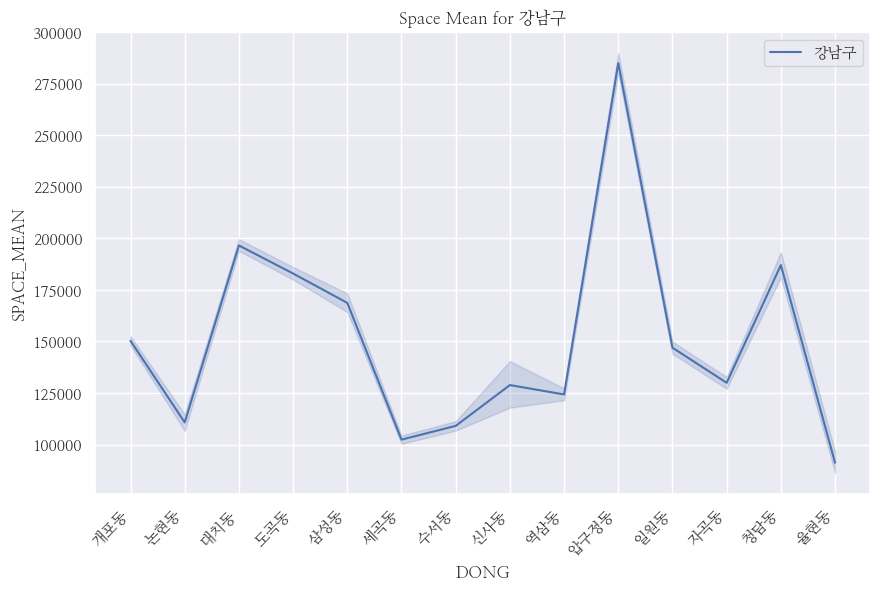

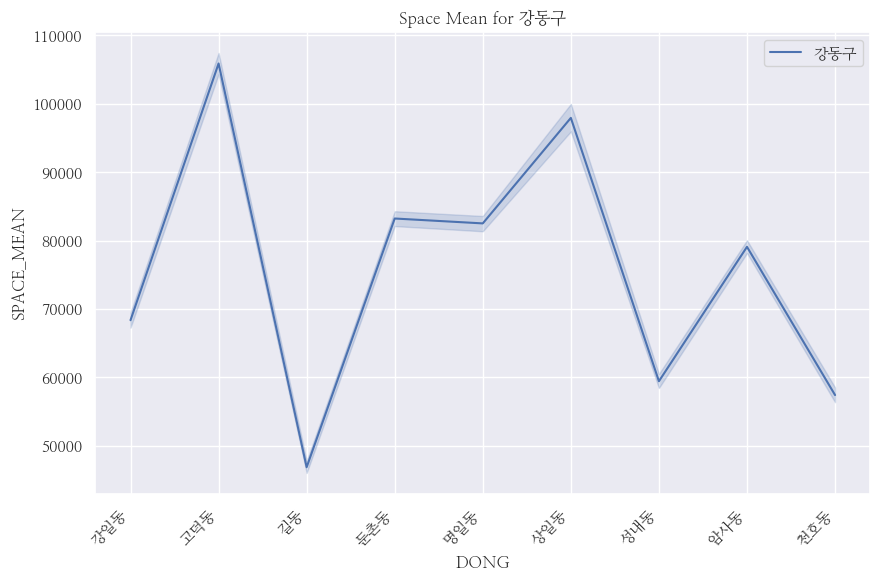

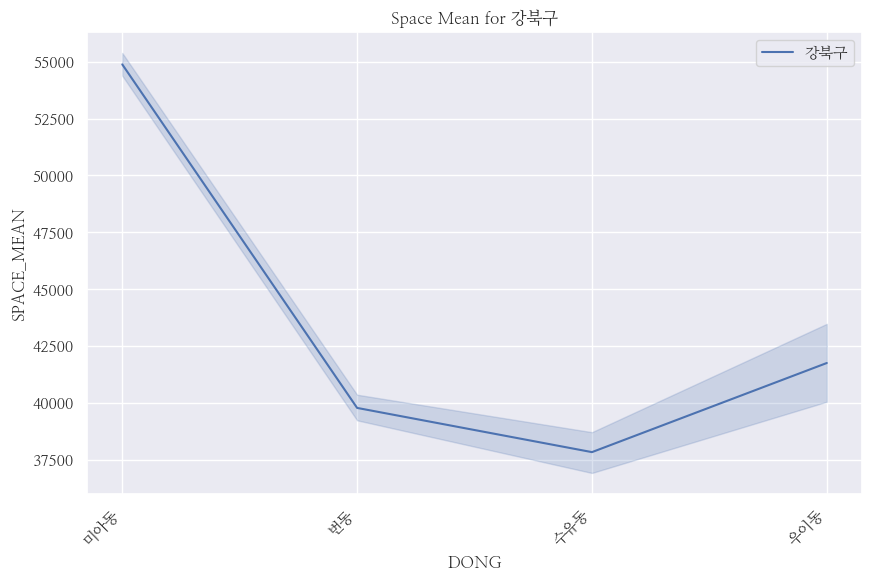

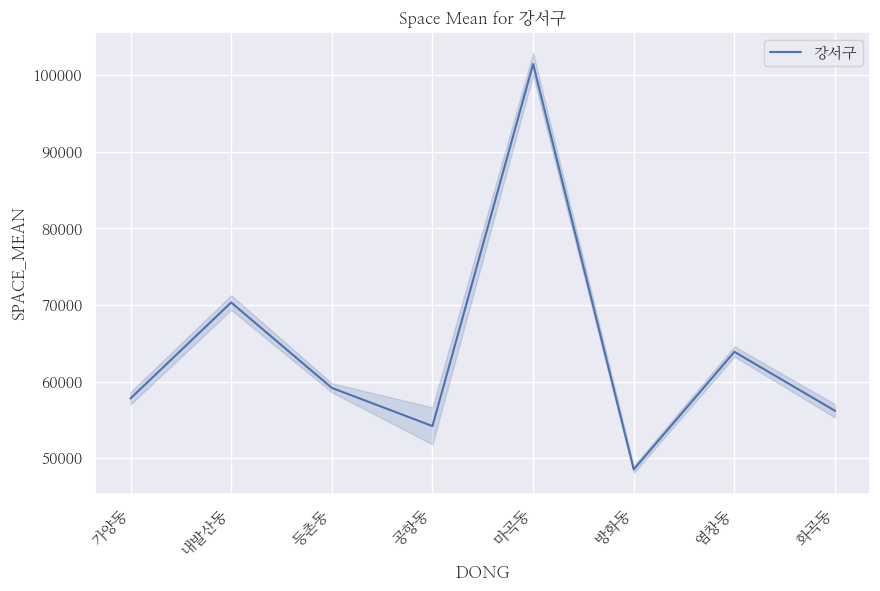

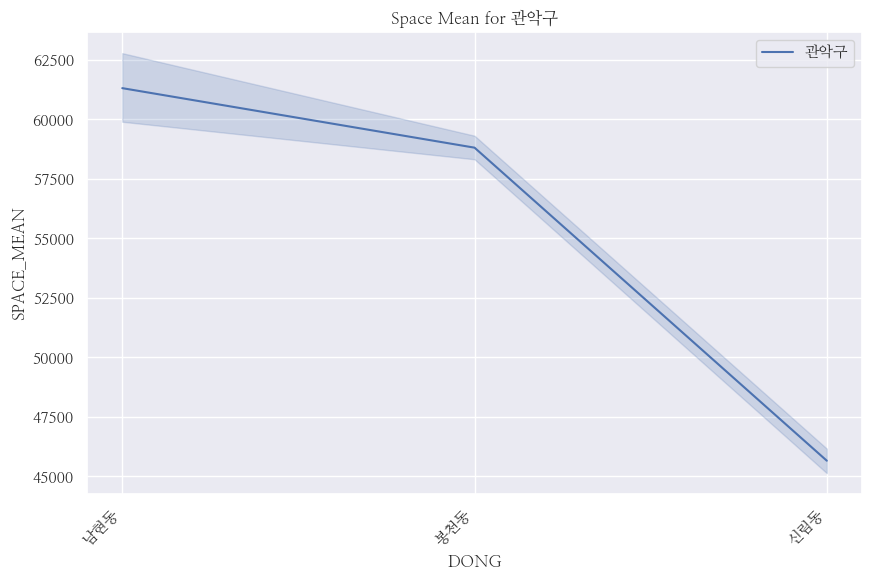

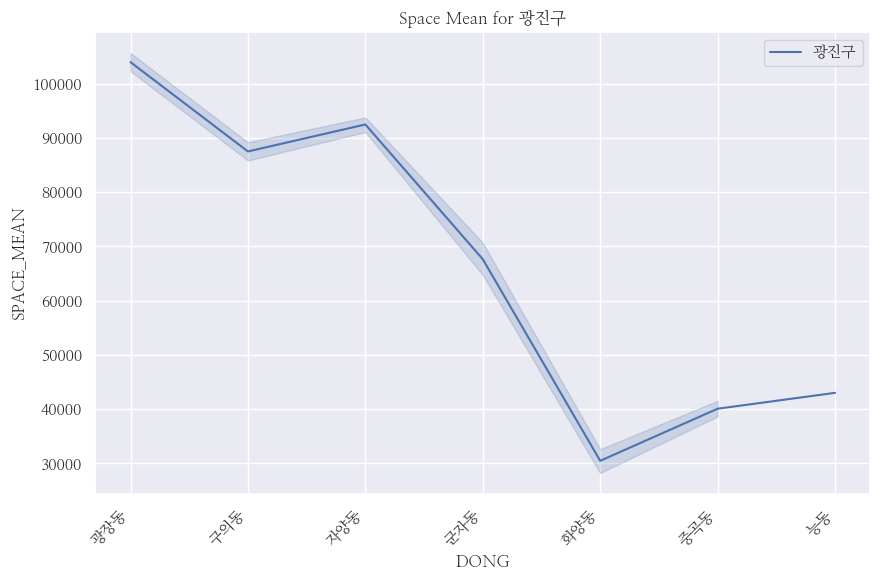

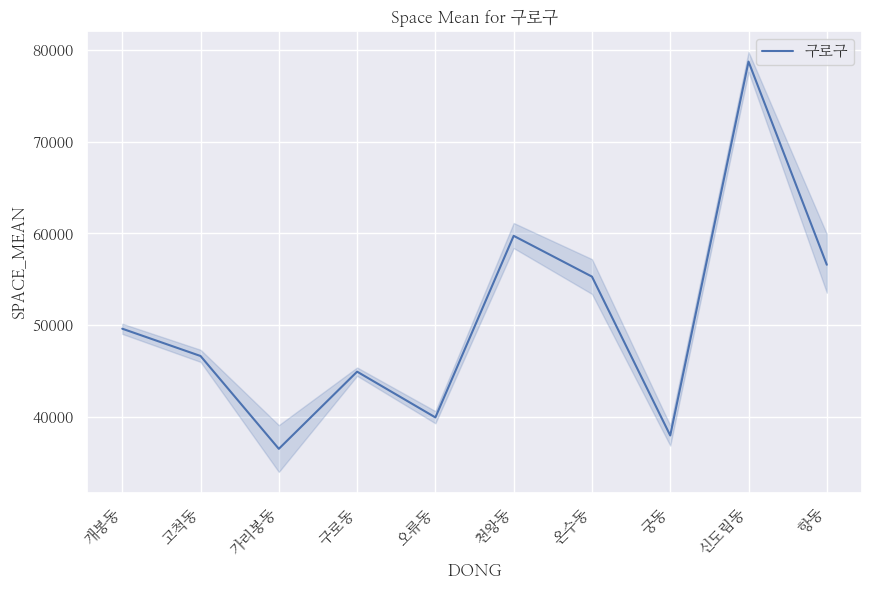

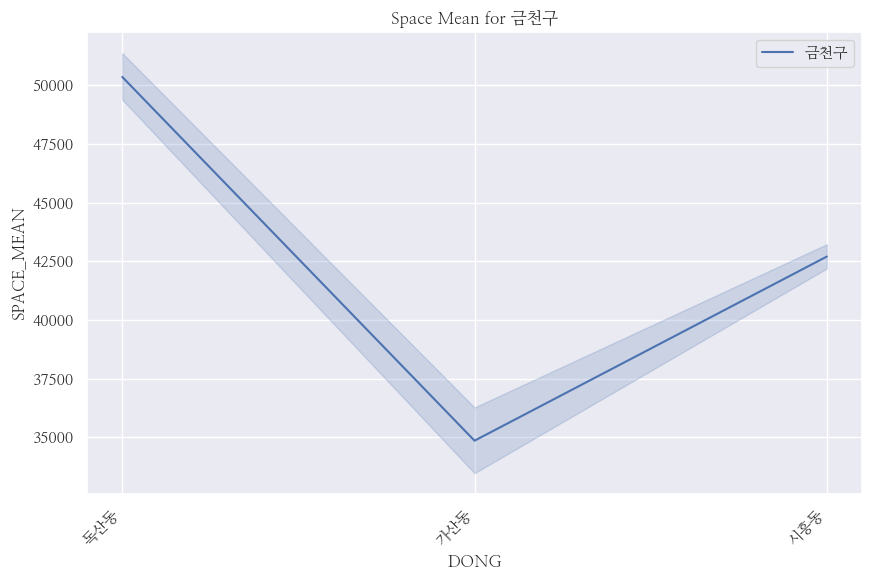

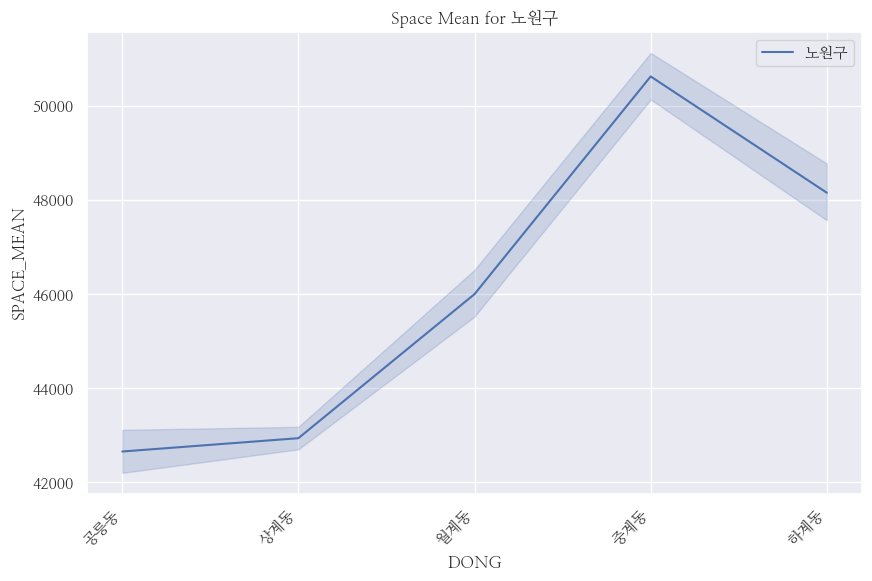

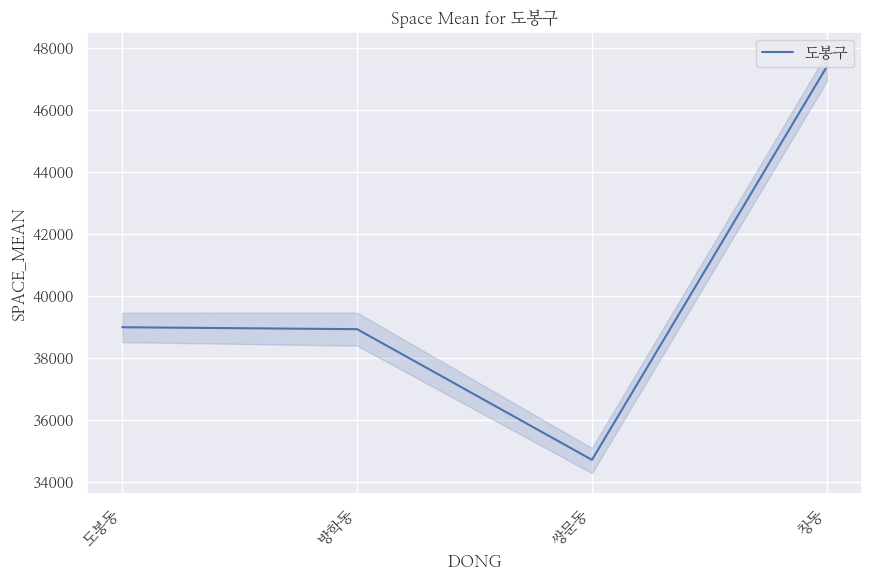

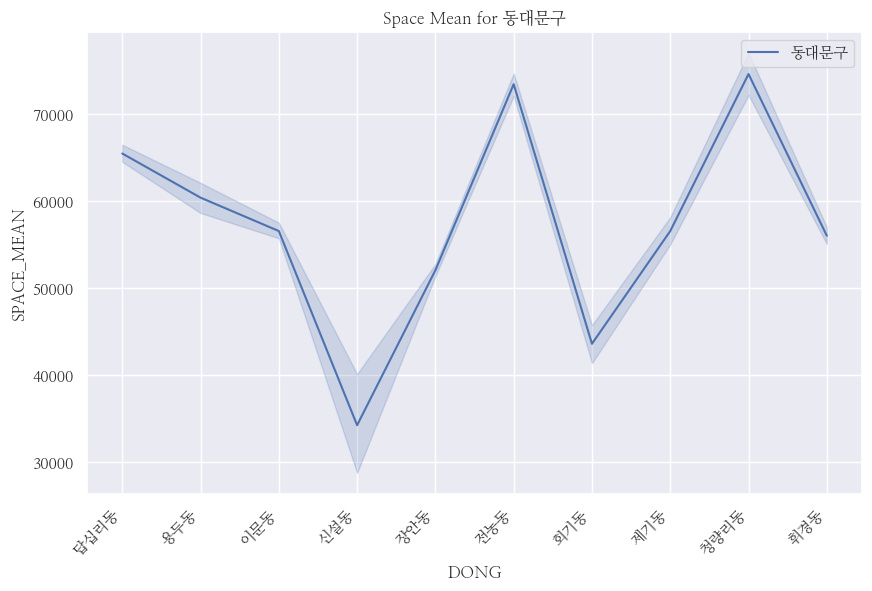

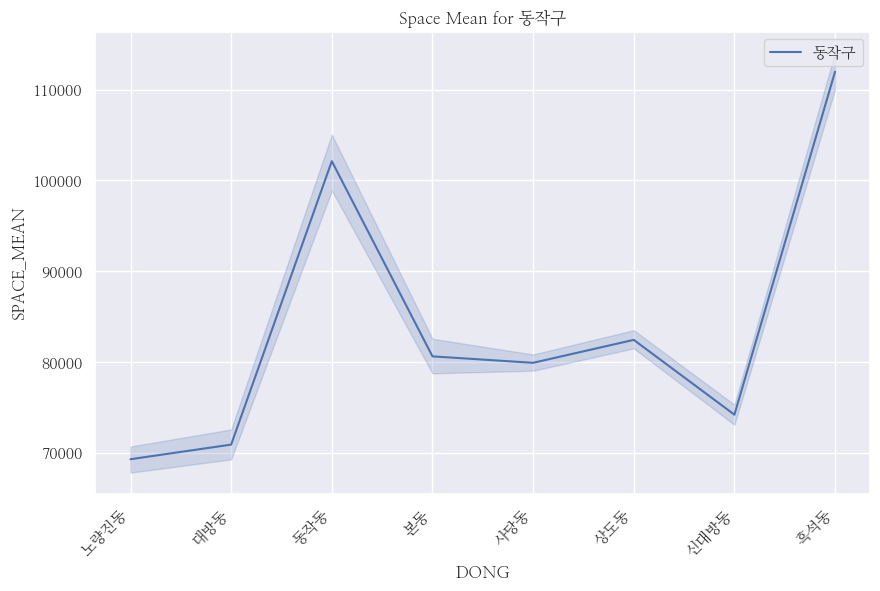

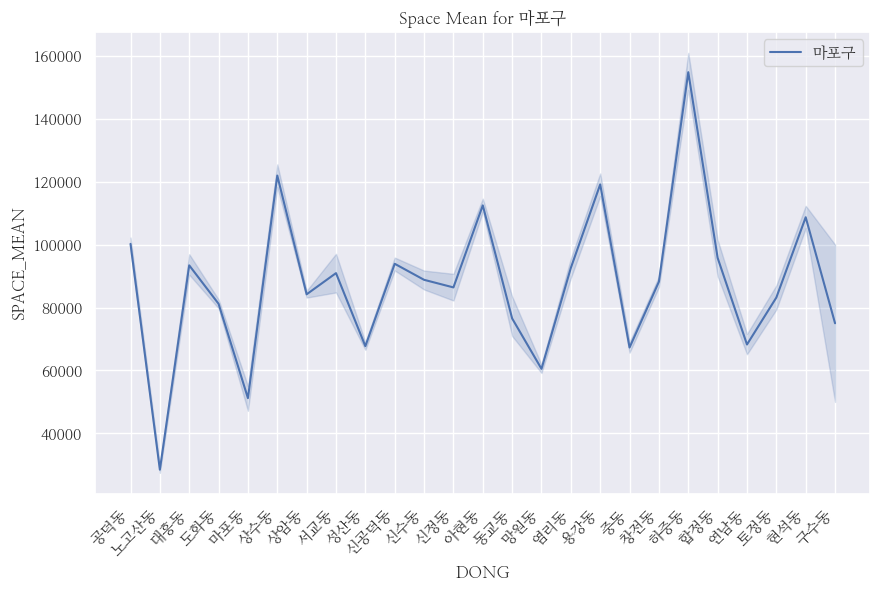

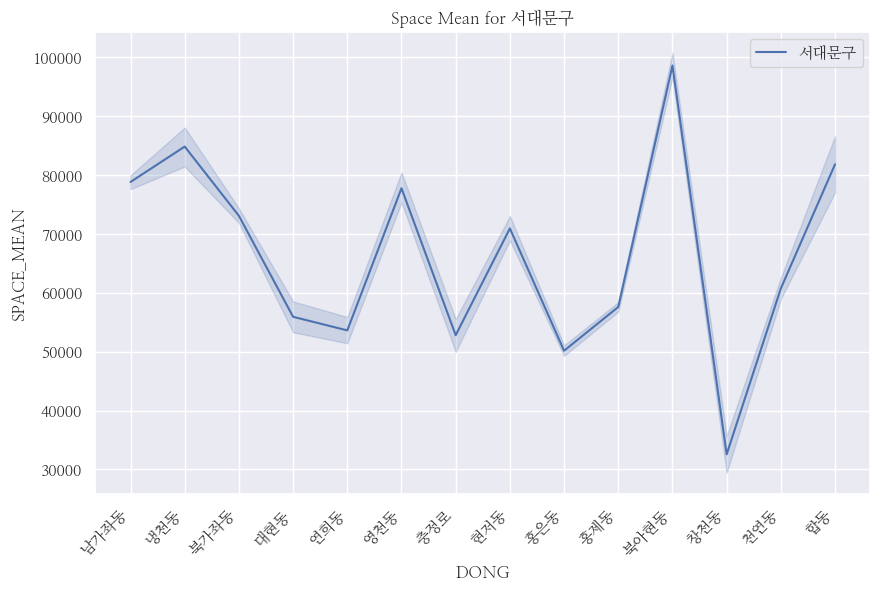

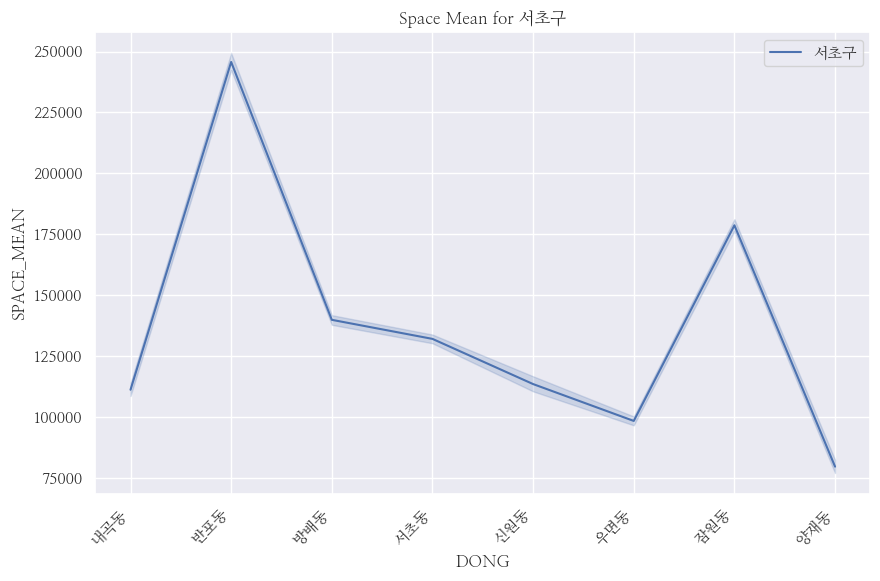

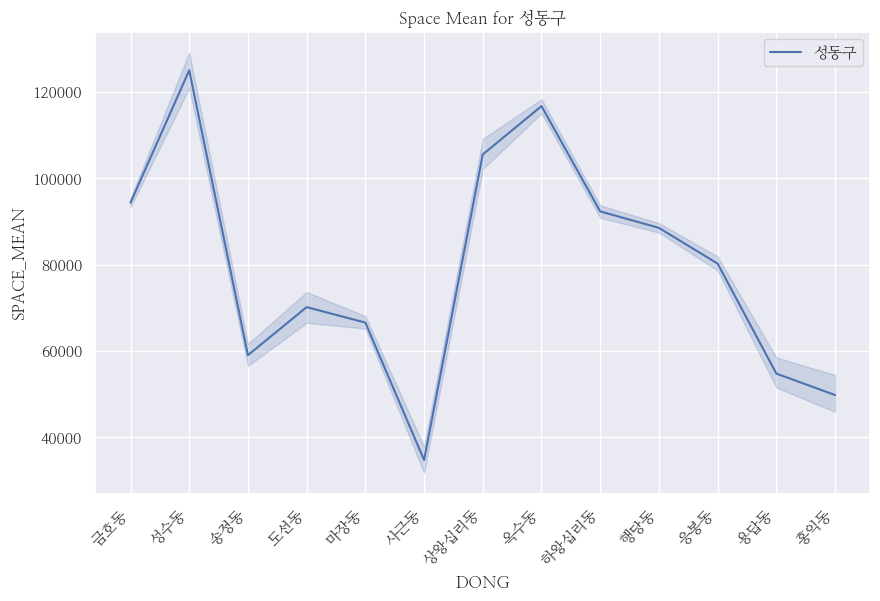

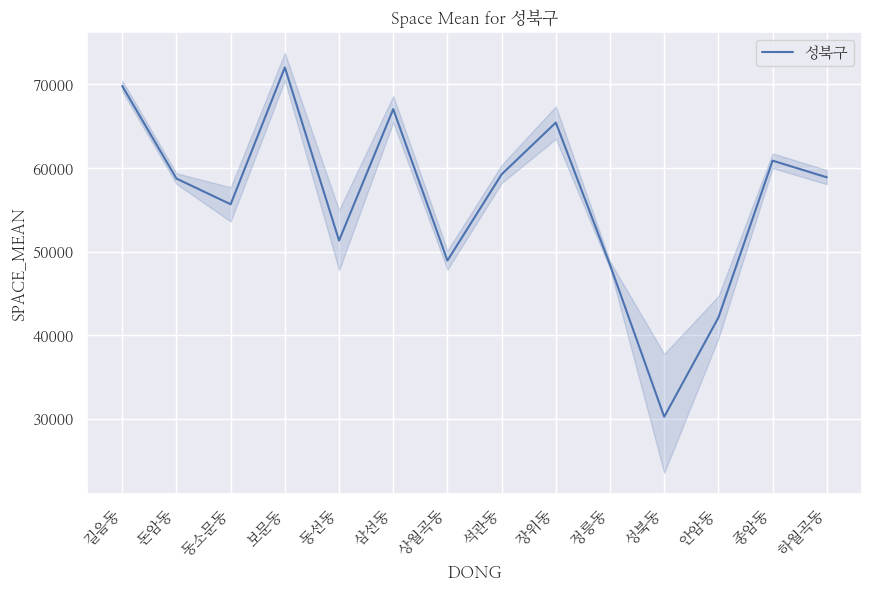

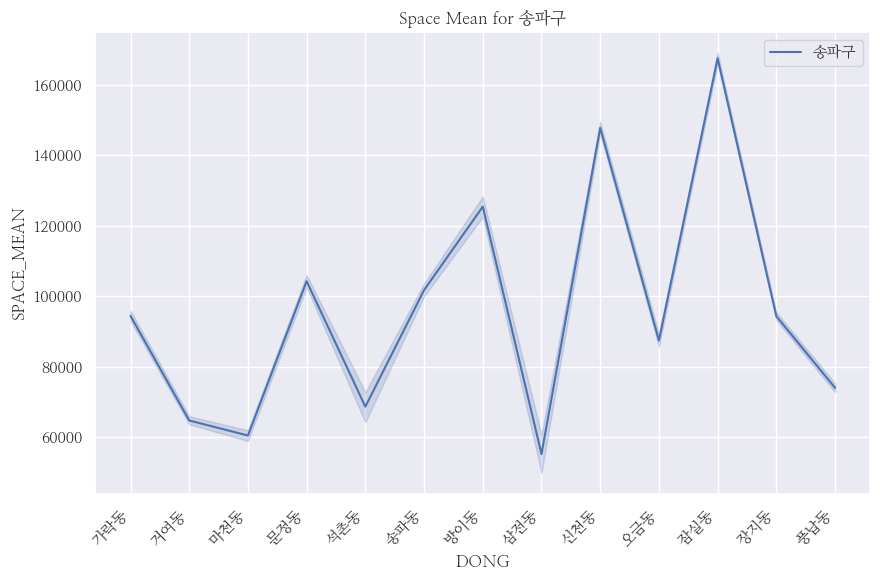

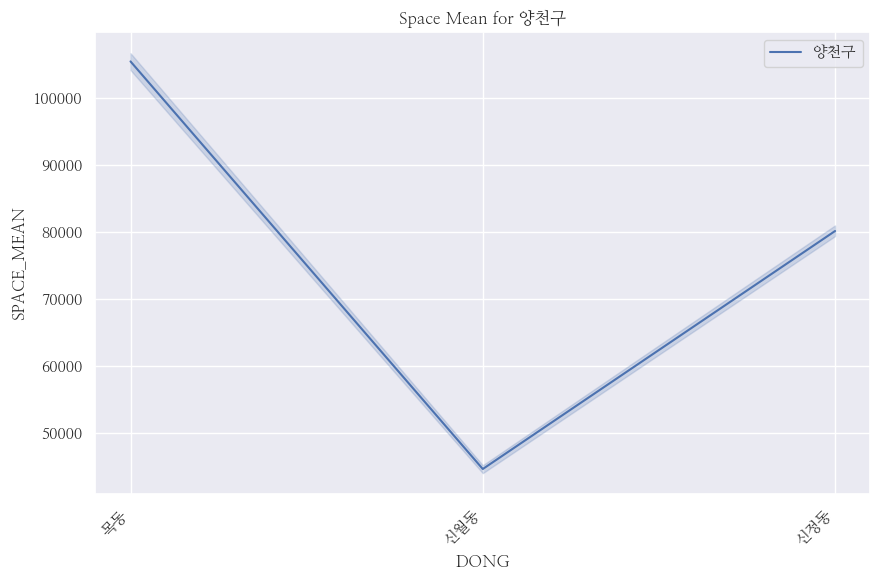

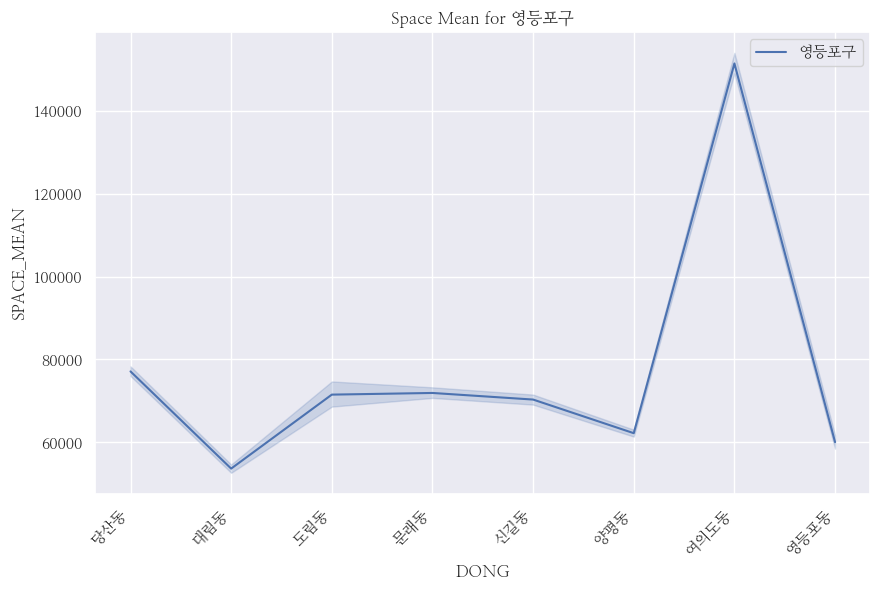

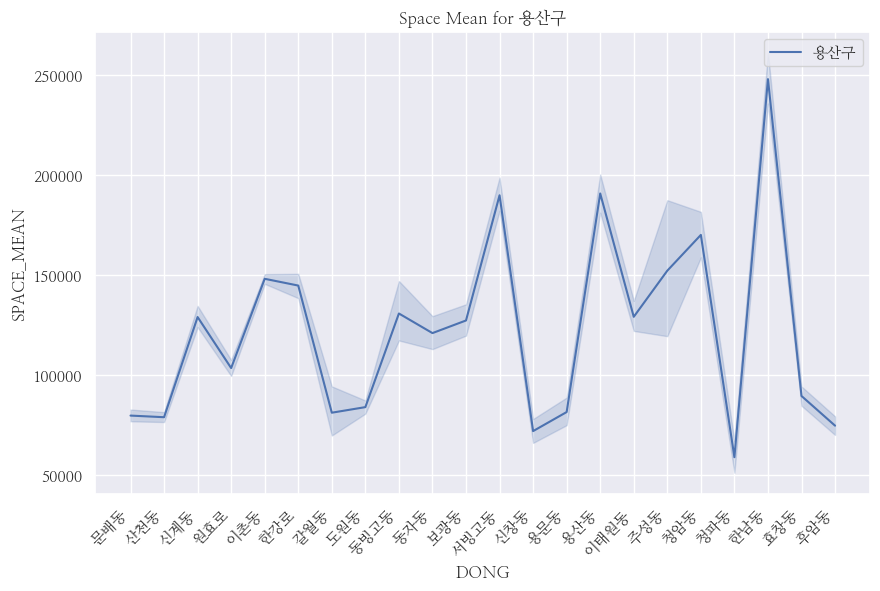

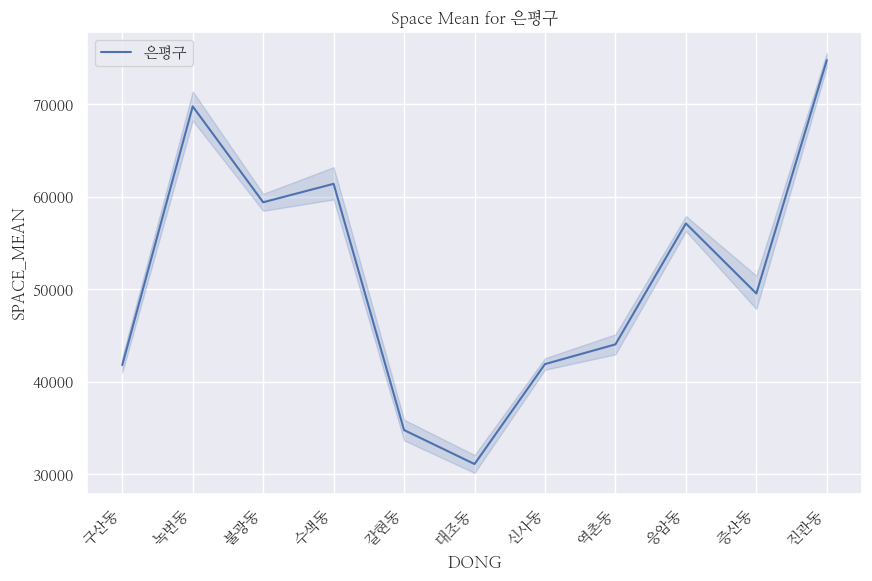

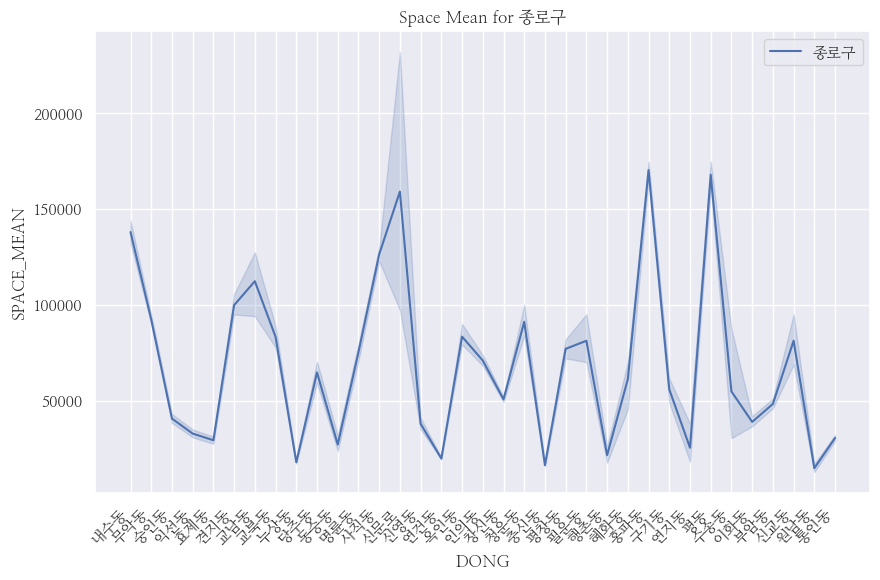

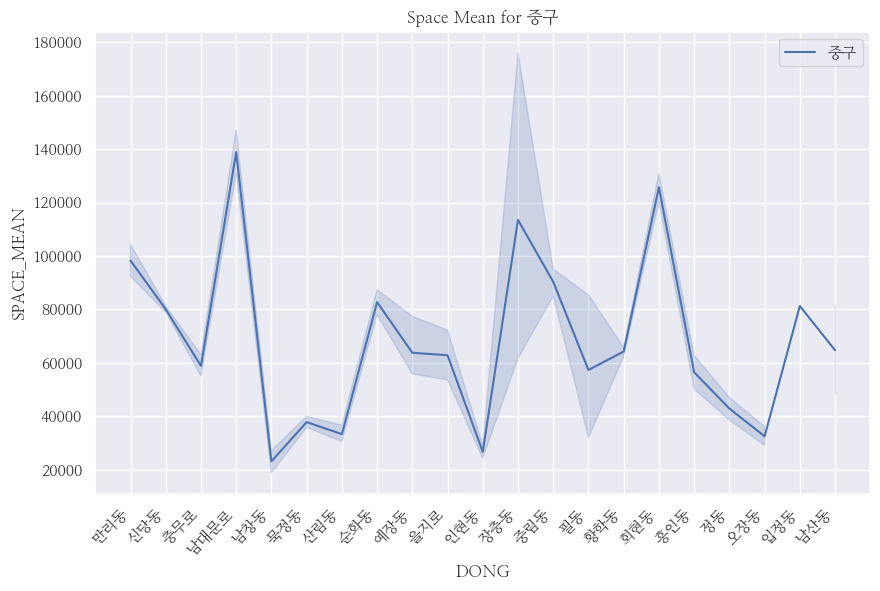

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

names = ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구']

# for i in names:
#     sns.lineplot(data = train1, x = train1[train1['GU']==i]['DONG'], y = 'SPACE_MEAN')

# Set the style for better visualization
sns.set(style="whitegrid")

# Set Korean font for Matplotlib
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'  # Replace with the actual path to your Korean font file
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

# Create a line plot for each district
for district in names:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    
    # Set Korean font for Seaborn
    sns.set(font=fontprop.get_name())
    
    # Create line plot
    sns.lineplot(data=train1[train1['GU'] == district], x='DONG', y='target', label=district)
    
    # Set plot title and labels
    plt.title(f'Space Mean for {district}', fontproperties=fontprop)
    plt.xlabel('DONG', fontproperties=fontprop)
    plt.ylabel('SPACE_MEAN', fontproperties=fontprop)
    
       # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.show()

### 4-2. 각 구의 동별 아파트 평당 평균 가격 

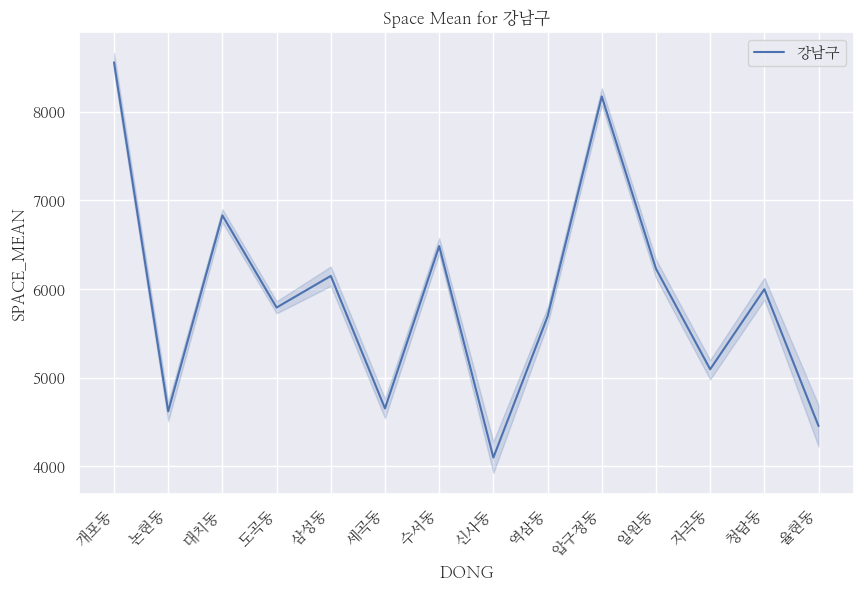

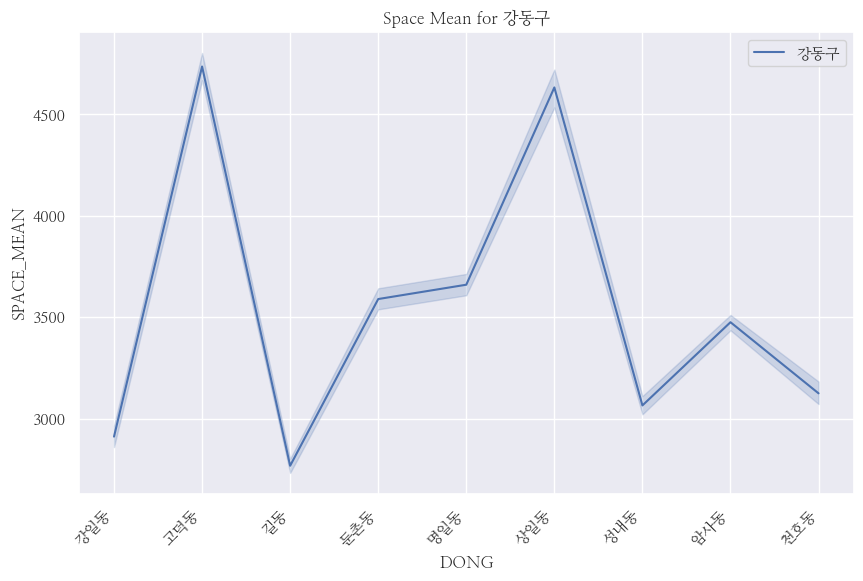

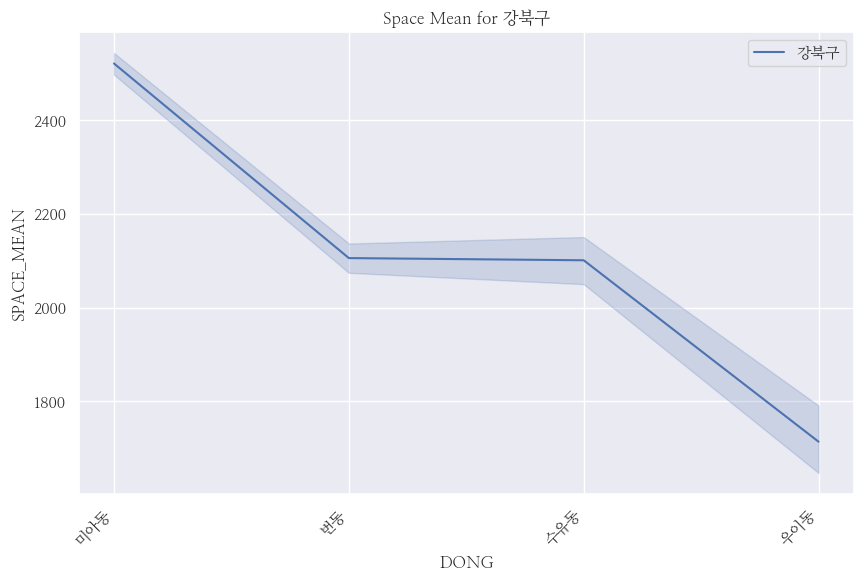

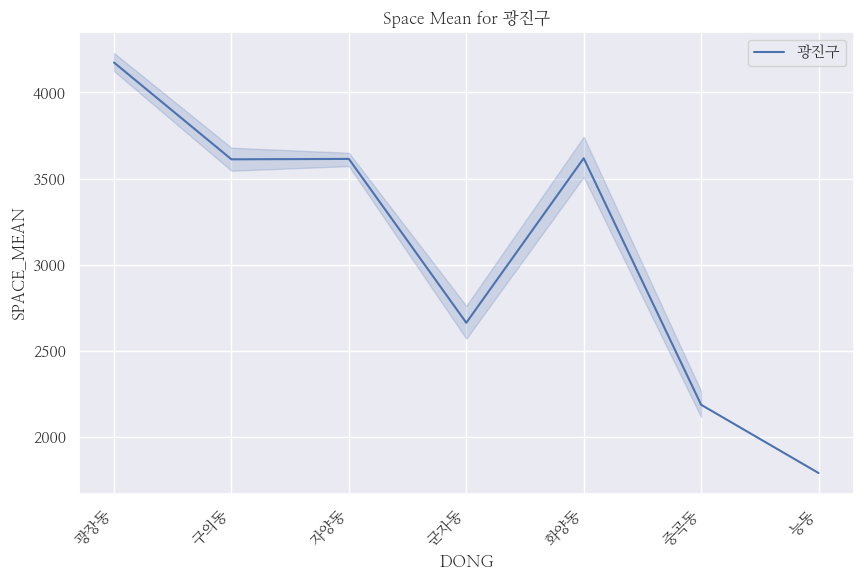

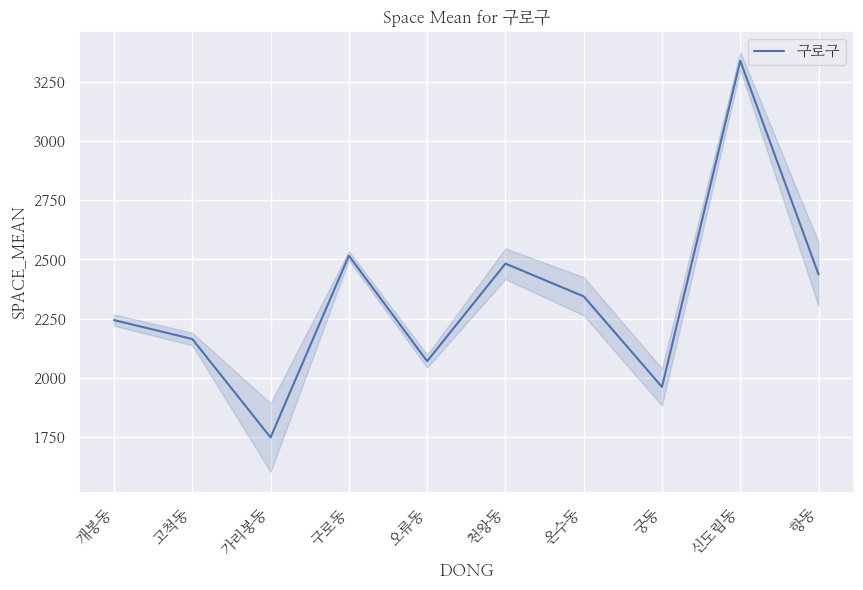

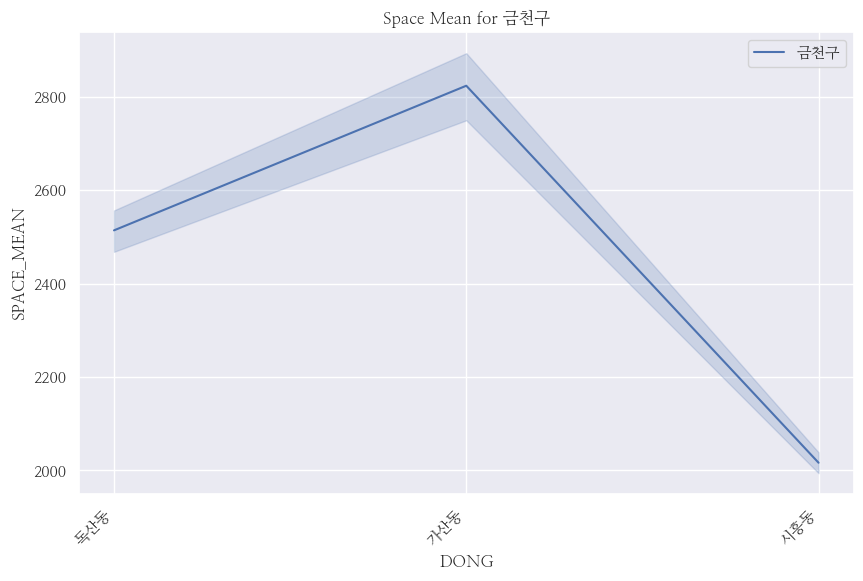

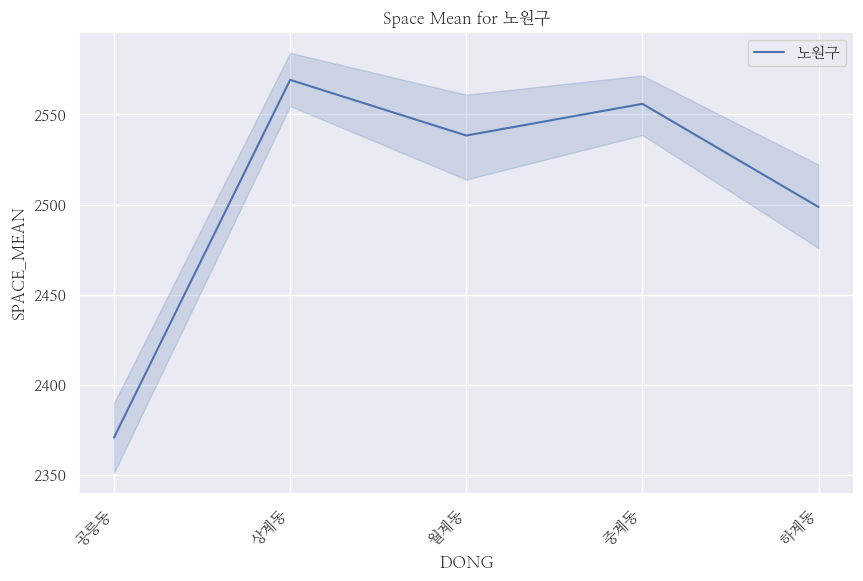

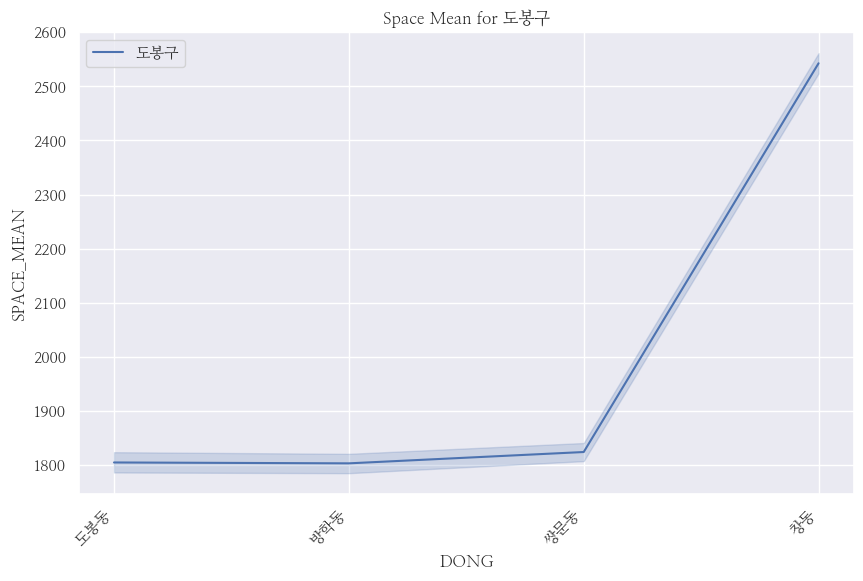

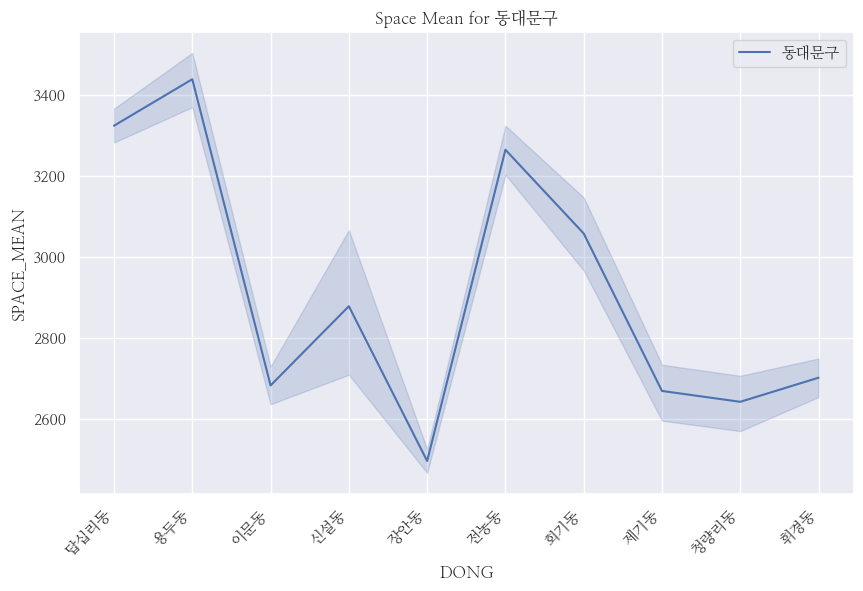

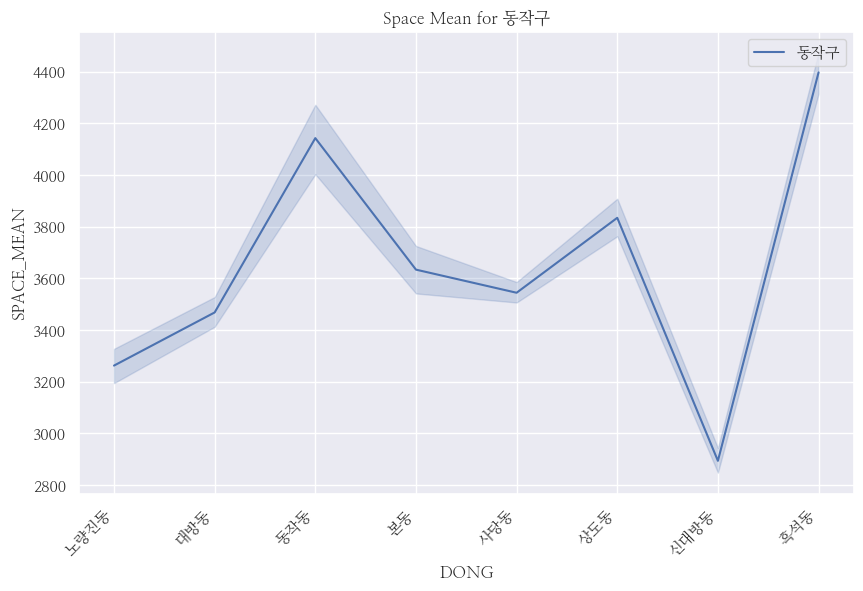

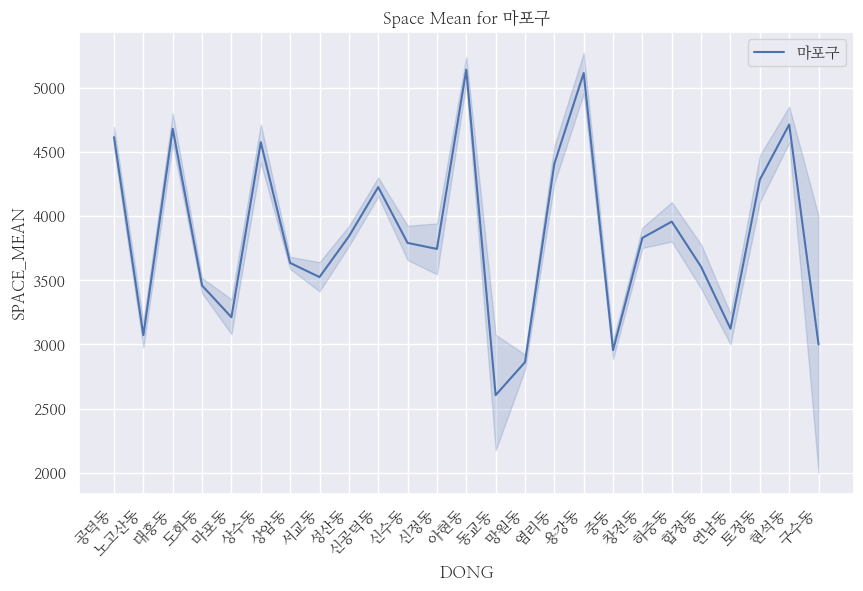

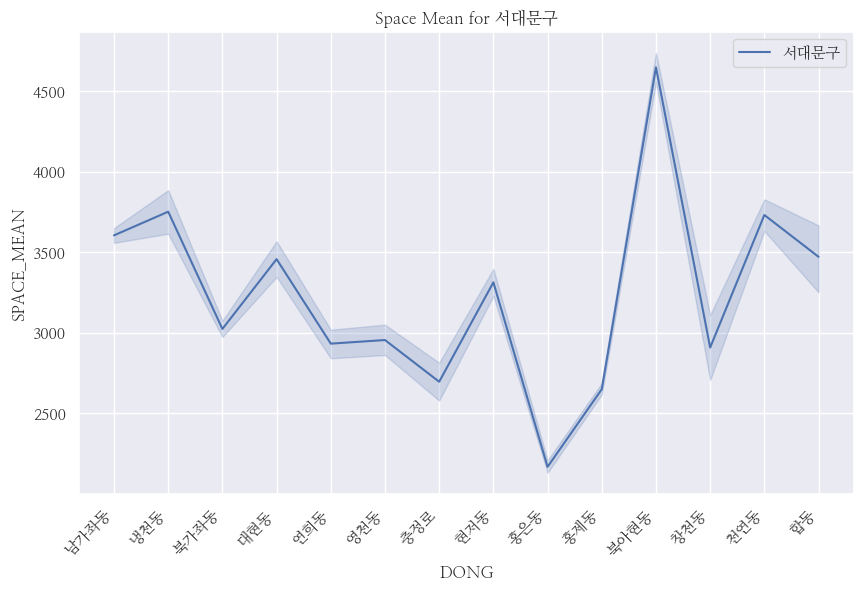

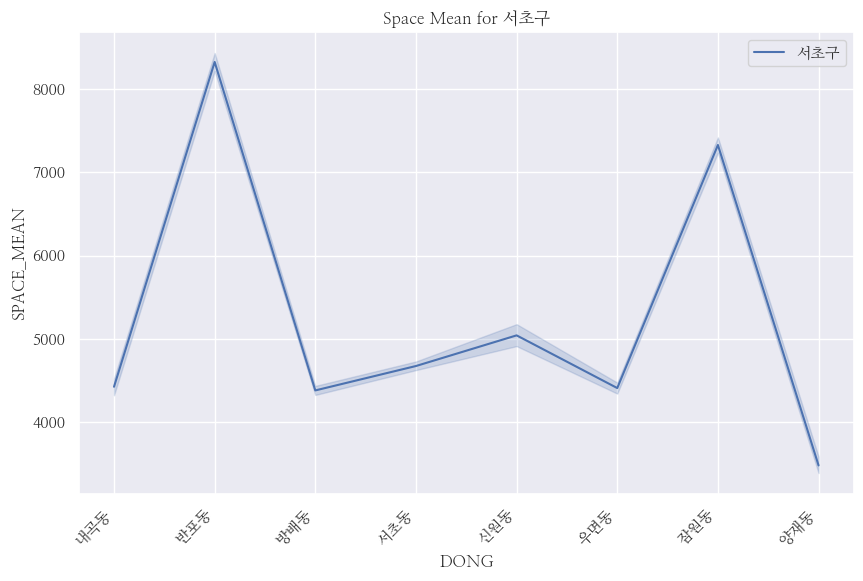

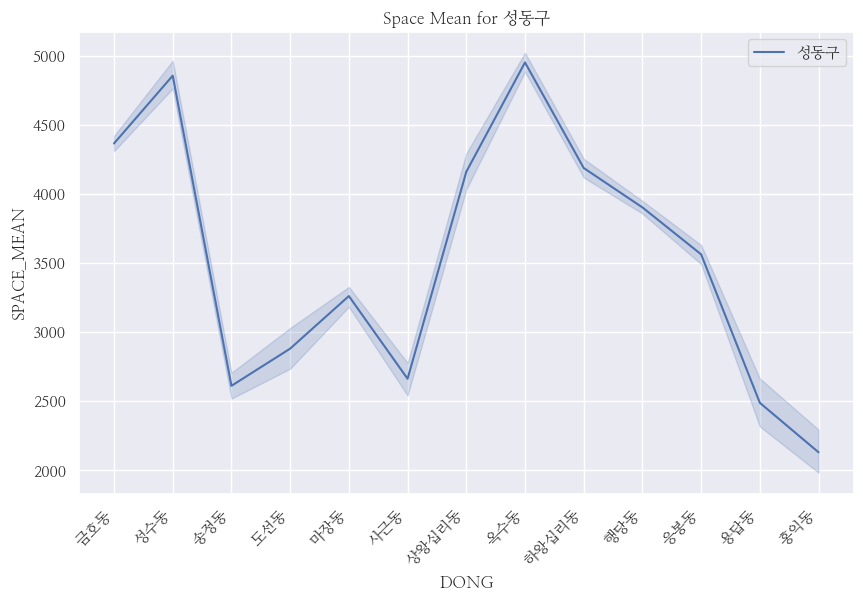

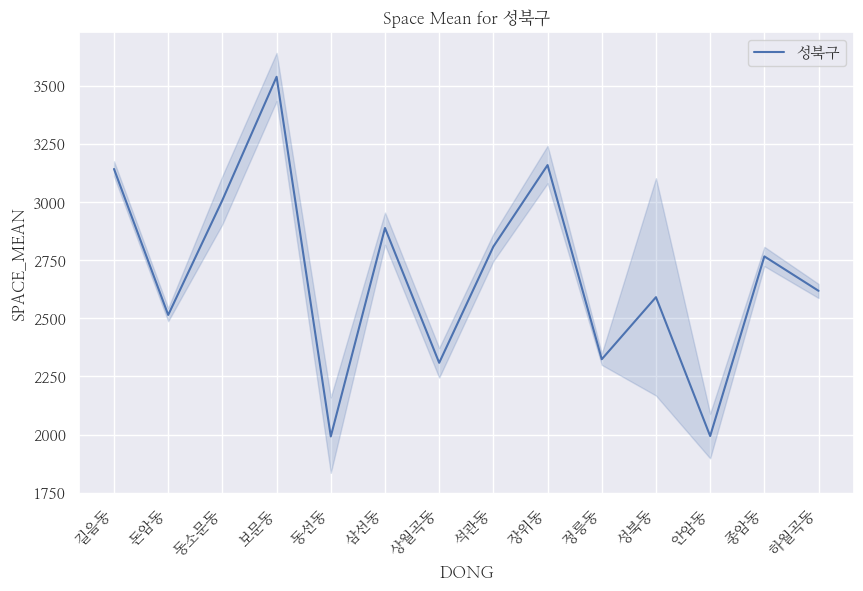

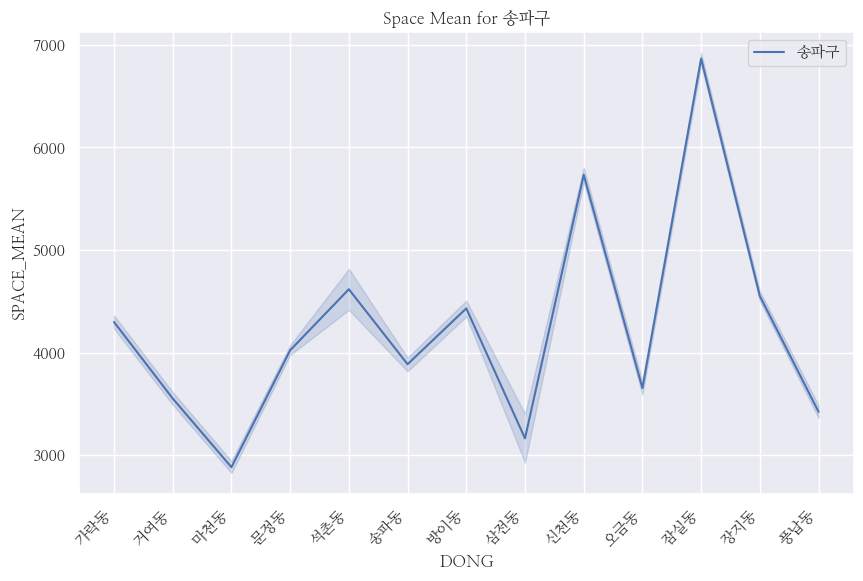

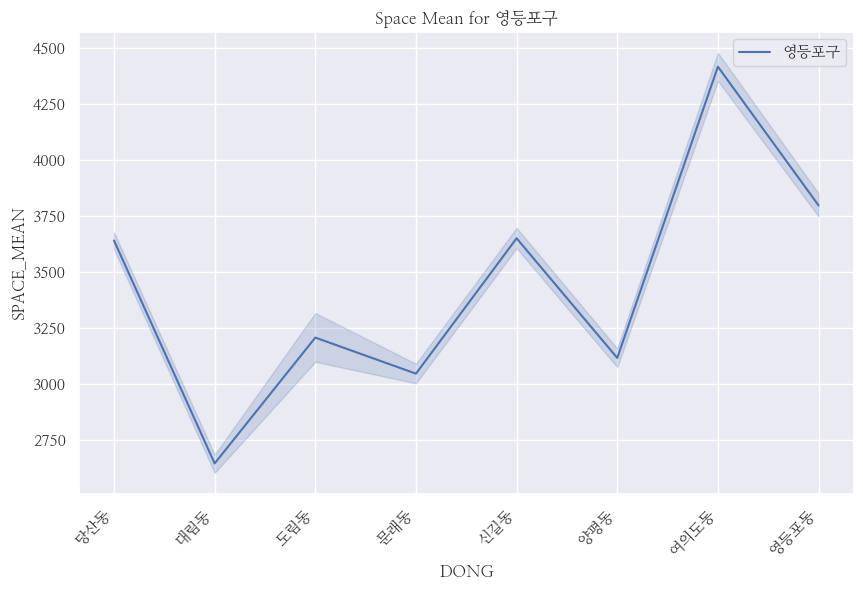

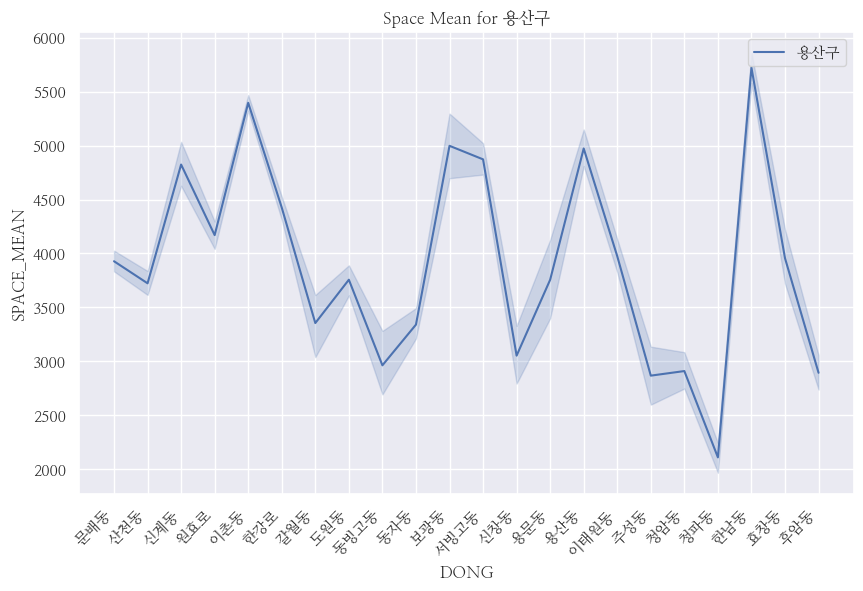

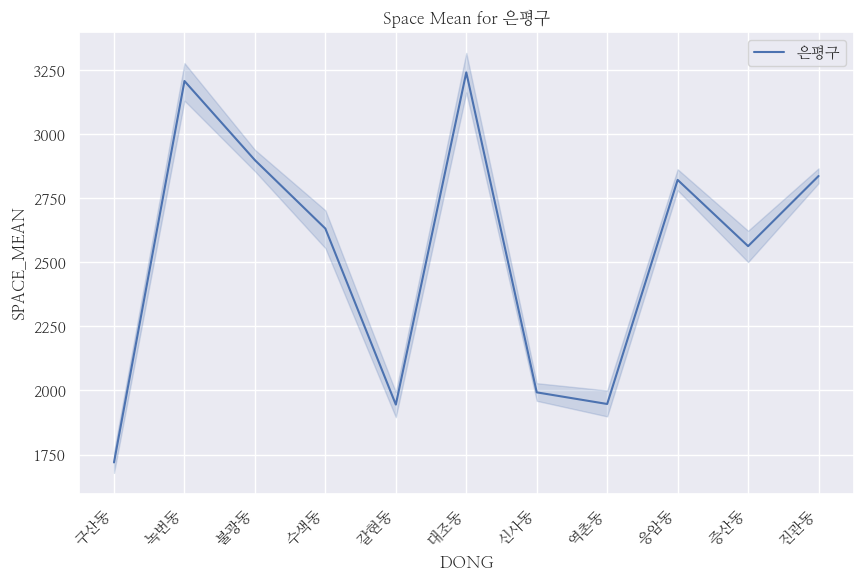

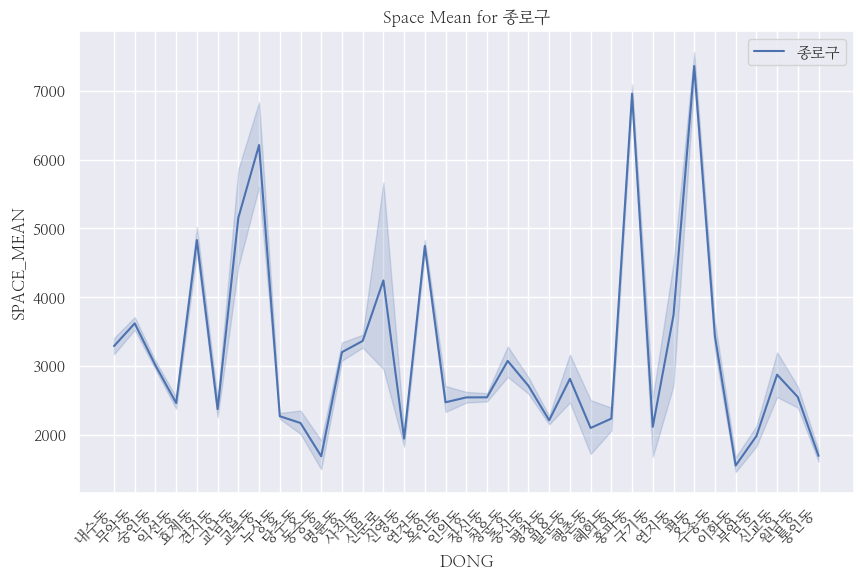

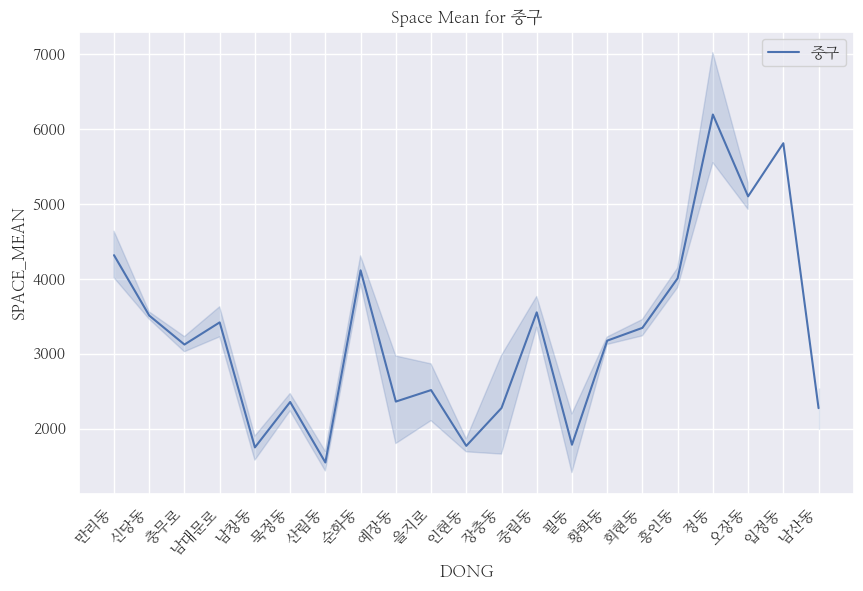

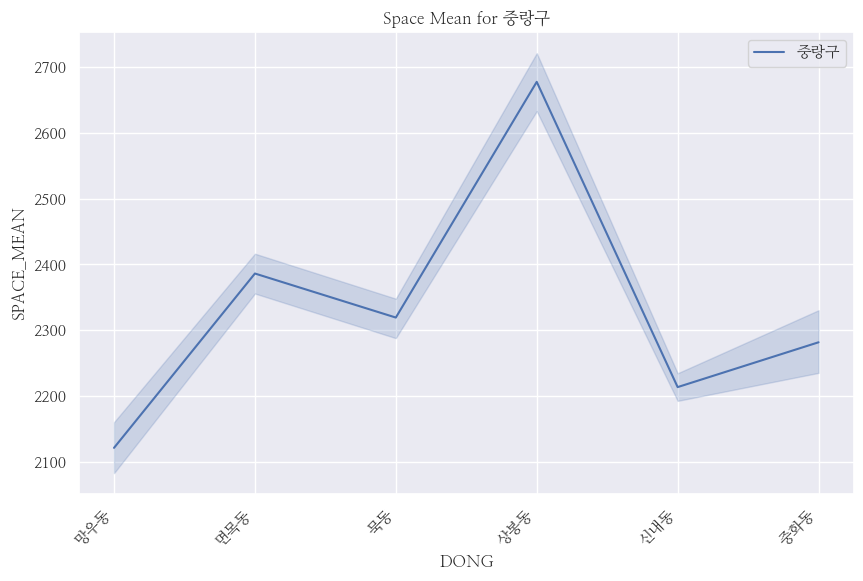

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

names = ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구']

# for i in names:
#     sns.lineplot(data = train1, x = train1[train1['GU']==i]['DONG'], y = 'SPACE_MEAN')

# Set the style for better visualization
sns.set(style="whitegrid")

# Set Korean font for Matplotlib
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'  # Replace with the actual path to your Korean font file
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

# Create a line plot for each district
for district in names:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    
    # Set Korean font for Seaborn
    sns.set(font=fontprop.get_name())
    
    # Create line plot
    sns.lineplot(data=train1[train1['GU'] == district], x='DONG', y='SPACE_MEAN', label=district)
    
    # Set plot title and labels
    plt.title(f'Space Mean for {district}', fontproperties=fontprop)
    plt.xlabel('DONG', fontproperties=fontprop)
    plt.ylabel('SPACE_MEAN', fontproperties=fontprop)
    
       # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.show()

In [199]:
train1.groupby('DONGAPT_NM')['SPACE_MEAN'].mean()[train1.groupby('DONGAPT_NM')['SPACE_MEAN'].mean() < 1000]

DONGAPT_NM
개봉동 개봉프라자         967.68
개봉동 동서            942.65
개봉동 왕궁            971.71
구로동 가람빌라          964.29
구로동 구로아트빌라8       988.24
구로동 남구로           843.75
구로동 대영빌라          882.05
구로동 명성빌라3차        988.24
구로동 미도빌라B동        917.31
구로동 우진빌라1차B       892.86
구로동 장미빌라          928.89
구로동 장수            988.24
구로동 청우아트빌라3차      944.44
구산동 타워            949.33
녹번동 현재맨션          960.32
도봉동 삼안리치          900.00
방학동 부흥            975.04
방학동 선덕빌라트         934.34
방학동 태양            964.17
불광동 그린라이프         756.00
상계동 보람그린APT101동   954.17
상도동 상무            808.70
수유동 화계맨숀          738.32
신당동 인성아트빌         839.22
신월동 은하            998.09
쌍문동 로얄            738.73
쌍문동 쌍문동LG트윈빌1     881.02
쌍문동 피스플하우스        906.10
쌍문동 한영            844.00
역삼동 마이다스힐빌라트      986.30
역촌동 무궁화           841.39
역촌동 현대타운          931.97
연희동 시민            814.94
연희동 충우하이빌         754.84
온수동 두양그린B동        943.71
정릉동 동우            963.58
정릉동 청옥            986.67
창동 신창빌라트          760.00
홍은동 명지2차          963.34
홍제동 서강        

In [201]:
((train1.groupby('DONGAPT_NM')['SPACE_MEAN'].mean()<1350)).sum()

587

In [190]:
((train1.groupby('DONGAPT_NM')['SPACE_MEAN'].mean()<42500)&
(train1.groupby('DONGAPT_NM')['SPACE_MEAN'].mean()>=1000)).sum()

DONGAPT_NM
가락동 e지브로                   [2080.0, 1418.6046511627908, 3080.0, 2268.0, 1...
가락동 sk파크타워                 [2320.0, 2340.0, 2187.5, 2250.0, 2400.0, 2520....
가락동 가락3차쌍용스윗닷홈             [2396.0, 2780.0, 2680.0, 3120.0, 3020.0, 3200....
가락동 가락3차쌍용스윗닷홈101동,102동    [2880.0, 3040.0, 3200.0, 3240.0, 4147.05882352...
가락동 가락그랑밸리                 [2078.9473684210525, 2645.8333333333335, 2390....
                                                 ...                        
흥인동 aaa                    [1750.0, 2045.4545454545455, 2200.0, 2160.0, 2...
흥인동 동대문솔하임                 [4983.333333333333, 5000.0, 5060.0, 4900.0, 45...
흥인동 동대문와이즈캐슬               [4225.0, 4250.0, 3533.3333333333335, 4200.0, 5...
흥인동 위더스하임                  [4966.666666666667, 6375.0, 4866.666666666667,...
흥인동 청계천두산위브더제니스            [2431.818181818182, 2540.5405405405404, 2432.4...
Name: SPACE_MEAN, Length: 7928, dtype: object

#### 4-3. Target

#### 4-3-1. 아파트명 < 10000 中 아파트 평균 1억 이하

##### 아파트 매매가가 1억 이하인 거래들의 아파트명 확인

In [5]:
len(train1[train1['target']<10000]['APT_NM'].unique().tolist())
# len(train1[(train1['CONTR']>=20180101)&(train1['target']<10000)]['APT_NM'].unique().tolist())
train1[(train1['APT_NM'].isna())&(train1['target']<10000)]['target']

In [84]:
train1[train1['target']<10000]['APT_NM'].unique()
# train1[(train1['CONTR']>=20180101)&(train1['target']<10000)]['APT_NM'].unique()

array(['현대웰하임', '대성월드빌', '수유역하이씨티', 'AirPalace', '경동팰리스힐', 'AndPra레지던스',
       '강서동도센트리움', '블루힐', '트리움팰리스', '한양아이클래스', '화양타워', nan, '궁전아트빌라',
       '미도빌라B동', '세명', '재선주택', '청우아트빌리지', '코원', '다청림', '썬앤빌', '오류동역솔리스타',
       '포스시티', '시흥', '와이즈플레이스', '진명비베레', '퍼스티안', '한솔캐스빌', '월가타워',
       '코지언레지던스', '연희궁', '대광', '여의도의아침', '수산타운', '장충', 'EGSoulLeader',
       '신영', '헤르만스테이트', '청광플러스원', '수유프리미어엠', '경동엠파이어스테이트', '황제팰리체',
       '코스모그린', '센시티16', '주성아우라', '투니온', '쌍용플래티넘S', '신길레전드힐스', '더하이어',
       '강동와이시티', '신림큐브', '대림역포스큐', '비즈트위트오렌지', '하나세인스톤3차', '가산지웰에스테이트',
       '비즈트위트바이올렛5차', '미라쉘', 'YS홈타운', '제이타워4', '종로유케이201', '강동큐브',
       '청광플러스원큐브2차', '크라운빌', '화계맨숀', '건양', '그린플러스구로해담채2', '대영빌라',
       '비즈트위트그린', '비즈트위트레인보우', '조성빌라', '가산양우내안에애플', '로얄', '현대썬앤빌601',
       '청계푸르지오시티', '한일노벨리아', '가우디캐슬', '양우내안애애플', '장안뉴시티', '제이타워1',
       '하이텍하우스', '대성', '유정', '인성아트빌', '청광플러스원큐브3차', '한양립스', '대길B',
       '대림역와이즈플레이스', '성산E동', '정창빌라', '청우아트빌라3차', '현대휴온', '시민', '동방',
       'SRvill', '세교예지안2차', '

##### 아파트 매매가가 1억 이하인 거래들의 아파트명들의 평균 확인

In [86]:
aparts = ['현대웰하임', '대성월드빌', '수유역하이씨티', 'AirPalace', '경동팰리스힐', 'AndPra레지던스',
       '강서동도센트리움', '블루힐', '트리움팰리스', '한양아이클래스', '화양타워', '궁전아트빌라',
       '미도빌라B동', '세명', '재선주택', '청우아트빌리지', '코원', '다청림', '썬앤빌', '오류동역솔리스타',
       '포스시티', '시흥', '와이즈플레이스', '진명비베레', '퍼스티안', '한솔캐스빌', '월가타워',
       '코지언레지던스', '연희궁', '대광', '여의도의아침', '수산타운', '장충', 'EGSoulLeader',
       '신영', '헤르만스테이트', '청광플러스원', '수유프리미어엠', '경동엠파이어스테이트', '황제팰리체',
       '코스모그린', '센시티16', '주성아우라', '투니온', '쌍용플래티넘S', '신길레전드힐스', '더하이어',
       '강동와이시티', '신림큐브', '대림역포스큐', '비즈트위트오렌지', '하나세인스톤3차', '가산지웰에스테이트',
       '비즈트위트바이올렛5차', '미라쉘', 'YS홈타운', '제이타워4', '종로유케이201', '강동큐브',
       '청광플러스원큐브2차', '크라운빌', '화계맨숀', '건양', '그린플러스구로해담채2', '대영빌라',
       '비즈트위트그린', '비즈트위트레인보우', '조성빌라', '가산양우내안에애플', '로얄', '현대썬앤빌601',
       '청계푸르지오시티', '한일노벨리아', '가우디캐슬', '양우내안애애플', '장안뉴시티', '제이타워1',
       '하이텍하우스', '대성', '유정', '인성아트빌', '청광플러스원큐브3차', '한양립스', '대길B',
       '대림역와이즈플레이스', '성산E동', '정창빌라', '청우아트빌라3차', '현대휴온', '시민', '동방',
       'SRvill', '세교예지안2차', '아녜스타워4', '팔라이스타워', '모란빌라', '백운스위트빌', '청남',
       '영등포메이준2011']

for apart in aparts:
    mean = train1[(train1['APT_NM']==apart)]['target'].mean()
    print(f'{apart} 평균 : {mean}')

현대웰하임 평균 : 11330.95588235294
대성월드빌 평균 : 10720.0
수유역하이씨티 평균 : 9813.666666666666
AirPalace 평균 : 9949.375
경동팰리스힐 평균 : 9900.0
AndPra레지던스 평균 : 13395.238095238095
강서동도센트리움 평균 : 10020.459016393443
블루힐 평균 : 24033.333333333332
트리움팰리스 평균 : 11619.047619047618
한양아이클래스 평균 : 9396.292134831461
화양타워 평균 : 16965.384615384617
궁전아트빌라 평균 : 11290.0
미도빌라B동 평균 : 11925.0
세명 평균 : 17880.76923076923
재선주택 평균 : 9400.0
청우아트빌리지 평균 : 14162.5
코원 평균 : 9333.333333333334
다청림 평균 : 27354.716981132075
썬앤빌 평균 : 8161.044776119403
오류동역솔리스타 평균 : 10057.407407407407
포스시티 평균 : 10010.227272727272
시흥 평균 : 12635.897435897436
와이즈플레이스 평균 : 9520.188679245282
진명비베레 평균 : 8992.857142857143
퍼스티안 평균 : 9773.125
한솔캐스빌 평균 : 13563.636363636364
월가타워 평균 : 9635.0
코지언레지던스 평균 : 10172.58064516129
연희궁 평균 : 13258.333333333334
대광 평균 : 20095.0
여의도의아침 평균 : 11545.833333333334
수산타운 평균 : 11050.0
장충 평균 : 11839.6875
EGSoulLeader 평균 : 9494.155844155845
신영 평균 : 10310.877192982456
헤르만스테이트 평균 : 12282.857142857143
청광플러스원 평균 : 33783.04878048781
수유프리미어엠 평균 : 12106.25
경

아파트명 평균가가 가장 낮은 아파트명 평균가

In [87]:
train1.groupby('APT_NM')['target'].mean()[train1.groupby('APT_NM')['target'].mean() < 10000].min()

7038.888888888889

In [107]:
train1.groupby('APT_NM')['target'].mean()[train1.groupby('APT_NM')['target'].mean() < 10000]

APT_NM
AirPalace      9949.38
EGSoulLeader   9494.16
SRvill         7038.89
경동팰리스힐         9900.00
대길B            9650.00
수유역하이씨티        9813.67
썬앤빌            8161.04
아녜스타워4         8113.78
와이즈플레이스        9520.19
월가타워           9635.00
재선주택           9400.00
주성아우라          9127.78
진명비베레          8992.86
코원             9333.33
퍼스티안           9773.12
한양아이클래스        9396.29
황제팰리체          9500.00
Name: target, dtype: float64

##### 위 아파트들 중 train에 있으나, test에 없으면 제거하기함.  


해당되는 아파트명  
excluded_apts = ['AirPalace', 'SRvill', '경동팰리스힐', '대길B', '썬앤빌', '재선주택', '코원']  

In [89]:
test1[test1['APT_NM']=='AirPalace']

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

In [90]:
train1[train1['APT_NM']=='AirPalace']

ADRES LOT_NO     APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
14929   서울특별시 강서구 방화동  619-7  AirPalace          14.50            201712   
14930   서울특별시 강서구 방화동  619-7  AirPalace          14.10            201801   
14931   서울특별시 강서구 방화동  619-7  AirPalace          14.50            201801   
14932   서울특별시 강서구 방화동  619-7  AirPalace          14.10            201802   
14933   서울특별시 강서구 방화동  619-7  AirPalace          14.50            201803   
...               ...    ...        ...            ...               ...   
458556  서울특별시 강서구 방화동  619-7  AirPalace          14.10            201702   
458557  서울특별시 강서구 방화동  619-7  AirPalace          14.50            201703   
458558  서울특별시 강서구 방화동  619-7  AirPalace          14.50            201704   
458559  서울특별시 강서구 방화동  619-7  AirPalace          18.60            201706   
458560  서울특별시 강서구 방화동  619-7  AirPalace          14.10            201708   

        CONTR_DAY  FLOOR  BUILD_YEAR   ADRES_DORO  CANCEL_REASON_DATE  \
14929          25      7        2013  개화동로27가길 33                 NaN   
14930          23      3        2013  개화동로27가길 33                 NaN   
14931          26      9        2013  개화동로27가길 33                 NaN   
14932          23      4        2013  개화동로27가길 33                 NaN   
14933           2      3        2013  개화동로27가길 33                 NaN   
...           ...    ...         ...          ...                 ...   
458556         27      8        2013  개화동로27가길 33                 NaN   
458557         18      8        2013  개화동로27가길 33                 NaN   
458558         24      9        2013  개화동로27가길 33                 NaN   
458559         29      4        2013  개화동로27가길 33                 NaN   
458560          7      7        2013  개화동로27가길 33                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
14929         NaN            NaN       NaN       NaN       NaN       NaN   
14930         NaN            NaN       NaN       NaN       NaN       NaN   
14931         NaN            NaN       NaN       NaN       NaN       NaN   
14932         NaN            NaN       NaN       NaN       NaN       NaN   
14933         NaN            NaN       NaN       NaN       NaN       NaN   
...           ...            ...       ...       ...       ...       ...   
458556        NaN            NaN       NaN       NaN       NaN       NaN   
458557        NaN            NaN       NaN       NaN       NaN       NaN   
458558        NaN            NaN       NaN       NaN       NaN       NaN   
458559        NaN            NaN       NaN       NaN       NaN       NaN   
458560        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
14929           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14930           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14931           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14932           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14933           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
...             ...           ...   ...   ...    ...       ...           ...   
458556          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458557          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458558          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458559          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458560          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
14929            NaN            NaN            NaN                    NaN   
14930            NaN            NaN            NaN                    NaN   
14931            NaN            NaN            NaN                    NaN   
14932            NaN            NaN         

In [100]:
data1 = train1[train1['APT_NM'] != 'AirPalace']

In [99]:
data1[data1['APT_NM']=='AirPalace']

ADRES LOT_NO     APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
14929   서울특별시 강서구 방화동  619-7  AirPalace          14.50            201712   
14930   서울특별시 강서구 방화동  619-7  AirPalace          14.10            201801   
14931   서울특별시 강서구 방화동  619-7  AirPalace          14.50            201801   
14932   서울특별시 강서구 방화동  619-7  AirPalace          14.10            201802   
14933   서울특별시 강서구 방화동  619-7  AirPalace          14.50            201803   
...               ...    ...        ...            ...               ...   
458556  서울특별시 강서구 방화동  619-7  AirPalace          14.10            201702   
458557  서울특별시 강서구 방화동  619-7  AirPalace          14.50            201703   
458558  서울특별시 강서구 방화동  619-7  AirPalace          14.50            201704   
458559  서울특별시 강서구 방화동  619-7  AirPalace          18.60            201706   
458560  서울특별시 강서구 방화동  619-7  AirPalace          14.10            201708   

        CONTR_DAY  FLOOR  BUILD_YEAR   ADRES_DORO  CANCEL_REASON_DATE  \
14929          25      7        2013  개화동로27가길 33                 NaN   
14930          23      3        2013  개화동로27가길 33                 NaN   
14931          26      9        2013  개화동로27가길 33                 NaN   
14932          23      4        2013  개화동로27가길 33                 NaN   
14933           2      3        2013  개화동로27가길 33                 NaN   
...           ...    ...         ...          ...                 ...   
458556         27      8        2013  개화동로27가길 33                 NaN   
458557         18      8        2013  개화동로27가길 33                 NaN   
458558         24      9        2013  개화동로27가길 33                 NaN   
458559         29      4        2013  개화동로27가길 33                 NaN   
458560          7      7        2013  개화동로27가길 33                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
14929         NaN            NaN       NaN       NaN       NaN       NaN   
14930         NaN            NaN       NaN       NaN       NaN       NaN   
14931         NaN            NaN       NaN       NaN       NaN       NaN   
14932         NaN            NaN       NaN       NaN       NaN       NaN   
14933         NaN            NaN       NaN       NaN       NaN       NaN   
...           ...            ...       ...       ...       ...       ...   
458556        NaN            NaN       NaN       NaN       NaN       NaN   
458557        NaN            NaN       NaN       NaN       NaN       NaN   
458558        NaN            NaN       NaN       NaN       NaN       NaN   
458559        NaN            NaN       NaN       NaN       NaN       NaN   
458560        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
14929           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14930           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14931           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14932           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
14933           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
...             ...           ...   ...   ...    ...       ...           ...   
458556          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458557          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458558          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458559          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
458560          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
14929            NaN            NaN            NaN                    NaN   
14930            NaN            NaN            NaN                    NaN   
14931            NaN            NaN            NaN                    NaN   
14932            NaN            NaN         

In [101]:
train1[train1['GU']=='강서구']['target'].mean()

60273.845530726256

In [102]:
data1[data1['GU']=='강서구']['target'].mean()

60435.01277021617

In [108]:
a = test1[test1['APT_NM']=='EGSoulLeader']
b = train1[train1['APT_NM']=='EGSoulLeader']
data1 = train1[train1['APT_NM'] != 'EGSoulLeader']
c = train1[train1['GU']=='중랑구']['target'].mean()
d = data1[data1['GU']=='중랑구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES LOT_NO        APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
9074  서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.42            202308   

      CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
9074          8      7        2012    상봉로 110                 NaN       중개거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
9074         서울 중랑구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
9074           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
9074            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT   GU DONG           FULL_ADRES        DONGAPT_NM  \
9074   NaN        NaN  중랑구  망우동  서울특별시 중랑구 망우동 506-8  망우동 EGSoulLeader   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
9074                45818       426.65           0           1    173.57   

      X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
9074  127.10   37.60      2168.00       58.48  20230808           3.50   

      REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
9074      1.40  563,921.50                1          0      27.25    -45.73

ADRES LOT_NO        APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
93907   서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.55            201801   
93908   서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.42            201801   
93909   서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.55            201806   
93910   서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.07            201806   
223084  서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.07            202301   
...               ...    ...           ...            ...               ...   
541337  서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.07            201704   
541338  서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.55            201707   
541339  서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.42            201707   
541340  서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.42            201708   
541341  서울특별시 중랑구 망우동  506-8  EGSoulLeader          13.55            201708   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
93907           2     10        2012    상봉로 110                 NaN   
93908          15      6        2012    상봉로 110                 NaN   
93909          14     11        2012    상봉로 110                 NaN   
93910          15     14        2012    상봉로 110                 NaN   
223084          9     13        2012    상봉로 110                 NaN   
...           ...    ...         ...        ...                 ...   
541337         12     11        2012    상봉로 110                 NaN   
541338         11     12        2012    상봉로 110                 NaN   
541339         25     13        2012    상봉로 110                 NaN   
541340          4     10        2012    상봉로 110                 NaN   
541341         24     10        2012    상봉로 110                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
93907         NaN            NaN       NaN       NaN       NaN       NaN   
93908         NaN            NaN       NaN       NaN       NaN       NaN   
93909         NaN            NaN       NaN       NaN       NaN       NaN   
93910         NaN            NaN       NaN       NaN       NaN       NaN   
223084       중개거래         서울 중랑구       NaN       NaN       NaN       NaN   
...           ...            ...       ...       ...       ...       ...   
541337        NaN            NaN       NaN       NaN       NaN       NaN   
541338        NaN            NaN       NaN       NaN       NaN       NaN   
541339        NaN            NaN       NaN       NaN       NaN       NaN   
541340        NaN            NaN       NaN       NaN       NaN       NaN   
541341        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
93907           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
93908           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
93909           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
93910           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
223084          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
...             ...           ...   ...   ...    ...       ...           ...   
541337          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
541338          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
541339          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
541340          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
541341          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
93907            NaN            NaN            NaN                    NaN   
93908            NaN            NaN            NaN                    NaN   
93909            NaN            NaN            NaN                    NaN   
93910            NaN            

45826.458191064296

46030.840663354764

In [109]:
a = test1[test1['APT_NM']=='SRvill']
b = train1[train1['APT_NM']=='SRvill']
data1 = train1[train1['APT_NM'] != 'SRvill']
c = train1[train1['GU']=='강서구']['target'].mean()
d = data1[data1['GU']=='강서구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

ADRES LOT_NO  APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
460448  서울특별시 강서구 화곡동  925-3  SRvill          14.01            201701   
460449  서울특별시 강서구 화곡동  925-3  SRvill          16.07            201701   
460450  서울특별시 강서구 화곡동  925-3  SRvill          14.22            201701   
460451  서울특별시 강서구 화곡동  925-3  SRvill          14.22            201701   
460452  서울특별시 강서구 화곡동  925-3  SRvill          16.07            201701   
460453  서울특별시 강서구 화곡동  925-3  SRvill          16.07            201701   
460454  서울특별시 강서구 화곡동  925-3  SRvill          30.29            201701   
460455  서울특별시 강서구 화곡동  925-3  SRvill          14.22            201701   
460456  서울특별시 강서구 화곡동  925-3  SRvill          16.07            201701   
460457  서울특별시 강서구 화곡동  925-3  SRvill          16.07            201701   
460458  서울특별시 강서구 화곡동  925-3  SRvill          16.07            201701   
460459  서울특별시 강서구 화곡동  925-3  SRvill          14.01            201701   
460460  서울특별시 강서구 화곡동  925-3  SRvill          14.22            201701   
460461  서울특별시 강서구 화곡동  925-3  SRvill          14.01            201701   
460462  서울특별시 강서구 화곡동  925-3  SRvill          14.22            201701   
460463  서울특별시 강서구 화곡동  925-3  SRvill          16.07            201701   
460465  서울특별시 강서구 화곡동  925-3  SRvill          14.22            201701   
460466  서울특별시 강서구 화곡동  925-3  SRvill          14.01            201701   

        CONTR_DAY  FLOOR  BUILD_YEAR  ADRES_DORO  CANCEL_REASON_DATE  \
460448         16      9        2013  곰달래로20길 14                 NaN   
460449         16      6        2013  곰달래로20길 14                 NaN   
460450         16      9        2013  곰달래로20길 14                 NaN   
460451         16      5        2013  곰달래로20길 14                 NaN   
460452         16      8        2013  곰달래로20길 14                 NaN   
460453         16      7        2013  곰달래로20길 14                 NaN   
460454         16      9        2013  곰달래로20길 14                 NaN   
460455         16      8        2013  곰달래로20길 14                 NaN   
460456         16      5        2013  곰달래로20길 14                 NaN   
460457         16      9        2013  곰달래로20길 14                 NaN   
460458         16      7        2013  곰달래로20길 14                 NaN   
460459         16      8        2013  곰달래로20길 14                 NaN   
460460         16      7        2013  곰달래로20길 14                 NaN   
460461         16      6        2013  곰달래로20길 14                 NaN   
460462         16      6        2013  곰달래로20길 14                 NaN   
460463         16      8        2013  곰달래로20길 14                 NaN   
460465         16      8        2013  곰달래로20길 14                 NaN   
460466         16      5        2013  곰달래로20길 14                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
460448        NaN            NaN       NaN       NaN       NaN       NaN   
460449        NaN            NaN       NaN       NaN       NaN       NaN   
460450        NaN            NaN       NaN       NaN       NaN       NaN   
460451        NaN            NaN       NaN       NaN       NaN       NaN   
460452        NaN            NaN       NaN       NaN       NaN       NaN   
460453        NaN            NaN       NaN       NaN       NaN       NaN   
460454        NaN            NaN       NaN       NaN       NaN       NaN   
460455        NaN            NaN       NaN       NaN       NaN       NaN   
460456        NaN            NaN       NaN       NaN       NaN       NaN   
460457        NaN            NaN       NaN       NaN       NaN       NaN   
460458        NaN            NaN       NaN       NaN       NaN       NaN   
460459        NaN            NaN       NaN       NaN       NaN       NaN   
460460        NaN            NaN       NaN       NaN       NaN       NaN   
460461        NaN            NaN       NaN       NaN       NaN       NaN   
460462        NaN            NaN       NaN       NaN       NaN       NaN   
460463        NaN            NaN       NaN 

60273.845530726256

60312.11041450364

In [110]:
a = test1[test1['APT_NM']=='경동팰리스힐']
b = train1[train1['APT_NM']=='경동팰리스힐']
data1 = train1[train1['APT_NM'] != '경동팰리스힐']
c = train1[train1['GU']=='강서구']['target'].mean()
d = data1[data1['GU']=='강서구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

ADRES LOT_NO  APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
14987   서울특별시 강서구 방화동    898  경동팰리스힐          12.22            201712   
14988   서울특별시 강서구 방화동    898  경동팰리스힐          12.22            201712   
14989   서울특별시 강서구 방화동    898  경동팰리스힐          16.99            201801   
14990   서울특별시 강서구 방화동    898  경동팰리스힐          12.22            201802   
205857  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202210   
225637  서울특별시 강서구 방화동    898  경동팰리스힐          12.35            202110   
225638  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202110   
225639  서울특별시 강서구 방화동    898  경동팰리스힐          19.41            202112   
225640  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202112   
225641  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202112   
225642  서울특별시 강서구 방화동    898  경동팰리스힐          12.66            202202   
225643  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202203   
225644  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202205   
225645  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202205   
247034  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202103   
247035  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202103   
247036  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202103   
247037  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202107   
247038  서울특별시 강서구 방화동    898  경동팰리스힐          19.41            202107   
247039  서울특별시 강서구 방화동    898  경동팰리스힐          16.99            202107   
247040  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            202108   
309023  서울특별시 강서구 방화동    898  경동팰리스힐          12.22            201912   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
14987          11      6        2014  양천로14길 44                 NaN   
14988          30      3        2014  양천로14길 44                 NaN   
14989          15      7        2014  양천로14길 44                 NaN   
14990           7      3        2014  양천로14길 44                 NaN   
205857         14      6        2014  양천로14길 44                 NaN   
225637          6      6        2014  양천로14길 44                 NaN   
225638         22      6        2014  양천로14길 44                 NaN   
225639          8      7        2014  양천로14길 44                 NaN   
225640         10      3        2014  양천로14길 44                 NaN   
225641         10      5        2014  양천로14길 44                 NaN   
225642         12      7        2014  양천로14길 44                 NaN   
225643         12      2        2014  양천로14길 44                 NaN   
225644          3      5        2014  양천로14길 44                 NaN   
225645         10      5        2014  양천로14길 44                 NaN   
247034          4      2        2014  양천로14길 44                 NaN   
247035          4      4        2014  양천로14길 44                 NaN   
247036         18      2        2014  양천로14길 44                 NaN   
247037         13      5        2014  양천로14길 44                 NaN   
247038         19      7        2014  양천로14길 44         20210722.00   
247039         19      7        2014  양천로14길 44                 NaN   
247040         30      4        2014  양천로14길 44                 NaN   
309023         31      2        2014  양천로14길 44                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
14987         NaN            NaN       NaN       NaN       NaN       NaN   
14988         NaN            NaN       NaN       NaN       NaN       NaN   
14989         NaN            NaN       NaN       NaN       NaN       NaN   
14990         NaN            NaN       NaN       NaN       NaN       NaN   
205857       중개거래         서울 강서구       NaN       NaN       NaN       NaN   
225637        NaN            NaN       NaN       NaN       NaN       NaN   
225638        NaN            NaN       NaN       NaN       NaN       NaN   
225639       중개거래         서울 강서구       NaN       NaN       NaN       NaN   
225640       중개거래 

60273.845530726256

60318.107236999764

In [113]:
a = test1[test1['APT_NM']=='대길B']
b = train1[train1['APT_NM']=='대길B']
data1 = train1[train1['APT_NM'] != '대길B']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

ADRES LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
319990  서울특별시 구로구 구로동  799-5    대길B          33.26            201911   
319991  서울특별시 구로구 구로동  799-5    대길B          33.26            202007   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
319990         20      3        1996   도림로8길 16                 NaN   
319991          6      4        1996   도림로8길 16                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
319990        NaN            NaN       NaN       NaN       NaN       NaN   
319991        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
319990          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
319991          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
319990           NaN            NaN            NaN                    NaN   
319991           NaN            NaN            NaN                    NaN   

        BU_AR  CNT_PA GUBUN USE_RQSTDT  target   GU DONG           FULL_ADRES  \
319990    NaN     NaN   NaN        NaN    8500  구로구  구로동  서울특별시 구로구 구로동 799-5   
319991    NaN     NaN   NaN        NaN   10800  구로구  구로동  서울특별시 구로구 구로동 799-5   

       DONGAPT_NM  FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  \
319990    구로동 대길B               478846       633.04           0           0   
319991    구로동 대길B               478846       633.04           0           0   

        BUS_DIST  X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  \
319990    100.79  126.88   37.49      3343.13       64.33  20191120   
319991    100.79  126.88   37.49      3343.13       57.39  20200706   

        INTEREST_RATE  REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  \
319990           1.25      2.70  499,343.60                3          0   
319991           0.50     -0.90  496,391.70                3          0   

        CLASS_NUM  VOTERATE  
319990      33.00     43.59  
319991      33.35     43.59

49362.822127582454

49366.42093339375

In [115]:
a = test1[test1['APT_NM']=='수유역하이씨티']
b = train1[train1['APT_NM']=='수유역하이씨티']
data1 = train1[train1['APT_NM'] != '수유역하이씨티']
c = train1[train1['GU']=='강북구']['target'].mean()
d = data1[data1['GU']=='강북구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

ADRES LOT_NO   APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
12117   서울특별시 강북구 수유동    733  수유역하이씨티          12.01            201712   
12118   서울특별시 강북구 수유동    733  수유역하이씨티          12.02            201712   
225403  서울특별시 강북구 수유동    733  수유역하이씨티          12.33            202111   
225404  서울특별시 강북구 수유동    733  수유역하이씨티          12.33            202112   
225405  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202201   
225406  서울특별시 강북구 수유동    733  수유역하이씨티          12.33            202202   
225407  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202204   
225408  서울특별시 강북구 수유동    733  수유역하이씨티          12.02            202205   
225409  서울특별시 강북구 수유동    733  수유역하이씨티          12.33            202207   
225410  서울특별시 강북구 수유동    733  수유역하이씨티          12.19            202207   
245317  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202011   
245318  서울특별시 강북구 수유동    733  수유역하이씨티          12.02            202012   
245319  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202103   
245320  서울특별시 강북구 수유동    733  수유역하이씨티          12.02            202103   
245321  서울특별시 강북구 수유동    733  수유역하이씨티          12.33            202103   
245322  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202104   
245323  서울특별시 강북구 수유동    733  수유역하이씨티          12.02            202104   
245324  서울특별시 강북구 수유동    733  수유역하이씨티          12.19            202105   
245325  서울특별시 강북구 수유동    733  수유역하이씨티          12.02            202107   
245326  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202108   
306485  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202005   
306486  서울특별시 강북구 수유동    733  수유역하이씨티          12.01            202008   
306487  서울특별시 강북구 수유동    733  수유역하이씨티          12.19            202008   
399827  서울특별시 강북구 수유동    733  수유역하이씨티          12.02            201810   

        CONTR_DAY  FLOOR  BUILD_YEAR  ADRES_DORO  CANCEL_REASON_DATE  \
12117          22     11        2014  도봉로71가길 16                 NaN   
12118          26      5        2014  도봉로71가길 16                 NaN   
225403         26     10        2014  도봉로71가길 16                 NaN   
225404         24     11        2014  도봉로71가길 16                 NaN   
225405         11     11        2014  도봉로71가길 16                 NaN   
225406         22      5        2014  도봉로71가길 16                 NaN   
225407         15      8        2014  도봉로71가길 16                 NaN   
225408         18      6        2014  도봉로71가길 16                 NaN   
225409         15      5        2014  도봉로71가길 16                 NaN   
225410         18      5        2014  도봉로71가길 16                 NaN   
245317         27      5        2014  도봉로71가길 16                 NaN   
245318         11      7        2014  도봉로71가길 16                 NaN   
245319         24     10        2014  도봉로71가길 16                 NaN   
245320         25     12        2014  도봉로71가길 16                 NaN   
245321         29     12        2014  도봉로71가길 16                 NaN   
245322         28      5        2014  도봉로71가길 16                 NaN   
245323         28     11        2014  도봉로71가길 16                 NaN   
245324          4     10        2014  도봉로71가길 16                 NaN   
245325         28      8        2014  도봉로71가길 16                 NaN   
245326          6      8        2014  도봉로71가길 16                 NaN   
306485         22      5        2014  도봉로71가길 16                 NaN   
306486          5      8        2014  도봉로71가길 16                 NaN   
306487         14      8        2014  도봉로71가길 16                 NaN   
399827         20     10        2014  도봉로71가길 16                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
12117         NaN            NaN       NaN       NaN       NaN       NaN   
12118         NaN            NaN       NaN       NaN       NaN       NaN   
225403       중개거래         서울 양천구       NaN       NaN       NaN       NaN   
225404       중개거래         서울 강북구       NaN       NaN       N

48816.90249943706

48922.578460149016

In [117]:
a = test1[test1['APT_NM']=='썬앤빌']
b = train1[train1['APT_NM']=='썬앤빌']
data1 = train1[train1['APT_NM'] != '썬앤빌']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

ADRES LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
28129   서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201801   
28130   서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201802   
28131   서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201802   
28132   서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201805   
28133   서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201806   
...               ...    ...    ...            ...               ...   
472444  서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201705   
472445  서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201706   
472446  서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201707   
472447  서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201707   
472448  서울특별시 구로구 오류동  34-13    썬앤빌          14.06            201708   

        CONTR_DAY  FLOOR  BUILD_YEAR  ADRES_DORO  CANCEL_REASON_DATE  \
28129          27      8        2014  경인로19가길 40                 NaN   
28130           1     16        2014  경인로19가길 40                 NaN   
28131          22      8        2014  경인로19가길 40                 NaN   
28132          14      7        2014  경인로19가길 40                 NaN   
28133          23     11        2014  경인로19가길 40                 NaN   
...           ...    ...         ...         ...                 ...   
472444          9     10        2014  경인로19가길 40                 NaN   
472445         16     14        2014  경인로19가길 40                 NaN   
472446         15      7        2014  경인로19가길 40                 NaN   
472447         26     16        2014  경인로19가길 40                 NaN   
472448         19     14        2014  경인로19가길 40                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
28129         NaN            NaN       NaN       NaN       NaN       NaN   
28130         NaN            NaN       NaN       NaN       NaN       NaN   
28131         NaN            NaN       NaN       NaN       NaN       NaN   
28132         NaN            NaN       NaN       NaN       NaN       NaN   
28133         NaN            NaN       NaN       NaN       NaN       NaN   
...           ...            ...       ...       ...       ...       ...   
472444        NaN            NaN       NaN       NaN       NaN       NaN   
472445        NaN            NaN       NaN       NaN       NaN       NaN   
472446        NaN            NaN       NaN       NaN       NaN       NaN   
472447        NaN            NaN       NaN       NaN       NaN       NaN   
472448        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
28129           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
28130           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
28131           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
28132           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
28133           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
...             ...           ...   ...   ...    ...       ...           ...   
472444          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
472445          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
472446          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
472447          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
472448          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
28129            NaN            NaN            NaN                    NaN   
28130            NaN            NaN            NaN                    NaN   
28131            NaN            NaN            NaN                    NaN   
28132            NaN            NaN            NaN                    NaN   
28133            NaN       

49362.822127582454

49488.271756418995

In [118]:
a = test1[test1['APT_NM']=='아녜스타워4']
b = train1[train1['APT_NM']=='아녜스타워4']
data1 = train1[train1['APT_NM'] != '아녜스타워4']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES  LOT_NO  APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
1811  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            202308   
1812  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            202308   
1813  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            202308   
1814  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            202308   
1815  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            202308   
1816  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            202308   
1817  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            202308   

      CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
1811         17     14        2012   강서로7길 57         20230824.00       중개거래   
1812         24     14        2012   강서로7길 57                 NaN       중개거래   
1813         25     14        2012   강서로7길 57                 NaN       중개거래   
1814         29     13        2012   강서로7길 57                 NaN       중개거래   
1815         29     12        2012   강서로7길 57                 NaN       중개거래   
1816         29      9        2012   강서로7길 57                 NaN       중개거래   
1817         29     13        2012   강서로7길 57                 NaN       중개거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
1811         서울 강서구       NaN       NaN       NaN       NaN          NaN   
1812         서울 강서구       NaN       NaN       NaN       NaN          NaN   
1813         서울 강서구       NaN       NaN       NaN       NaN          NaN   
1814         서울 강서구       NaN       NaN       NaN       NaN          NaN   
1815         서울 강서구       NaN       NaN       NaN       NaN          NaN   
1816         서울 강서구       NaN       NaN       NaN       NaN          NaN   
1817         서울 강서구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
1811           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
1812           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
1813           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
1814           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
1815           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
1816           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
1817           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
1811            NaN            NaN                    NaN    NaN     NaN   
1812            NaN            NaN                    NaN    NaN     NaN   
1813            NaN            NaN                    NaN    NaN     NaN   
1814            NaN            NaN                    NaN    NaN     NaN   
1815            NaN            NaN                    NaN    NaN     NaN   
1816            NaN            NaN                    NaN    NaN     NaN   
1817            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT   GU DONG            FULL_ADRES  DONGAPT_NM  \
1811   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 914-37  화곡동 아녜스타워4   
1812   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 914-37  화곡동 아녜스타워4   
1813   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 914-37  화곡동 아녜스타워4   
1814   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 914-37  화곡동 아녜스타워4   
1815   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 914-37  화곡동 아녜스타워4   
1816   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 914-37  화곡동 아녜스타워4   
1817   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 914-37  화곡동 아녜스타워4   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
1811               686914       679.23           0           0     92.88   
1812               686914       679.23           0           0     92.88   
1813               686914       679.23           0           0     92.88   
1814               686914       679.23           0           0     92.88   
1815        

ADRES  LOT_NO  APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
460771  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460772  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460773  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460774  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460775  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460776  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460777  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460778  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460779  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460780  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460781  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460782  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460783  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460784  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460785  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460786  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460787  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460788  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460789  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460790  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460791  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460792  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460793  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460794  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460795  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460796  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460797  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460798  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460799  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460800  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460801  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460802  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460803  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460804  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460805  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460806  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460807  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   
460808  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460809  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.00            201703   
460810  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.13            201703   
460811  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460812  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460813  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.15            201703   
460814  서울특별시 강서구 화곡동  914-37  아녜스타워4          13.79            201703   
460815  서울특별시 강서구 화곡동  914-37  아녜스타워4          12.09            201703   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
460771         17      6        2012   강서로7길 57                 NaN   
460772         17      9        2012   강서로7길 57                 NaN   
460773         17      6        2012   강서로7길 57                 NaN   
460774         17      6        2012   강서로7길 57                 NaN   
460775         17      6        2012   강서로7길 57                 NaN   
460776         17      6        2012   강서로7길 57                 NaN   
460777         17      7        2012   강서로7길 57                 NaN   
460778         17      7        2012   강서로7

49362.822127582454

49362.822127582454

In [120]:
a = test1[test1['APT_NM']=='와이즈플레이스']
b = train1[train1['APT_NM']=='와이즈플레이스']
data1 = train1[train1['APT_NM'] != '와이즈플레이스']
c = train1[train1['GU']=='금천구']['target'].mean()
d = data1[data1['GU']=='금천구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES  LOT_NO   APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
2735  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202309   

      CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
2735          1     14        2012   시흥대로 236                 NaN       중개거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
2735         서울 금천구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
2735           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
2735            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT   GU DONG            FULL_ADRES   DONGAPT_NM  \
2735   NaN        NaN  금천구  시흥동  서울특별시 금천구 시흥동 882-61  시흥동 와이즈플레이스   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
2735               236965      1256.06           0           0     46.30   

      X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
2735  126.91   37.45      5328.12       57.55  20230901           3.50   

      REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
2735      1.40  563,921.50                3          0      22.39    -44.50

ADRES  LOT_NO   APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
29733   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201712   
29734   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201712   
29735   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201712   
29736   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201712   
29737   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201803   
29738   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201803   
29739   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201803   
29740   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201806   
29741   서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201807   
208107  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202303   
208108  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202306   
208109  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202306   
208110  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202306   
228531  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202110   
228532  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202111   
228533  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202111   
228534  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202202   
228535  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202205   
228536  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202205   
228537  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202208   
228538  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202209   
256044  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202012   
256045  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202101   
256046  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202101   
256047  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202101   
256048  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202103   
256049  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202104   
256050  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.20            202105   
256051  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.20            202106   
256052  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202106   
256053  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.20            202106   
256054  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202107   
256055  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202108   
324438  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.20            201910   
324439  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201911   
324440  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201911   
324441  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202002   
324442  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202003   
324443  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202004   
324444  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202005   
324445  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            202008   
407901  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201810   
407902  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201811   
407903  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201907   
407904  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201909   
474017  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201702   
474018  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201702   
474019  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.20            201703   
474020  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.20            201704   
474021  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201704   
474022  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.22            201707   
474023  서울특별시 금천구 시흥동  882-61  와이즈플레이스          14.20            201708   
474024  서울특별시 금천구 시흥동  882-61  와이즈플레이스   

44445.36079508304

44689.11035027653

In [121]:
a = test1[test1['APT_NM']=='월가타워']
b = train1[train1['APT_NM']=='월가타워']
data1 = train1[train1['APT_NM'] != '월가타워']
c = train1[train1['GU']=='금천구']['target'].mean()
d = data1[data1['GU']=='금천구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  CONTR_DAY  \
3896  서울특별시 도봉구 창동      7   월가타워          18.14            202308         25   
3897  서울특별시 도봉구 창동      7   월가타워          13.09            202309         16   

      FLOOR  BUILD_YEAR    ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
3896     14        2013  마들로11가길 6-25                 NaN       중개거래   
3897     11        2013  마들로11가길 6-25                 NaN       중개거래   

      AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
3896          서울 도봉구       NaN       NaN       NaN       NaN          NaN   
3897  서울 강북구, 서울 도봉구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
3896           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
3897           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
3896            NaN            NaN                    NaN    NaN     NaN   
3897            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT   GU DONG      FULL_ADRES DONGAPT_NM  \
3896   NaN        NaN  도봉구   창동  서울특별시 도봉구 창동 7    창동 월가타워   
3897   NaN        NaN  도봉구   창동  서울특별시 도봉구 창동 7    창동 월가타워   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
3896               669382       670.55           0           0    109.87   
3897               669382       670.55           0           0    109.87   

      X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
3896  127.04   37.65      6124.35       52.60  20230825           3.50   
3897  127.04   37.65      6124.35       52.45  20230916           3.50   

      REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
3896      1.40  563,921.50                4          0      27.52    -46.59  
3897      1.40  563,921.50                4          0      27.52    -46.59

ADRES LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
42284   서울특별시 도봉구 창동      7   월가타워          13.02            201710   
42285   서울특별시 도봉구 창동      7   월가타워          13.09            201712   
42286   서울특별시 도봉구 창동      7   월가타워          13.02            201712   
42287   서울특별시 도봉구 창동      7   월가타워          13.09            201801   
42288   서울특별시 도봉구 창동      7   월가타워          15.00            201803   
42289   서울특별시 도봉구 창동      7   월가타워          13.09            201804   
42290   서울특별시 도봉구 창동      7   월가타워          13.09            201804   
42291   서울특별시 도봉구 창동      7   월가타워          13.62            201805   
42292   서울특별시 도봉구 창동      7   월가타워          13.09            201805   
42293   서울특별시 도봉구 창동      7   월가타워          13.09            201809   
210501  서울특별시 도봉구 창동      7   월가타워          13.09            202210   
210502  서울특별시 도봉구 창동      7   월가타워          13.09            202301   
210503  서울특별시 도봉구 창동      7   월가타워          15.00            202301   
210504  서울특별시 도봉구 창동      7   월가타워          13.09            202301   
210505  서울특별시 도봉구 창동      7   월가타워          15.00            202303   
229853  서울특별시 도봉구 창동      7   월가타워          13.09            202110   
229854  서울특별시 도봉구 창동      7   월가타워          13.09            202110   
229855  서울특별시 도봉구 창동      7   월가타워          15.00            202111   
229856  서울특별시 도봉구 창동      7   월가타워          15.00            202205   
229857  서울특별시 도봉구 창동      7   월가타워          13.02            202206   
229858  서울특별시 도봉구 창동      7   월가타워          15.00            202207   
264103  서울특별시 도봉구 창동      7   월가타워          15.49            202011   
264104  서울특별시 도봉구 창동      7   월가타워          15.49            202011   
264105  서울특별시 도봉구 창동      7   월가타워          19.49            202012   
264106  서울특별시 도봉구 창동      7   월가타워          13.02            202102   
264107  서울특별시 도봉구 창동      7   월가타워          15.49            202102   
264108  서울특별시 도봉구 창동      7   월가타워          13.02            202106   
264109  서울특별시 도봉구 창동      7   월가타워          13.09            202107   
264110  서울특별시 도봉구 창동      7   월가타워          13.09            202107   
264111  서울특별시 도봉구 창동      7   월가타워          15.49            202107   
264112  서울특별시 도봉구 창동      7   월가타워          13.09            202107   
264113  서울특별시 도봉구 창동      7   월가타워          13.09            202107   
264114  서울특별시 도봉구 창동      7   월가타워          15.49            202108   
339176  서울특별시 도봉구 창동      7   월가타워          13.09            201912   
339177  서울특별시 도봉구 창동      7   월가타워          15.49            202001   
339178  서울특별시 도봉구 창동      7   월가타워          13.09            202001   
339179  서울특별시 도봉구 창동      7   월가타워          13.09            202002   
339180  서울특별시 도봉구 창동      7   월가타워          15.49            202003   
339181  서울특별시 도봉구 창동      7   월가타워          13.02            202005   
339182  서울특별시 도봉구 창동      7   월가타워          13.09            202006   
339183  서울특별시 도봉구 창동      7   월가타워          13.62            202006   
339184  서울특별시 도봉구 창동      7   월가타워          13.62            202007   
339185  서울특별시 도봉구 창동      7   월가타워          13.09            202009   
414319  서울특별시 도봉구 창동      7   월가타워          13.09            201902   
414320  서울특별시 도봉구 창동      7   월가타워          15.49            201902   
414321  서울특별시 도봉구 창동      7   월가타워          15.00            201903   
414322  서울특별시 도봉구 창동      7   월가타워          15.49            201904   
488746  서울특별시 도봉구 창동      7   월가타워          13.09            201702   
488747  서울특별시 도봉구 창동      7   월가타워          13.09            201702   
488748  서울특별시 도봉구 창동      7   월가타워          13.09            201704   
488749  서울특별시 도봉구 창동      7   월가타워          13.09            201705   
488750  서울특별시 도봉구 창동      7   월가타워          13.09            201705   

        CONTR_DAY  FLOOR  BUILD_YEAR    ADRES_DORO  CANCEL_REASON_DATE  \
42284          20     11        2013  마들로11가길 6-25                 NaN   
42285           6     10        2013  마들로11가길 6-25                 NaN   
42286          19     14     

44445.36079508304

44445.36079508304

In [123]:
a = test1[test1['APT_NM']=='재선주택']
b = train1[train1['APT_NM']=='재선주택']
data1 = train1[train1['APT_NM'] != '재선주택']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

ADRES  LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
26145   서울특별시 구로구 구로동  807-17   재선주택          37.31            201805   
320612  서울특별시 구로구 구로동  807-17   재선주택          37.31            202008   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
26145          15      1        1995  구로동로 82-5                 NaN   
320612         23      2        1995  구로동로 82-5                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
26145         NaN            NaN       NaN       NaN       NaN       NaN   
320612        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
26145           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
320612          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
26145            NaN            NaN            NaN                    NaN   
320612           NaN            NaN            NaN                    NaN   

        BU_AR  CNT_PA GUBUN USE_RQSTDT  target   GU DONG  \
26145     NaN     NaN   NaN        NaN    8000  구로구  구로동   
320612    NaN     NaN   NaN        NaN   10800  구로구  구로동   

                  FULL_ADRES DONGAPT_NM  FLOATING_POPULATION  SUBWAY_DIST  \
26145   서울특별시 구로구 구로동 807-17   구로동 재선주택               478846       633.04   
320612  서울특별시 구로구 구로동 807-17   구로동 재선주택               478846       633.04   

        1STSUBAREA  2NDSUBAREA  BUS_DIST  X_CODE  Y_CODE  BRIDGE_DIST  \
26145            0           0    100.79  126.88   37.49      3343.13   
320612           0           0    100.79  126.88   37.49      3343.13   

        LEASE_RATE     CONTR  INTEREST_RATE  REAL_GDP NOMINAL_GDP  \
26145        75.30  20180515           1.50      3.10  472,929.40   
320612       56.36  20200823           0.50     -0.90  496,391.70   

        SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
26145                 3          0      34.46     43.59  
320612                3          0      33.35     43.59

49362.822127582454

49366.44358858179

In [124]:
a = test1[test1['APT_NM']=='주성아우라']
b = train1[train1['APT_NM']=='주성아우라']
data1 = train1[train1['APT_NM'] != '주성아우라']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES  LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
4032  서울특별시 동대문구 이문동  254-40  주성아우라          15.04            202307   

      CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
4032         15     13        2013    이문로 199                 NaN       중개거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
4032        서울 동대문구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
4032           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
4032            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT    GU DONG             FULL_ADRES DONGAPT_NM  \
4032   NaN        NaN  동대문구  이문동  서울특별시 동대문구 이문동 254-40  이문동 주성아우라   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
4032               187754       377.87           0           1     78.73   

      X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
4032  127.06   37.60      2823.38       56.27  20230715           3.50   

      REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
4032      1.40  563,921.50                1          0      28.00     49.16

ADRES  LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
210825  서울특별시 동대문구 이문동  254-40  주성아우라          13.26            202210   
210826  서울특별시 동대문구 이문동  254-40  주성아우라          12.78            202301   
210827  서울특별시 동대문구 이문동  254-40  주성아우라          13.38            202302   
265569  서울특별시 동대문구 이문동  254-40  주성아우라          12.78            202011   
341387  서울특별시 동대문구 이문동  254-40  주성아우라          13.38            201911   
415746  서울특별시 동대문구 이문동  254-40  주성아우라          13.26            201812   
490897  서울특별시 동대문구 이문동  254-40  주성아우라          15.04            201701   
490898  서울특별시 동대문구 이문동  254-40  주성아우라          13.61            201701   
490899  서울특별시 동대문구 이문동  254-40  주성아우라          13.26            201704   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
210825         18     13        2013    이문로 199                 NaN   
210826          5      9        2013    이문로 199                 NaN   
210827          1     11        2013    이문로 199                 NaN   
265569         25     11        2013    이문로 199                 NaN   
341387          7     11        2013    이문로 199                 NaN   
415746         22     10        2013    이문로 199                 NaN   
490897          2     13        2013    이문로 199                 NaN   
490898          7     11        2013    이문로 199                 NaN   
490899          7     10        2013    이문로 199                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
210825        직거래            NaN       NaN       NaN       NaN       NaN   
210826       중개거래        서울 동대문구       NaN       NaN       NaN       NaN   
210827       중개거래        서울 동대문구       NaN       NaN       NaN       NaN   
265569        NaN            NaN       NaN       NaN       NaN       NaN   
341387        NaN            NaN       NaN       NaN       NaN       NaN   
415746        NaN            NaN       NaN       NaN       NaN       NaN   
490897        NaN            NaN       NaN       NaN       NaN       NaN   
490898        NaN            NaN       NaN       NaN       NaN       NaN   
490899        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
210825          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
210826          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
210827          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
265569          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
341387          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
415746          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
490897          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
490898          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
490899          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
210825           NaN            NaN            NaN                    NaN   
210826           NaN            NaN            NaN                    NaN   
210827           NaN            NaN            NaN                    NaN   
265569           NaN            NaN            NaN                    NaN   
341387           NaN            NaN            NaN                    NaN   
415746           NaN            NaN            NaN                    NaN   
490897           NaN            NaN            NaN                    NaN   
490898           NaN            NaN            NaN                    NaN   
490899           NaN            NaN            NaN                    NaN   

        BU_AR  CNT_PA GUBUN USE_RQSTDT  target    GU DONG  \
210825    NaN     NaN   NaN        NaN    9000  동대문구  이문동   
210826    NaN     NaN   NaN        NaN    7800  동대문구  이문동   
210827    NaN     NaN   NaN        NaN    8000  동

49362.822127582454

49362.822127582454

In [125]:
a = test1[test1['APT_NM']=='진명비베레']
b = train1[train1['APT_NM']=='진명비베레']
data1 = train1[train1['APT_NM'] != '진명비베레']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  CONTR_DAY  \
2795  서울특별시 노원구 공릉동  395-7  진명비베레          13.06            202307         11   
2796  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202307         21   
2797  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202308         10   

      FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
2795      2        2012  동일로190길 7                 NaN        직거래   
2796      3        2012  동일로190길 7         20230918.00       중개거래   
2797      3        2012  동일로190길 7                 NaN       중개거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
2795              -       NaN       NaN       NaN       NaN          NaN   
2796         서울 노원구       NaN       NaN       NaN       NaN          NaN   
2797         서울 노원구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
2795           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
2796           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
2797           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
2795            NaN            NaN                    NaN    NaN     NaN   
2796            NaN            NaN                    NaN    NaN     NaN   
2797            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT   GU DONG           FULL_ADRES DONGAPT_NM  \
2795   NaN        NaN  노원구  공릉동  서울특별시 노원구 공릉동 395-7  공릉동 진명비베레   
2796   NaN        NaN  노원구  공릉동  서울특별시 노원구 공릉동 395-7  공릉동 진명비베레   
2797   NaN        NaN  노원구  공릉동  서울특별시 노원구 공릉동 395-7  공릉동 진명비베레   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
2795               250634       783.27           0           0    364.72   
2796               250634       783.27           0           0    364.72   
2797               250634       783.27           0           0    364.72   

      X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
2795  127.09   37.63      2574.89       48.92  20230711           3.50   
2796  127.09   37.63      2574.89       48.92  20230721           3.50   
2797  127.09   37.63      2574.89       49.07  20230810           3.50   

      REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
2795      1.40  563,921.50                4          0      26.24    -47.22  
2796      1.40  563,921.50                4          0      26.24    -47.22  
2797      1.40  563,921.50                4          0      26.24    -47.22

ADRES LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
30731   서울특별시 노원구 공릉동  395-7  진명비베레          12.92            201711   
30732   서울특별시 노원구 공릉동  395-7  진명비베레          13.91            201804   
208221  서울특별시 노원구 공릉동  395-7  진명비베레          13.06            202210   
208222  서울특별시 노원구 공릉동  395-7  진명비베레          14.13            202211   
208223  서울특별시 노원구 공릉동  395-7  진명비베레          12.24            202305   
228668  서울특별시 노원구 공릉동  395-7  진명비베레          12.09            202203   
228669  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202203   
228670  서울특별시 노원구 공릉동  395-7  진명비베레          13.75            202203   
228671  서울특별시 노원구 공릉동  395-7  진명비베레          12.92            202204   
228672  서울특별시 노원구 공릉동  395-7  진명비베레          12.06            202205   
228673  서울특별시 노원구 공릉동  395-7  진명비베레          13.06            202207   
228674  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202207   
228675  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202208   
256716  서울특별시 노원구 공릉동  395-7  진명비베레          12.11            202012   
256717  서울특별시 노원구 공릉동  395-7  진명비베레          12.52            202102   
256718  서울특별시 노원구 공릉동  395-7  진명비베레          12.52            202105   
256719  서울특별시 노원구 공릉동  395-7  진명비베레          12.22            202106   
256720  서울특별시 노원구 공릉동  395-7  진명비베레          12.92            202107   
325332  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            201910   
325333  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202001   
325334  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202001   
325335  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202003   
325336  서울특별시 노원구 공릉동  395-7  진명비베레          13.91            202004   
408361  서울특별시 노원구 공릉동  395-7  진명비베레          13.06            201812   
408362  서울특별시 노원구 공릉동  395-7  진명비베레          12.35            201903   
408363  서울특별시 노원구 공릉동  395-7  진명비베레          12.24            201909   
474803  서울특별시 노원구 공릉동  395-7  진명비베레          12.92            201702   
474804  서울특별시 노원구 공릉동  395-7  진명비베레          14.13            201705   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
30731          29      3        2012  동일로190길 7                 NaN   
30732           7      3        2012  동일로190길 7                 NaN   
208221          9      3        2012  동일로190길 7                 NaN   
208222          5      2        2012  동일로190길 7                 NaN   
208223          8      5        2012  동일로190길 7                 NaN   
228668          5      6        2012  동일로190길 7                 NaN   
228669         12      1        2012  동일로190길 7                 NaN   
228670         15      3        2012  동일로190길 7                 NaN   
228671         22      4        2012  동일로190길 7                 NaN   
228672          4      5        2012  동일로190길 7                 NaN   
228673          2      2        2012  동일로190길 7                 NaN   
228674         15      2        2012  동일로190길 7                 NaN   
228675          4      1        2012  동일로190길 7                 NaN   
256716         25      5        2012  동일로190길 7                 NaN   
256717          5      4        2012  동일로190길 7                 NaN   
256718         13      4        2012  동일로190길 7                 NaN   
256719         26      6        2012  동일로190길 7                 NaN   
256720         29      3        2012  동일로190길 7                 NaN   
325332         15      2        2012  동일로190길 7                 NaN   
325333         11      2        2012  동일로190길 7                 NaN   
325334         28      2        2012  동일로190길 7                 NaN   
325335         16      1        2012  동일로190길 7                 NaN   
325336          3      2        2012  동일로190길 7                 NaN   
408361         11      2        2012  동일로190길 7                 NaN   
408362         13      4        2012  동일로190길 7                 NaN   
408363         16      5        2012  동일로190길 7                 NaN   
474803    

49362.822127582454

49362.822127582454

In [126]:
a = test1[test1['APT_NM']=='코원']
b = train1[train1['APT_NM']=='코원']
data1 = train1[train1['APT_NM'] != '코원']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

Empty DataFrame
Columns: [ADRES, LOT_NO, APT_NM, EXCL_AREA_SQM, CONTR_YEAR_MONTH, CONTR_DAY, FLOOR, BUILD_YEAR, ADRES_DORO, CANCEL_REASON_DATE, TRADE_TYPE, AGNCY_LOCATION, CODEAPTNM, HSHLDR_TY, CRRDPR_TY, HEAT_MTHD, ALL_DONG_CO, ALL_HSHLD_CO, CO_WO, CO_EX, TOTAR, PRIVAREA, KAPTMPAREA60, KAPTMPAREA85, KAPTMPAREA135, KAPTMPAREA136, HSHLD_ELCTY_CNTRCT_MTH, BU_AR, CNT_PA, GUBUN, USE_RQSTDT, GU, DONG, FULL_ADRES, DONGAPT_NM, FLOATING_POPULATION, SUBWAY_DIST, 1STSUBAREA, 2NDSUBAREA, BUS_DIST, X_CODE, Y_CODE, BRIDGE_DIST, LEASE_RATE, CONTR, INTEREST_RATE, REAL_GDP, NOMINAL_GDP, SCHOOL_DISTRICT, REDEVELOP, CLASS_NUM, VOTERATE]
Index: []

ADRES LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
26386   서울특별시 구로구 구로동   97-8     코원          12.49            201711   
26387   서울특별시 구로구 구로동   97-8     코원          12.49            201803   
227598  서울특별시 구로구 구로동   97-8     코원          12.49            202206   
227599  서울특별시 구로구 구로동   97-8     코원          12.49            202206   
253766  서울특별시 구로구 구로동   97-8     코원          12.49            202101   
253767  서울특별시 구로구 구로동   97-8     코원          12.49            202108   

        CONTR_DAY  FLOOR  BUILD_YEAR   ADRES_DORO  CANCEL_REASON_DATE  \
26386          14      2        2014  구로중앙로18길 59                 NaN   
26387           9      2        2014  구로중앙로18길 59                 NaN   
227598          1      2        2014  구로중앙로18길 59                 NaN   
227599         20      6        2014  구로중앙로18길 59                 NaN   
253766         16      7        2014  구로중앙로18길 59                 NaN   
253767         13      2        2014  구로중앙로18길 59                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
26386         NaN            NaN       NaN       NaN       NaN       NaN   
26387         NaN            NaN       NaN       NaN       NaN       NaN   
227598       중개거래         서울 구로구       NaN       NaN       NaN       NaN   
227599        직거래            NaN       NaN       NaN       NaN       NaN   
253766        NaN            NaN       NaN       NaN       NaN       NaN   
253767        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
26386           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
26387           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
227598          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
227599          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
253766          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
253767          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
26386            NaN            NaN            NaN                    NaN   
26387            NaN            NaN            NaN                    NaN   
227598           NaN            NaN            NaN                    NaN   
227599           NaN            NaN            NaN                    NaN   
253766           NaN            NaN            NaN                    NaN   
253767           NaN            NaN            NaN                    NaN   

        BU_AR  CNT_PA GUBUN USE_RQSTDT  target   GU DONG          FULL_ADRES  \
26386     NaN     NaN   NaN        NaN    9700  구로구  구로동  서울특별시 구로구 구로동 97-8   
26387     NaN     NaN   NaN        NaN    8500  구로구  구로동  서울특별시 구로구 구로동 97-8   
227598    NaN     NaN   NaN        NaN    8800  구로구  구로동  서울특별시 구로구 구로동 97-8   
227599    NaN     NaN   NaN        NaN   10700  구로구  구로동  서울특별시 구로구 구로동 97-8   
253766    NaN     NaN   NaN        NaN    8300  구로구  구로동  서울특별시 구로구 구로동 97-8   
253767    NaN     NaN   NaN        NaN   10000  구로구  구로동  서울특별시 구로구 구로동 97-8   

       DONGAPT_NM  FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  \
26386      구로동 코원               478846       633.04           0           0   
26387      구로동 코원               478846       633.04           0           0   
227598     구로동 코원               478846       633.04           0           0   
227599     구로동 코원               478846       633.04           0           0   
253766     구로동 코원               478846       633.04           0           0   
253767     구로동 코원               478846       633.04           0           0   

        BUS_DIST  X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  \
26386     100.79  126.88   37.49      3343.13       78.41  20171114   
26387     100.79  126.88   37.49      3343.13       76.94  20180309   
227598    100.79  126.88   37.49     

49362.822127582454

49373.706607450375

In [127]:
a = test1[test1['APT_NM']=='퍼스티안']
b = train1[train1['APT_NM']=='퍼스티안']
data1 = train1[train1['APT_NM'] != '퍼스티안']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES  LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
3794  서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            202309   

      CONTR_DAY  FLOOR  BUILD_YEAR   ADRES_DORO  CANCEL_REASON_DATE  \
3794         25     12        2013  도봉로150가길 27                 NaN   

     TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
3794       중개거래         서울 도봉구       NaN       NaN       NaN       NaN   

      ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
3794          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

      KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
3794           NaN            NaN            NaN                    NaN   

      BU_AR  CNT_PA GUBUN USE_RQSTDT   GU DONG            FULL_ADRES  \
3794    NaN     NaN   NaN        NaN  도봉구  방학동  서울특별시 도봉구 방학동 705-17   

     DONGAPT_NM  FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  \
3794   방학동 퍼스티안               714838      1068.74           0           0   

      BUS_DIST  X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  \
3794    150.06  127.03   37.66      7658.95       52.45  20230925   

      INTEREST_RATE  REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  \
3794           3.50      1.40  563,921.50                4          0   

      CLASS_NUM  VOTERATE  
3794      27.52    -46.59

ADRES  LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
40665   서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201710   
40666   서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201711   
40667   서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201711   
40668   서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201805   
40669   서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201806   
...               ...     ...    ...            ...               ...   
486058  서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201705   
486059  서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201706   
486060  서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201706   
486061  서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201708   
486062  서울특별시 도봉구 방학동  705-17   퍼스티안          13.68            201709   

        CONTR_DAY  FLOOR  BUILD_YEAR   ADRES_DORO  CANCEL_REASON_DATE  \
40665          14      7        2013  도봉로150가길 27                 NaN   
40666          15      9        2013  도봉로150가길 27                 NaN   
40667          16      6        2013  도봉로150가길 27                 NaN   
40668           9      6        2013  도봉로150가길 27                 NaN   
40669           1     12        2013  도봉로150가길 27                 NaN   
...           ...    ...         ...          ...                 ...   
486058         29      7        2013  도봉로150가길 27                 NaN   
486059          1      7        2013  도봉로150가길 27                 NaN   
486060          3      9        2013  도봉로150가길 27                 NaN   
486061         28     12        2013  도봉로150가길 27                 NaN   
486062          6     12        2013  도봉로150가길 27                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
40665         NaN            NaN       NaN       NaN       NaN       NaN   
40666         NaN            NaN       NaN       NaN       NaN       NaN   
40667         NaN            NaN       NaN       NaN       NaN       NaN   
40668         NaN            NaN       NaN       NaN       NaN       NaN   
40669         NaN            NaN       NaN       NaN       NaN       NaN   
...           ...            ...       ...       ...       ...       ...   
486058        NaN            NaN       NaN       NaN       NaN       NaN   
486059        NaN            NaN       NaN       NaN       NaN       NaN   
486060        NaN            NaN       NaN       NaN       NaN       NaN   
486061        NaN            NaN       NaN       NaN       NaN       NaN   
486062        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
40665           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
40666           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
40667           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
40668           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
40669           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
...             ...           ...   ...   ...    ...       ...           ...   
486058          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
486059          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
486060          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
486061          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
486062          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
40665            NaN            NaN            NaN                    NaN   
40666            NaN            NaN            NaN                    NaN   
40667            NaN            NaN            NaN                    NaN   
40668            NaN            NaN            NaN                    NaN   
406

49362.822127582454

49362.822127582454

In [128]:
a = test1[test1['APT_NM']=='한양아이클래스']
b = train1[train1['APT_NM']=='한양아이클래스']
data1 = train1[train1['APT_NM'] != '한양아이클래스']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES LOT_NO   APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
1845   서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            202308   
4008  서울특별시 동대문구 용두동  112-8  한양아이클래스          14.19            202307   

      CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
1845         28      7        2013  강서로7길 107                 NaN        직거래   
4008         28      3        2014     왕산로 72                 NaN       중개거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
1845              -       NaN       NaN       NaN       NaN          NaN   
4008        서울 동대문구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
1845           NaN   NaN   NaN    NaN       NaN           NaN           NaN   
4008           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
1845            NaN            NaN                    NaN    NaN     NaN   
4008            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT    GU DONG            FULL_ADRES   DONGAPT_NM  \
1845   NaN        NaN   강서구  화곡동   서울특별시 강서구 화곡동 926-5  화곡동 한양아이클래스   
4008   NaN        NaN  동대문구  용두동  서울특별시 동대문구 용두동 112-8  용두동 한양아이클래스   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
1845               686914       679.23           0           0     92.88   
4008               448558       130.97           1           0    186.51   

      X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
1845  126.85   37.54      2259.41       52.08  20230828           3.50   
4008  127.04   37.58      3250.44       56.27  20230728           3.50   

      REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
1845      1.40  563,921.50                7          0      32.34    -46.97  
4008      1.40  563,921.50                1          0      28.00     49.16

ADRES LOT_NO   APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
17965    서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            201804   
17966    서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            201804   
17967    서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            201807   
17968    서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            201807   
17969    서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            201807   
...                ...    ...      ...            ...               ...   
461750   서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            201703   
461751   서울특별시 강서구 화곡동  926-5  한양아이클래스          13.79            201707   
490602  서울특별시 동대문구 용두동  112-8  한양아이클래스          14.19            201705   
490603  서울특별시 동대문구 용두동  112-8  한양아이클래스          14.19            201706   
490604  서울특별시 동대문구 용두동  112-8  한양아이클래스          16.97            201709   

        CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE  \
17965           9      6        2013  강서로7길 107                 NaN   
17966          23      9        2013  강서로7길 107                 NaN   
17967           4      7        2013  강서로7길 107                 NaN   
17968           4     12        2013  강서로7길 107                 NaN   
17969          27     12        2013  강서로7길 107                 NaN   
...           ...    ...         ...        ...                 ...   
461750         10     10        2013  강서로7길 107                 NaN   
461751          8      5        2013  강서로7길 107                 NaN   
490602         29      4        2014     왕산로 72                 NaN   
490603         19      3        2014     왕산로 72                 NaN   
490604         11      5        2014     왕산로 72                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
17965         NaN            NaN       NaN       NaN       NaN       NaN   
17966         NaN            NaN       NaN       NaN       NaN       NaN   
17967         NaN            NaN       NaN       NaN       NaN       NaN   
17968         NaN            NaN       NaN       NaN       NaN       NaN   
17969         NaN            NaN       NaN       NaN       NaN       NaN   
...           ...            ...       ...       ...       ...       ...   
461750        NaN            NaN       NaN       NaN       NaN       NaN   
461751        NaN            NaN       NaN       NaN       NaN       NaN   
490602        NaN            NaN       NaN       NaN       NaN       NaN   
490603        NaN            NaN       NaN       NaN       NaN       NaN   
490604        NaN            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
17965           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
17966           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
17967           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
17968           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
17969           NaN           NaN   NaN   NaN    NaN       NaN           NaN   
...             ...           ...   ...   ...    ...       ...           ...   
461750          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
461751          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
490602          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
490603          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
490604          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
17965            NaN            NaN            NaN                    NaN   
17966            NaN            NaN            NaN                    NaN   
17967            NaN            NaN            NaN                    NaN   
17968            NaN            NaN            NaN                    NaN   
1796

49362.822127582454

49362.822127582454

In [129]:
a = test1[test1['APT_NM']=='황제팰리체']
b = train1[train1['APT_NM']=='황제팰리체']
data1 = train1[train1['APT_NM'] != '황제팰리체']
c = train1[train1['GU']=='구로구']['target'].mean()
d = data1[data1['GU']=='구로구']['target'].mean()

display(a,b,c,d)
# AirPalace  EGSoulLeader  SRvill  강변힐하우스   강서동도센트리움   그랑프리  대길B   썬앤빌  
# 아녜스타워4   연희궁   와이즈플레이스  월가타워   장충    재선주택   제이타워2  주성아우라  
# 코원   코지언레지던스 팔라이스타워  퍼스티안    한양아이클래스  황제팰리체  

ADRES  LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
1850  서울특별시 강서구 화곡동  915-33  황제팰리체          12.07            202309   

      CONTR_DAY  FLOOR  BUILD_YEAR  ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
1850          5      9        2013  곰달래로20길 31                 NaN        직거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
1850              -       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
1850           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
1850            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT   GU DONG            FULL_ADRES DONGAPT_NM  \
1850   NaN        NaN  강서구  화곡동  서울특별시 강서구 화곡동 915-33  화곡동 황제팰리체   

      FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
1850               686914       679.23           0           0     92.88   

      X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
1850  126.85   37.54      2259.41       52.21  20230905           3.50   

      REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
1850      1.40  563,921.50                7          0      32.34    -46.97

ADRES  LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
206245  서울특별시 강서구 화곡동  915-33  황제팰리체          12.03            202212   

        CONTR_DAY  FLOOR  BUILD_YEAR  ADRES_DORO  CANCEL_REASON_DATE  \
206245         26      9        2013  곰달래로20길 31                 NaN   

       TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
206245        직거래            NaN       NaN       NaN       NaN       NaN   

        ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
206245          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

        KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
206245           NaN            NaN            NaN                    NaN   

        BU_AR  CNT_PA GUBUN USE_RQSTDT  target   GU DONG  \
206245    NaN     NaN   NaN        NaN    9500  강서구  화곡동   

                  FULL_ADRES DONGAPT_NM  FLOATING_POPULATION  SUBWAY_DIST  \
206245  서울특별시 강서구 화곡동 915-33  화곡동 황제팰리체               686914       679.23   

        1STSUBAREA  2NDSUBAREA  BUS_DIST  X_CODE  Y_CODE  BRIDGE_DIST  \
206245           0           0     92.88  126.85   37.54      2259.41   

        LEASE_RATE     CONTR  INTEREST_RATE  REAL_GDP NOMINAL_GDP  \
206245       52.90  20221226           3.25      1.40  556,628.70   

        SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  
206245                7          1      33.17    -46.97

49362.822127582454

49362.822127582454

### 4-3-2. 'APT_NM' NULL 처리

#### 결측치들은 동과 지번을 합쳐서 채워넣음  

In [143]:
result = train1[train1['APT_NM'].isna()].groupby('GU').size().reset_index(name='Count')
result

GU  Count
0    강남구     32
1    강서구     23
2    관악구     21
3    광진구     23
4    구로구   1617
5   동대문구     56
6    동작구     40
7    마포구     23
8    서초구     56
9    성동구      1
10   성북구      6
11   송파구     14
12  영등포구    125
13   은평구     14
14   종로구     33
15    중구     42

In [25]:
train1[train1['APT_NM'].isnull()]['GU'].unique()

array(['강남구', '관악구', '구로구', '동대문구', '동작구', '마포구', '서초구', '송파구', '영등포구',
       '종로구', '중구', '은평구', '강서구', '성북구', '광진구', '성동구'], dtype=object)

In [28]:
data3 = train1[train1['APT_NM'].notnull()]

gu = ['강남구', '관악구', '구로구', '동대문구', '동작구', '마포구', '서초구', '송파구', '영등포구',
       '종로구', '중구', '은평구', '강서구', '성북구', '광진구', '성동구']
for i in gu:
    a = data3[data3['GU']== i]['target'].mean()
    b = train1[train1['GU']== i]['target'].mean()
    print(f'아파트명 NULL 제거한 {i} 의 target 평균 : {a} / 기존 {i}의 target 평균 : {b} / 차이 {a-b}')
    
c = data3['target'].mean()
display(c)


아파트명 NULL 제거한 강남구 의 target 평균 : 114873.06748635067 / 기존 강남구의 target 평균 : 114847.46150282993 / 차이 25.605983520741574
아파트명 NULL 제거한 관악구 의 target 평균 : 41968.03546987147 / 기존 관악구의 target 평균 : 41954.13303861873 / 차이 13.902431252739916
아파트명 NULL 제거한 구로구 의 target 평균 : 39327.840266490435 / 기존 구로구의 target 평균 : 38605.012447052286 / 차이 722.8278194381492
아파트명 NULL 제거한 동대문구 의 target 평균 : 45215.37152155814 / 기존 동대문구의 target 평균 : 45194.761821983724 / 차이 20.609699574415572
아파트명 NULL 제거한 동작구 의 target 평균 : 60961.402451380134 / 기존 동작구의 target 평균 : 60936.451057841856 / 차이 24.951393538278353
아파트명 NULL 제거한 마포구 의 target 평균 : 64459.12565652562 / 기존 마포구의 target 평균 : 64445.22613712333 / 차이 13.899519402286387
아파트명 NULL 제거한 서초구 의 target 평균 : 113656.45771622386 / 기존 서초구의 target 평균 : 113608.65339005383 / 차이 47.80432617002225
아파트명 NULL 제거한 송파구 의 target 평균 : 83868.11225278226 / 기존 송파구의 target 평균 : 83868.03291997018 / 차이 0.07933281207806431
아파트명 NULL 제거한 영등포구 의 target 평균 : 56254.550773439965 / 기존 영등포구의 target 평균 : 561

58068.55723849642

In [145]:
result1 = train1[train1['APT_NM'].notnull()]
a = result1[result1['GU']=='구로구']['target'].mean()
b = train1[train1['GU']=='구로구']['target'].mean()
display(a,b)

39327.840266490435

38605.012447052286

In [12]:
data2 = train1[train1['target']>6111.11]

### 4-3-3. CANCEL_REASON_DATE

In [136]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416240 entries, 0 to 601135
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ADRES                   416240 non-null  object 
 1   LOT_NO                  416240 non-null  object 
 2   APT_NM                  416240 non-null  object 
 3   EXCL_AREA_SQM           416240 non-null  float64
 4   CONTR_YEAR_MONTH        416240 non-null  int64  
 5   CONTR_DAY               416240 non-null  int64  
 6   FLOOR                   416240 non-null  int64  
 7   BUILD_YEAR              416240 non-null  int64  
 8   ADRES_DORO              416240 non-null  object 
 9   CANCEL_REASON_DATE      5946 non-null    float64
 10  TRADE_TYPE              32106 non-null   object 
 11  AGNCY_LOCATION          29060 non-null   object 
 12  CODEAPTNM               99213 non-null   object 
 13  HSHLDR_TY               99773 non-null   object 
 14  CRRDPR_TY           

In [141]:
train1[train1['CANCEL_REASON_DATE'].notnull()]['CANCEL_REASON_DATE'].min()

20200224.0

### 4-3-4. 금리

In [16]:
train1[train1['INTEREST_RATE']>=3]['target'].mean()

45229.58986542306

In [17]:
train1[train1['INTEREST_RATE']<3]['target'].mean()

60847.05084686439

### 4-3-5. 학군

In [172]:
result = train1.groupby('SCHOOL_DISTRICT').size().reset_index(name='Count')
result

SCHOOL_DISTRICT  Count
0                 1  29539
1                 2  43922
2                 3  46510
3                 4  59506
4                 5  17800
5                 6  49559
6                 7  44103
7                 8  41724
8                 9  28574
9                10  24331
10               11  30672

In [173]:
train1.groupby('SCHOOL_DISTRICT')['target'].mean()

SCHOOL_DISTRICT
1     53559.08
2     70911.82
3     59695.93
4     44340.54
5    108824.31
6     95575.60
7     68656.45
8    163362.12
9     68673.70
10    93893.13
11    56282.38
Name: target, dtype: float64

### 4-3-6. 초등학교 학급 개수별

##### EDA 결과 학급수는 target에 대해 영향력이 없는 것으로 확인됨.

In [47]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 53 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   ADRES                   1118822 non-null  object 
 1   LOT_NO                  1118822 non-null  object 
 2   APT_NM                  1116696 non-null  object 
 3   EXCL_AREA_SQM           1118822 non-null  float64
 4   CONTR_YEAR_MONTH        1118822 non-null  int64  
 5   CONTR_DAY               1118822 non-null  int64  
 6   FLOOR                   1118822 non-null  int64  
 7   BUILD_YEAR              1118822 non-null  int64  
 8   ADRES_DORO              1118822 non-null  object 
 9   CANCEL_REASON_DATE      5983 non-null     float64
 10  TRADE_TYPE              32371 non-null    object 
 11  AGNCY_LOCATION          29241 non-null    object 
 12  CODEAPTNM               248131 non-null   object 
 13  HSHLDR_TY               249259 non-null   object 
 14  CR

In [45]:
train1[train1['CLASS_NUM']>=30]['target'].mean()

56544.57788630378

In [46]:
train1[train1['CLASS_NUM']<30]['target'].mean()

69308.67965829774

In [41]:
train1.groupby('GU')['CLASS_NUM'].size().reset_index(name='Count')

GU   Count
0    강남구   69083
1    강동구   61895
2    강북구   21896
3    강서구   66610
4    관악구   35967
5    광진구   22070
6    구로구   57604
7    금천구   19586
8    노원구  115099
9    도봉구   52572
10  동대문구   39693
11   동작구   40507
12   마포구   40387
13  서대문구   32875
14   서초구   53126
15   성동구   39358
16   성북구   56675
17   송파구   73785
18   양천구   53977
19  영등포구   47640
20   용산구   20551
21   은평구   38283
22   종로구    9101
23    중구   13388
24   중랑구   37094

In [34]:
train1.groupby('CLASS_NUM')['target'].mean()

CLASS_NUM
19.17    90293.81
19.38   113803.05
19.75    74649.18
19.92    94941.13
20.25    92545.46
           ...   
55.36    30773.14
55.55    60701.40
56.79    31583.53
59.19    33964.94
67.13    28887.92
Name: target, Length: 372, dtype: float64

### 4-3-7. 전용면적

##### 전용 면적에 따른 새로운 feature를 만들어보려했음.
##### 전용 면적이 커질 수록 평균가가 우상향을 보이기는하나, 그 차이를 보이기 힘듦.  

In [206]:
train1[train1['EXCL_AREA_SQM']>33]['target'].mean()

135818.98129945275

In [209]:
train1[train1['EXCL_AREA_SQM']<33]['target'].mean()

68856.56671764722

<Axes: xlabel='EXCL_AREA_SQM', ylabel='target'>

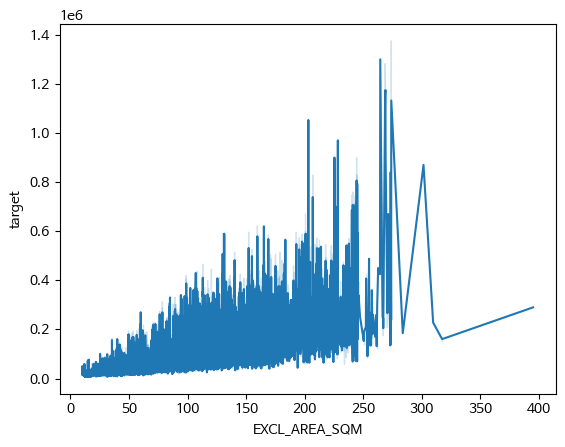

In [198]:
sns.lineplot(data = train1, x = 'EXCL_AREA_SQM', y = 'target')

### 4-3-8. 대통령 임기

##### 대통령 선거시, 여당의 경우 아파트 가격 평균이 높음을 확인할 수 있음.  

In [210]:
train1[train1['VOTERATE']>0]['target'].mean()

80622.28516382679

In [211]:
train1[train1['VOTERATE']<0]['target'].mean()

51821.563270349274

### 4-3-9. BUILD_YEAR

<Axes: xlabel='BUILD_YEAR', ylabel='target'>

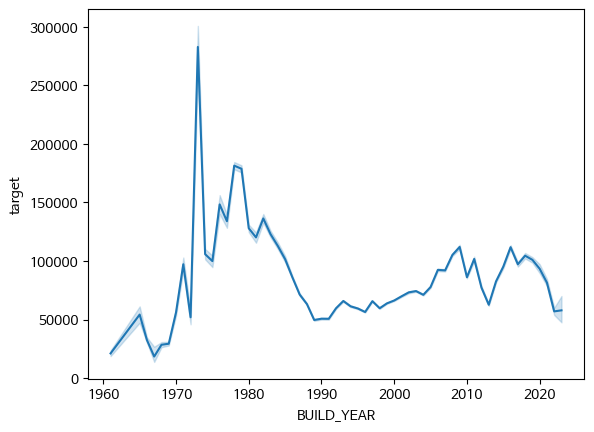

In [184]:
sns.lineplot(data = train1, x = 'BUILD_YEAR', y = 'target')

In [194]:
train1.groupby('BUILD_YEAR')['target'].mean().idxmax()
train1.groupby('BUILD_YEAR')['target'].mean().max()


1973

In [196]:
train1[train1['BUILD_YEAR']==1973]['APT_NM'].unique()

array(['광산', '반포주공1단지', '주미', '타워맨션', '뉴후암', '역촌맨션', '동대문맨션', '사직파크맨션',
       '남산힐레지던스'], dtype=object)

In [197]:
build_year = ['광산', '반포주공1단지', '주미', '타워맨션', '뉴후암', '역촌맨션', '동대문맨션', '사직파크맨션',
       '남산힐레지던스']
for i in build_year:
    a = train1[train1['APT_NM']==i]['target'].mean()
    print(f'{i}의 평균 :{a}')

광산의 평균 :26500.387096774193
반포주공1단지의 평균 :394823.8125
주미의 평균 :135486.36363636365
타워맨션의 평균 :159050.0
뉴후암의 평균 :39954.545454545456
역촌맨션의 평균 :26073.48076923077
동대문맨션의 평균 :38182.35294117647
사직파크맨션의 평균 :54000.0
남산힐레지던스의 평균 :258500.0


### 4-3-10. 계약년월에 따른 아파트 가격 변화

<Axes: xlabel='CONTR_YEAR_MONTH', ylabel='target'>

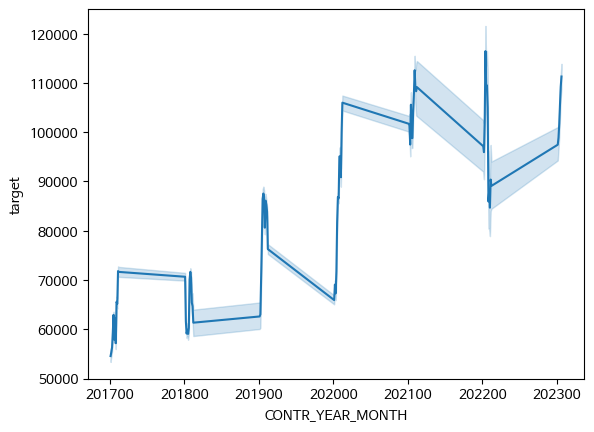

In [183]:
sns.lineplot(data = train1, x = 'CONTR_YEAR_MONTH', y = 'target')

### 4-3-11. FLOOR

In [213]:
train1[train1['FLOOR']>1]['target'].mean()

78651.09258143796

In [214]:
train1[train1['FLOOR']==1]['target'].mean()

72389.71764913364

<Axes: xlabel='FLOOR', ylabel='target'>

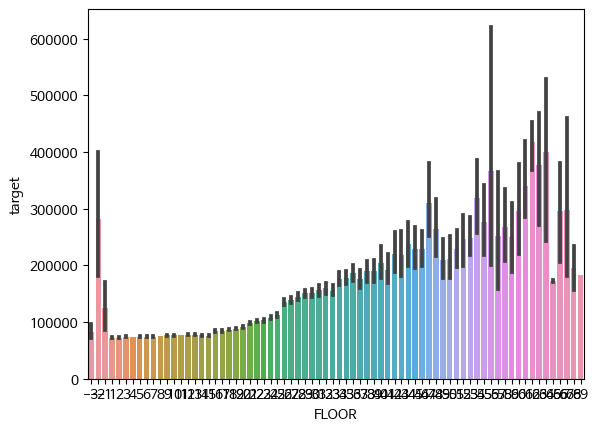

In [216]:
sns.barplot(data = train1, x = 'FLOOR', y = 'target')

### 4-3-12. DONG APT_NM 에 따른 카테고리 생성

In [68]:
train1 = train1.drop(columns='DONGAPT_NM')

In [69]:
train1['DONGAPT_NM'] = train1['DONG'] + ' ' + train1['APT_NM']

In [ ]:
# 'APT_NM' 별 'target'의 평균 계산
avg_target_by_apt = train1.groupby('APT_NM')['target'].mean()

# 평균이 400000을 초과하는 'APT_NM'에 대한 조건 필터링
selected_apt_names = avg_target_by_apt[avg_target_by_apt > 400000].index

# 선택된 'APT_NM'들에 해당하는 행들만 필터링
train1[train1['APT_NM'].isin(selected_apt_names)]
selected_rows

In [22]:
(train1.groupby('DONGAPT_NM')['target'].mean()).shape[0]

6318

In [106]:
(train1.groupby('DONGAPT_NM')['target'].mean()<25000).sum()

681

In [128]:
targets = [25000,32500,37500,42500,47500,52500,57500,65000,75000,90000,125000,200000,400000]

# 새로운 feature '아파트명 평균가' 생성
train1['APT_AVG'] = 0

for i in range(len(targets)):
    # 'APT_NM' 별 'target'의 평균 계산
    avg_target_by_apt = train1.groupby('APT_NM')['target'].mean()

    # 평균이 400000을 초과하는 'APT_NM'에 대한 조건 필터링
    selected_apt_names = avg_target_by_apt[avg_target_by_apt > targets[i]].index
    
    # 조건을 만족하는 행들에 대해 '아파트명 평균가'에 8이라는 값을 할당
    train1.loc[train1['APT_NM'].isin(selected_apt_names), 'APT_AVG'] = i

    

In [130]:
train1['APT_AVG'].unique()

array([10, 11,  2,  9,  4,  5,  6,  8,  3,  7,  1, 12,  0])

In [111]:
((train1.groupby('DONGAPT_NM')['target'].mean()<32500)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=25000)).sum()

672

In [113]:
((train1.groupby('DONGAPT_NM')['target'].mean()<37500)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=32500)).sum()

626

In [114]:
((train1.groupby('DONGAPT_NM')['target'].mean()<42500)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=37500)).sum()

664

In [116]:
((train1.groupby('DONGAPT_NM')['target'].mean()<47500)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=42500)).sum()

646

In [117]:
((train1.groupby('DONGAPT_NM')['target'].mean()<52500)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=47500)).sum()

599

In [122]:
((train1.groupby('DONGAPT_NM')['target'].mean()<57500)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=52500)).sum()

529

In [124]:
((train1.groupby('DONGAPT_NM')['target'].mean()<65000)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=57500)).sum()

641

In [126]:
((train1.groupby('DONGAPT_NM')['target'].mean()<75000)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=65000)).sum()

568

In [127]:
((train1.groupby('DONGAPT_NM')['target'].mean()<90000)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=75000)).sum()

601

In [103]:
((train1.groupby('DONGAPT_NM')['target'].mean()<125000)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=90000)).sum()

764

In [95]:
((train1.groupby('DONGAPT_NM')['target'].mean()<200000)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=125000)).sum()

648

In [76]:
((train1.groupby('DONGAPT_NM')['target'].mean()<400000)&
(train1.groupby('DONGAPT_NM')['target'].mean()>=200000)).sum()

259

In [77]:
(train1.groupby('DONGAPT_NM')['target'].mean()>400000).sum()

30

In [149]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9272 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ADRES                   9272 non-null   object 
 1   LOT_NO                  9272 non-null   object 
 2   APT_NM                  9262 non-null   object 
 3   EXCL_AREA_SQM           9272 non-null   float64
 4   CONTR_YEAR_MONTH        9272 non-null   int64  
 5   CONTR_DAY               9272 non-null   int64  
 6   FLOOR                   9272 non-null   int64  
 7   BUILD_YEAR              9272 non-null   int64  
 8   ADRES_DORO              9272 non-null   object 
 9   CANCEL_REASON_DATE      9272 non-null   int64  
 10  TRADE_TYPE              9272 non-null   object 
 11  AGNCY_LOCATION          9272 non-null   object 
 12  CODEAPTNM               2690 non-null   object 
 13  HSHLDR_TY               2710 non-null   object 
 14  CRRDPR_TY               2708 non-null   

In [152]:
test[test['APT_AVG'].isna()]['DONGAPT_NM'].unique()

array(['삼성동 한양립스', '신사동 우찬', '역삼동 역삼센트럴2차아이파크', '천호동 힐데스하임천호',
       '번동 아츠스테이수유점', '수유동 수유시그니티', '등촌동 강서', '자양동 그랜드', '고척동 더헤리츠', nan,
       '답십리동 현대썬앤빌청계', '장안동 우정B', '흑석동 흑석리버파크자이', '신수동 신수동르끌레브',
       '방배동 하늘바람', '잠원동 르엘신반포파크애비뉴', '송정동 히페리온리버팰리스', '신월동 대영월드',
       '인현동2가 세운푸르지오헤리시티', '입정동 힐스테이트세운센트럴1단지'], dtype=object)

In [172]:
test[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='입정동 힐스테이트세운센트럴1단지')]

ADRES LOT_NO         APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
9050  서울특별시 중구 입정동    277  힐스테이트세운센트럴1단지           7.00            202307   

      CONTR_DAY  FLOOR  BUILD_YEAR ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE  \
9050         25     17        2023  을지로15길 31                   0       중개거래   

     AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  \
9050         서울 용산구       NaN       NaN       NaN       NaN          NaN   

      ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
9050           NaN   NaN   NaN    NaN       NaN           NaN           NaN   

      KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
9050            NaN            NaN                    NaN    NaN     NaN   

     GUBUN USE_RQSTDT  GU DONG        FULL_ADRES  FLOATING_POPULATION  \
9050   NaN        NaN  중구  입정동  서울특별시 중구 입정동 277               747108   

      SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  X_CODE  Y_CODE  \
9050        80.25           1           0     76.91  126.99   37.57   

      BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  REAL_GDP NOMINAL_GDP  \
9050      2995.19       55.35  20230725           3.50      1.40  563,921.50   

      SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE         DONGAPT_NM  \
9050                5          0      19.17     50.97  입정동 힐스테이트세운센트럴1단지   

      APT_AVG  
9050      NaN

In [180]:
test[(test['APT_AVG'].isna())&(test['DONGAPT_NM'].isna())]

ADRES   LOT_NO APT_NM  EXCL_AREA_SQM  CONTR_YEAR_MONTH  \
2451   서울특별시 구로구 구로동    740-7    NaN          10.00            202308   
2452   서울특별시 구로구 구로동   743-27    NaN          18.00            202309   
2453   서울특별시 구로구 구로동   747-34    NaN          14.00            202308   
2454   서울특별시 구로구 구로동   752-17    NaN          10.00            202307   
2455   서울특별시 구로구 구로동   780-86    NaN          10.00            202307   
4035  서울특별시 동대문구 장안동   404-13    NaN          25.00            202308   
4449   서울특별시 동작구 상도동    323-4    NaN          32.00            202307   
8041  서울특별시 영등포구 대림동   1101-1    NaN           4.00            202307   
8042  서울특별시 영등포구 대림동   1101-1    NaN           4.00            202307   
8966    서울특별시 중구 신당동  432-904    NaN          17.00            202309   

      CONTR_DAY  FLOOR  BUILD_YEAR    ADRES_DORO  CANCEL_REASON_DATE  \
2451         21      4        1996    구로동로12길 49                   0   
2452          8      1        1994  구로동로22길 52-2                   0   
2453          4      2        2000    도림로3길 35-5                   0   
2454          3      3        1994  구로동로22길 76-6                   0   
2455          5      5        1961     도림로12길 11                   0   
4035         18      7        2005    천호대로77길 62                   0   
4449          5      3        2005      국사봉1길 18                   0   
8041          8      6        2012    도림천로19길 12                   0   
8042         21     10        2012    도림천로19길 12                   0   
8966         13      4        2001  동호로11마길 20-8                   0   

     TRADE_TYPE AGNCY_LOCATION CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  \
2451       중개거래         서울 구로구       NaN       NaN       NaN       NaN   
2452       중개거래         서울 구로구       NaN       NaN       NaN       NaN   
2453        직거래              -       NaN       NaN       NaN       NaN   
2454       중개거래         서울 구로구       NaN       NaN       NaN       NaN   
2455        직거래              -       NaN       NaN       NaN       NaN   
4035        직거래              -       NaN       NaN       NaN       NaN   
4449       중개거래         서울 동작구       NaN       NaN       NaN       NaN   
8041       중개거래        서울 영등포구       NaN       NaN       NaN       NaN   
8042       중개거래        서울 영등포구       NaN       NaN       NaN       NaN   
8966       중개거래          서울 중구       NaN       NaN       NaN       NaN   

      ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  \
2451          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
2452          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
2453          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
2454          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
2455          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
4035          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
4449          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
8041          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
8042          NaN           NaN   NaN   NaN    NaN       NaN           NaN   
8966          NaN           NaN   NaN   NaN    NaN       NaN           NaN   

      KAPTMPAREA85  KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  \
2451           NaN            NaN            NaN                    NaN   
2452           NaN            NaN            NaN                    NaN   
2453           NaN            NaN            NaN                    NaN   
2454           NaN            NaN            NaN                    NaN   
2455           NaN            NaN            NaN                    NaN   
4035           NaN            NaN            NaN                    NaN   
4449           NaN            NaN            NaN                    NaN   
8041           NaN            NaN            NaN                    NaN   
8042           NaN            NaN            NaN                    N

In [179]:
test[(test['APT_AVG'].isna())&(test['DONGAPT_NM'].isna())]["FULL_ADRES"].unique()

array(['서울특별시 구로구 구로동 740-7', '서울특별시 구로구 구로동 743-27',
       '서울특별시 구로구 구로동 747-34', '서울특별시 구로구 구로동 752-17',
       '서울특별시 구로구 구로동 780-86', '서울특별시 동대문구 장안동 404-13',
       '서울특별시 동작구 상도동 323-4', '서울특별시 영등포구 대림동 1101-1',
       '서울특별시 중구 신당동 432-904'], dtype=object)

In [178]:
test[(test['APT_AVG'].isna())&(test['DONGAPT_NM'].isna())]["ADRES_DORO"].unique()

array(['구로동로12길 49', '구로동로22길 52-2', '도림로3길 35-5', '구로동로22길 76-6',
       '도림로12길 11', '천호대로77길 62', '국사봉1길 18', '도림천로19길 12',
       '동호로11마길 20-8'], dtype=object)

In [181]:
# KB 부동산 기준으로 채움. 
# EXCL_AREA_SQM 1개 / 2023 신식 주상복합 / AVG 71700 / 판매액 74300 
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='삼성동 한양립스'), 'APT_AVG'] = 8 
# EXCL_AREA_SQM 59.78(18) / AVG 64000 / 판매액 64000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='신사동 우찬'), 'APT_AVG'] = 7
# EXCL_AREA_SQM 19.68(5) / AVG 52500 / 판매액 52500
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='역삼동 역삼센트럴2차아이파크'), 'APT_AVG'] = 6
# EXCL_AREA_SQM 84.96(25),84.99(25) / AVG 88000 / 판매액 90000,92000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='천호동 힐데스하임천호'), 'APT_AVG'] = 10
# https://www.koreacharts.com/apartment/trade/156600/202310.html
# EXCL_AREA_SQM 2개 / 사회적 임대 / AVG 16800 / 판매액 max 18400, min 16000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='번동 아츠스테이수유점'), 'APT_AVG'] = 0 
# EXCL_AREA_SQM 48.59(14) / AVG 57000 / 판매액 57000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='수유동 수유시그니티'), 'APT_AVG'] = 6
# EXCL_AREA_SQM 108(23) / AVG 55000 / 판매액 55000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='등촌동 강서'), 'APT_AVG'] = 6
# EXCL_AREA_SQM 41(14) / AVG 45000 / 판매액 45000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='자양동 그랜드'), 'APT_AVG'] = 4
# EXCL_AREA_SQM 73(16) /  AVG 60000 / 판매액 60000 
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='고척동 더헤리츠'), 'APT_AVG'] = 7
# AVG 12350 / 판매액 12350
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='답십리동 현대썬앤빌청계'), 'APT_AVG'] = 0
# EXCL_AREA_SQM 19.68(5) / AVG 25500 / 판매액 25500
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='장안동 우정B'), 'APT_AVG'] = 1
# EXCL_AREA_SQM 84.96(25) / AVG 142666 / 판매액 130000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='흑석동 흑석리버파크자이'), 'APT_AVG'] = 8
# EXCL_AREA_SQM 15 / AVG 75000 / 판매액 75000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='신수동 신수동르끌레브'), 'APT_AVG'] = 8
# EXCL_AREA_SQM (83) / AVG 274800 / 판매액 274800
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='방배동 하늘바람'), 'APT_AVG'] = 11
# EXCL_AREA_SQM (18) / AVG 229000 / 판매액 229000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='잠원동 르엘신반포파크애비뉴'), 'APT_AVG'] = 11
# EXCL_AREA_SQM (25)) / AVG 84000 / 판매액 84000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='송정동 히페리온리버팰리스'), 'APT_AVG'] = 9
# EXCL_AREA_SQM (83) / AVG 40000 / 판매액 40000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='신월동 대영월드'), 'APT_AVG'] = 3
# EXCL_AREA_SQM 8,7 / AVG 36850 / 판매액 38700,35000
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='인현동2가 세운푸르지오헤리시티'), 'APT_AVG'] = 2
# EXCL_AREA_SQM (25)) / AVG 44900 / 판매액 44900
test.loc[(test['APT_AVG'].isna())&(test['DONGAPT_NM']=='입정동 힐스테이트세운센트럴1단지'), 'APT_AVG'] = 4

# EXCL_AREA_SQM (25)) / AVG 14550 / 서울특별시 구로구 구로동 740-7 / 구로동로12길 49
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='740-7'), 'APT_AVG'] = 0
# EXCL_AREA_SQM (25)) / AVG 20850 / 서울특별시 구로구 구로동 743-27 / 구로동로22길 52-2
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='743-27'), 'APT_AVG'] = 0
# EXCL_AREA_SQM (25)) / AVG 근처 평균 25000 언더 / 서울특별시 구로구 구로동 747-34 / 도림로3길 35-5
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='747-34'), 'APT_AVG'] = 0
# EXCL_AREA_SQM (25)) / AVG 26000 / 서울특별시 구로구 구로동 752-17 / 구로동로22길 76-6
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='752-17'), 'APT_AVG'] = 1
# EXCL_AREA_SQM (25)) / AVG 21600 / 서울특별시 구로구 구로동 780-86 / 도림로12길 11
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='780-86'), 'APT_AVG'] = 0
# EXCL_AREA_SQM (25)) / AVG 37000 / INSE 세터 아파트 / 서울특별시 동대문구 장안동 404-13 / 천호대로77길 62
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='404-13'), 'APT_AVG'] = 2
# EXCL_AREA_SQM (25)) / AVG 25000 언더로 잡음 / 상가 ... / 서울특별시 동작구 상도동 323-4 / 국사봉1길 18
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='323-4'), 'APT_AVG'] = 0
# EXCL_AREA_SQM (25)) / AVG 11000 / 서울특별시 영등포구 대림동 1101-1 / 도림천로19길 12
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='1101-1'), 'APT_AVG'] = 0
# EXCL_AREA_SQM (25)) / AVG 근처 매매 25000 언더 / 서울특별시 중구 신당동 432-904 / 동호로11마길 20-8
test.loc[(test['APT_AVG'].isna())&(test['LOT_NO']=='432-904'), 'APT_AVG'] = 0



### 4-3-12. SPACEAPT_AVG 동 아파트명 + 평수 에 따른 아파트 평균가 카테고리 생성

In [744]:
train1['EXCL_AREA_SQM'] = train1['EXCL_AREA_SQM'].astype('str')
test1['EXCL_AREA_SQM'] = test1['EXCL_AREA_SQM'].astype('str')

In [745]:
train1['DONGAPTNM_SPACE'] = train1['DONGAPT_NM'] + ' ' + train1['EXCL_AREA_SQM']
test1['DONGAPTNM_SPACE'] = test1['DONGAPT_NM'] + ' ' + test1['EXCL_AREA_SQM']

In [331]:
train1.groupby('DONGAPTNM_SPACE')['target'].mean()

DONGAPTNM_SPACE
가락동 e지브로 25.0           56300.00
가락동 e지브로 43.0           67666.67
가락동 sk파크타워 25.0         74465.62
가락동 sk파크타워 32.0         79805.00
가락동 가락3차쌍용스윗닷홈 25.0     73789.42
                          ...   
흥인동 청계천두산위브더제니스 43.0   118000.00
흥인동 청계천두산위브더제니스 44.0   126968.42
흥인동 청계천두산위브더제니스 52.0   163127.80
흥인동 청계천두산위브더제니스 53.0   160000.00
흥인동 청계천두산위브더제니스 58.0   180000.00
Name: target, Length: 20377, dtype: float64

In [333]:
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()<15000).sum()

343

In [337]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<19000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=15000)).sum()

378

In [342]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<21500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=19000)).sum()

325

In [345]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<24000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=21500)).sum()

378

In [435]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<26000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=24000)).sum()

372

In [437]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<27500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=26000)).sum()

316

In [441]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<28750)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=27500)).sum()

330

In [442]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<30000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=28750)).sum()

304

In [444]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<31500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=30000)).sum()

386

In [445]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<33000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=31500)).sum()

391

In [447]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<34250)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=33000)).sum()

358

In [449]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<35500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=34250)).sum()

371

In [452]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<36750)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=35500)).sum()

362

In [454]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<37750)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=36750)).sum()

304

In [457]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<39000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=37750)).sum()

375

In [460]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<40000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=39000)).sum()

320

In [462]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<41000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=40000)).sum()

339

In [464]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<42250)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=41000)).sum()

379

In [467]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<43500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=42250)).sum()

336

In [469]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<44500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=43500)).sum()

315

In [471]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<45500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=44500)).sum()

329

In [474]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<46750)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=45500)).sum()

355

In [476]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<48000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=46750)).sum()

334

In [480]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<49250)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=48000)).sum()

369

In [481]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<50250)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=49250)).sum()

349

In [484]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<51500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=50250)).sum()

313

In [486]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<53000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=51500)).sum()

369

In [487]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<54500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=53000)).sum()

351

In [488]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<56000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=54500)).sum()

393

In [490]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<57500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=56000)).sum()

311

In [493]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<59000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=57500)).sum()

339

In [496]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<60250)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=59000)).sum()

370

In [498]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<62000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=60250)).sum()

350

In [502]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<64000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=62000)).sum()

368

In [504]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<66000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=64000)).sum()

388

In [507]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<68000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=66000)).sum()

328

In [509]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<70250)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=68000)).sum()

363

In [511]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<72500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=70250)).sum()

348

In [512]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<75000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=72500)).sum()

325

In [514]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<77500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=75000)).sum()

355

In [516]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<80000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=77500)).sum()

311

In [518]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<83000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=80000)).sum()

328

In [521]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<87000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=83000)).sum()

390

In [524]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<91000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=87000)).sum()

357

In [526]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<95000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=91000)).sum()

304

In [530]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<99500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=95000)).sum()

316

In [535]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<105000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=99500)).sum()

339

In [537]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<111000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=105000)).sum()

369

In [539]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<117500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=111000)).sum()

333

In [540]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<125000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=117500)).sum()

333

In [543]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<132000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=125000)).sum()

318

In [552]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<140000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=132000)).sum()

307

In [554]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<150000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=140000)).sum()

344

In [557]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<162500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=150000)).sum()

339

In [560]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<177500)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=162500)).sum()

340

In [562]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<190000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=177500)).sum()

221

In [563]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<200000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=190000)).sum()

145

In [564]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<220000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=200000)).sum()

200

In [566]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<240000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=220000)).sum()

167

In [567]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<260000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=240000)).sum()

139

In [568]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<280000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=260000)).sum()

93

In [569]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<300000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=280000)).sum()

81

In [570]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<320000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=300000)).sum()

62

In [571]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<340000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=320000)).sum()

42

In [573]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<360000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=340000)).sum()

40

In [574]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<380000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=360000)).sum()

36

In [575]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<400000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=380000)).sum()

22

In [596]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<425000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=400000)).sum()

24

In [577]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<500000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=450000)).sum()

24

In [578]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<550000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=500000)).sum()

16

In [579]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<600000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=550000)).sum()

12

In [588]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<700000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=600000)).sum()

6

In [589]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<800000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=700000)).sum()

3

In [590]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<900000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=800000)).sum()

4

In [591]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<1000000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=900000)).sum()

2

In [592]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<1100000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=1000000)).sum()

1

In [593]:
((train1.groupby('DONGAPTNM_SPACE')['target'].mean()<1200000)&
(train1.groupby('DONGAPTNM_SPACE')['target'].mean()>=1100000)).sum()

2

In [746]:
train1['DONGAPTNM_SPACE'] = train1['DONGAPT_NM'] + ' ' + train1['EXCL_AREA_SQM']
test1['DONGAPTNM_SPACE'] = test1['DONGAPT_NM'] + ' ' + test1['EXCL_AREA_SQM']

In [751]:
targets = [15000,19000,21500,24000,26000,
            27500,28750,30000,31500,33000,
            34250,35500,36750,37750,39000,
            40000,41000,42250,43500,44500,
            45500,46750,48000,49250,50250,
            51500,53000,54500,56000,57500,
            59000,60250,62000,64000,66000,
            68000,70250,72500,75000,77500,
            80000,83000,87000,91000,95000,
            99500,105000,111000,117500,125000,
            132000,140000,150000,162500,177500,
            190000,200000,220000,240000,260000,
            280000,300000,320000,340000,360000,
            380000,400000,425000,450000,500000,
            550000,600000,700000,800000,900000,
            1000000,1100000,1200000
            ]

# 새로운 feature '아파트명 평균가' 생성
train1['SPACEAPT_AVG'] = 0

for i in range(len(targets)):
    # 'APT_NM' 별 'target'의 평균 계산
    avg_target_by_apt = train1.groupby('DONGAPTNM_SPACE')['target'].mean()

    # 평균이 400000을 초과하는 'APT_NM'에 대한 조건 필터링
    selected_apt_names = avg_target_by_apt[avg_target_by_apt > targets[i]].index
    
    # 조건을 만족하는 행들에 대해 '아파트명 평균가'에 8이라는 값을 할당
    train1.loc[train1['DONGAPTNM_SPACE'].isin(selected_apt_names), 'SPACEAPT_AVG'] = i
data = train1[['SPACEAPT_AVG','DONGAPTNM_SPACE']].drop_duplicates()
test1 = pd.merge(test1,data,how='left',on='DONGAPTNM_SPACE')

In [752]:
# assuming 'target' is the column you want to filter on
result = train1.groupby('DONGAPTNM_SPACE')['target'].mean() >= 1200000
filtered_rows = train1[train1['DONGAPTNM_SPACE'].isin(result[result].index)]
filtered_rows

ADRES   LOT_NO     APT_NM EXCL_AREA_SQM  CONTR_DAY  FLOOR  \
233420  서울특별시 성동구 성수동1가  685-700  아크로서울포레스트          80.0         30     47   

        BUILD_YEAR  ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE AGNCY_LOCATION  \
233420        2020  왕십리로 83-21                   0       중개거래         서울 성동구   

       CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  ALL_HSHLD_CO  \
233420       NaN       NaN       NaN       NaN          NaN           NaN   

       CO_WO CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  \
233420   NaN   NaN    NaN       NaN           NaN           NaN   

        KAPTMPAREA135  KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA  \
233420            NaN            NaN                    NaN    NaN     NaN   

       GUBUN USE_RQSTDT   target   GU DONG               FULL_ADRES  \
233420   NaN        NaN  1300000  성동구  성수동  서울특별시 성동구 성수동1가 685-700   

        FLOATING_POPULATION  SUBWAY_DIST  1STSUBAREA  2NDSUBAREA  BUS_DIST  \
233420                44506       537.66           0           0      9.25   

        X_CODE  Y_CODE  BRIDGE_DIST  LEASE_RATE     CONTR  INTEREST_RATE  \
233420  127.04   37.54       927.99       53.33  20220930           0.75   

        REAL_GDP NOMINAL_GDP  SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  \
233420      3.20  548,892.50               10          0      25.67     53.21   

        CONTR_YEAR  CONTR_MONTH       DONGAPT_NM       DONGAPTNM_SPACE  \
233420        2022            9  성수동1가 아크로서울포레스트  성수동1가 아크로서울포레스트 80.0   

        SPACEAPT_AVG  DONG_RANK  
233420            77      36.00

In [622]:
# pd.set_option('display.max_rows', None)

# # Create a DataFrame with 'target' and 'number' columns
# targets = [15000, 19000, 21500, 24000, 26000, 27500, 28750, 30000, 31500, 33000,
#            34250, 35500, 36750, 37750, 39000, 40000, 41000, 42250, 43500, 44500,
#            45500, 46750, 48000, 49250, 50250, 51500, 53000, 54500, 56000, 57500,
#            59000, 60250, 62000, 64000, 66000, 68000, 70250, 72500, 75000, 77500,
#            80000, 83000, 87000, 91000, 95000, 99500, 105000, 111000, 117500, 125000,
#            132000, 140000, 150000, 162500, 177500, 190000, 200000, 220000, 240000, 260000,
#            280000, 300000, 320000, 340000, 360000, 380000, 400000, 425000, 450000, 500000,
#            550000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000]

# df = pd.DataFrame({'target': targets, 'number': range(len(targets))})
# display(df)

In [753]:
test1[test1['SPACEAPT_AVG'].isna()]['DONGAPTNM_SPACE'].unique()

array(['대치동 대치타워 26.0', '고덕동 고덕센트럴푸르지오 12.0', '삼성동 한양립스 11.0',
       '신사동 우찬 18.0', '압구정동 한양6 33.0', '역삼동 역삼센트럴2차아이파크 5.0',
       '상일동 고덕자이 16.0', '성내동 다성이즈빌 15.0', '성내동 라움 13.0', '성내동 비앤비 22.0',
       '천호동 힐데스하임천호 25.0', '미아동 꿈의숲한신더휴 25.0', '번동 아츠스테이수유점 5.0',
       '번동 아츠스테이수유점 4.0', '수유동 수유시그니티 14.0', '수유동 칸타빌수유팰리스 8.0',
       '내발산동 강성레스빌 18.0', '내발산동 내츄럴4차 16.0', '등촌동 강서 23.0',
       '화곡동 화곡한강 20.0', '남현동 네스코수피아 14.0', '신림동 삼성아트빌 19.0',
       '구의동 강변 14.0', '구의동 광남캐스빌 18.0', '자양동 그랜드 14.0',
       '공릉동 태릉해링턴플레이스 15.0', '고척동 더헤리츠 16.0', '구로동 함양주택 13.0', nan,
       '구로동 성삼하이츠 9.0', '공릉동 서경하누리 18.0', '공릉동 테라파크뷰 16.0',
       '답십리동 현대썬앤빌청계 7.0', '장안동 우정B 15.0', '휘경동 휘경SK뷰 28.0',
       '흑석동 흑석리버파크자이 25.0', '망원동 마포월드컵제이스카이 18.0', '신수동 신수동르끌레브 15.0',
       '방배동 방배그랑자이 40.0', '일원동 디에이치포레센트 18.0', '창천동 노블레스 17.0',
       '홍은동 도양라비앙 30.0', '홍은동 서강2차 45.0', '홍제동 제일 17.0',
       '반포동 래미안원베일리 30.0', '반포동 상지리츠빌2차 45.0', '방배동 모닝아트빌 25.0',
       '방배동 방배 서리풀 그랑블 11.0', '방배동 방배삼성홈타운 32.0'

In [766]:
# KB 부동산 기준으로 채움. 
# 판매액 245000 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='개포동 개포더샵트리에 32.0'), 'SPACEAPT_AVG'] = 59
# 판매액 105000 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='대치동 대치타워 25.0'), 'SPACEAPT_AVG'] = 47
# 판매액 65000 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='고덕동 고덕센트럴푸르지오 12.0'), 'SPACEAPT_AVG'] = 34
# 판매액 74300 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='삼성동 한양립스 11.0'), 'SPACEAPT_AVG'] = 38
# 판매액 64000 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신사동 우찬 17.0'), 'SPACEAPT_AVG'] = 34
# 판매액 371000 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='압구정동 한양6 33.0'), 'SPACEAPT_AVG'] = 65
# 판매액 52500 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='역삼동 역삼센트럴2차아이파크 5.0'), 'SPACEAPT_AVG'] = 26
# 판매액 67500 
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='둔촌동 아인리베 24.0'), 'SPACEAPT_AVG'] = 35
# 판매액 91000 ,96000 / AVG 93500
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='상일동 고덕자이 15.0'), 'SPACEAPT_AVG'] = 44
# 판매액 62000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='성내동 다성이즈빌 15.0'), 'SPACEAPT_AVG'] = 33
# 판매액 39800
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='성내동 라움 13.0'), 'SPACEAPT_AVG'] = 14
# 판매액 63000, 63000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='성내동 비앤비 22.0'), 'SPACEAPT_AVG'] = 33
# 판매액 90000,92000 / AVG 91000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='천호동 힐데스하임천호 25.0'), 'SPACEAPT_AVG'] = 44
# 판매액 88000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='미아동 꿈의숲한신더휴 25.0'), 'SPACEAPT_AVG'] = 43
# 판매액 18000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='번동 아츠스테이수유점 4.0'), 'SPACEAPT_AVG'] = 1
# 판매액 18000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='번동 아츠스테이수유점 5.0'), 'SPACEAPT_AVG'] = 1
# 판매액 57000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='수유동 수유시그니티 14.0'), 'SPACEAPT_AVG'] = 29
# 판매액 32000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='내발산동 내츄럴4차 16.0'), 'SPACEAPT_AVG'] = 9
# 판매액 55000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='등촌동 강서 23.0'), 'SPACEAPT_AVG'] = 28
# 판매액 31000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='화곡동 화곡한강 20.0'), 'SPACEAPT_AVG'] = 8
# 판매액 60000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='남현동 네스코수피아 14.0'), 'SPACEAPT_AVG'] = 31
# 판매액 64000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='봉천동 에메랄드102동 25.0'), 'SPACEAPT_AVG'] = 34
# 판매액 36000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신림동 삼성아트빌 19.0'), 'SPACEAPT_AVG'] = 12
# 판매액 30000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='구의동 강변 14.0'), 'SPACEAPT_AVG'] = 8
# 판매액 42500
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='구의동 광남캐스빌 17.0'), 'SPACEAPT_AVG'] = 18
# 판매액 45000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='자양동 그랜드 14.0'), 'SPACEAPT_AVG'] = 20
# 판매액 62700
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='공릉동 태릉해링턴플레이스 14.0'), 'SPACEAPT_AVG'] = 35
# 판매액 60000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='고척동 더헤리츠 16.0'), 'SPACEAPT_AVG'] = 31
# 판매액 23000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='구로동 함양주택 13.0'), 'SPACEAPT_AVG'] = 3
# 판매액 24000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='구로동 성삼하이츠 9.0'), 'SPACEAPT_AVG'] = 4
# 판매액 44000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='공릉동 서경하누리 18.0'), 'SPACEAPT_AVG'] = 19
# 판매액 60000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='공릉동 테라파크뷰 16.0'), 'SPACEAPT_AVG'] = 31
# 판매액 24000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='답십리동 현대썬앤빌청계 6.0'), 'SPACEAPT_AVG'] = 4
# 판매액 26000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='장안동 우정B 15.0'), 'SPACEAPT_AVG'] = 5
# 판매액 124000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='휘경동 휘경SK뷰 28.0'), 'SPACEAPT_AVG'] = 49
# 판매액 160000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='흑석동 흑석리버파크자이 25.0'), 'SPACEAPT_AVG'] = 53
# 판매액 58000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='망원동 마포월드컵제이스카이 17.0'), 'SPACEAPT_AVG'] = 30
# 판매액 75000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신수동 신수동르끌레브 14.0'), 'SPACEAPT_AVG'] = 39
# 판매액 108000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='북아현동 힐스테이트신촌 16.0'), 'SPACEAPT_AVG'] = 47
# 판매액 433000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='방배동 방배그랑자이 40.0'), 'SPACEAPT_AVG'] = 68
# 판매액 194000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='일원동 디에이치포레센트 17.0'), 'SPACEAPT_AVG'] = 56
# 판매액 43000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='창천동 노블레스 17.0'), 'SPACEAPT_AVG'] = 18
# 판매액 53000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='홍은동 도양라비앙 30.0'), 'SPACEAPT_AVG'] = 27
# 판매액 56000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='홍은동 서강2차 45.0'), 'SPACEAPT_AVG'] = 29
# 판매액 46000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='홍제동 제일 17.0'), 'SPACEAPT_AVG'] = 21
# 판매액 470000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='반포동 래미안원베일리 30.0'), 'SPACEAPT_AVG'] = 69
# 판매액 187000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='반포동 상지리츠빌2차 45.0'), 'SPACEAPT_AVG'] = 55
# 판매액 167000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='방배동 모닝아트빌 25.0'), 'SPACEAPT_AVG'] = 54
# 판매액 85000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='방배동 방배 서리풀 그랑블 11.0'), 'SPACEAPT_AVG'] = 42
# 판매액 80000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='방배동 방배삼성홈타운 31.0'), 'SPACEAPT_AVG'] = 41
# 판매액 274800
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='방배동 하늘바람 73.0'), 'SPACEAPT_AVG'] = 60
# 판매액 242000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='서초동 레미안서초6차 51.0'), 'SPACEAPT_AVG'] = 59
# 판매액 117500
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='서초동 티에스프리우스 23.0'), 'SPACEAPT_AVG'] = 49
# 판매액 229000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='잠원동 르엘신반포파크애비뉴 17.0'), 'SPACEAPT_AVG'] = 58
# 판매액 375000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='성수동1가 아크로서울포레스트 28.0'), 'SPACEAPT_AVG'] = 65
# 판매액 83000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='송정동 히페리온리버팰리스 25.0'), 'SPACEAPT_AVG'] = 42
# 판매액 45000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='석촌동 베스트휴 17.0'), 'SPACEAPT_AVG'] = 20
# 판매액 58700
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='오금동 에스아이팰리스송파올림픽공원 8.0'), 'SPACEAPT_AVG'] = 30
# 판매액 104000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='당산동5가 당산센트럴아이파크 13.0'), 'SPACEAPT_AVG'] = 46
# 판매액 40000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신월동 대영월드 25.0'), 'SPACEAPT_AVG'] = 16
# 판매액 69000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신길동 길성그랑프리텔 22.0'), 'SPACEAPT_AVG'] = 36
# 판매액 72300
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신길동 신풍두산위브 20.0'), 'SPACEAPT_AVG'] = 38
# 판매액 85000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='수색동 DMC롯데캐슬더퍼스트 30.0'), 'SPACEAPT_AVG'] = 42
# 판매액 30500
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='영등포동1가 여의도이튼브라운 9.0'), 'SPACEAPT_AVG'] = 8
# 판매액 240000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='이태원동 남산힐레지던스 61.0'), 'SPACEAPT_AVG'] = 59
# 판매액 173000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='한남동 대성이태리하우스 33.0'), 'SPACEAPT_AVG'] = 54
# 판매액 520000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='한남동 르가든더메인한남 71.0'), 'SPACEAPT_AVG'] = 70
# 판매액 110000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='효창동 효창아트빌2차 25.0'), 'SPACEAPT_AVG'] = 47
# 판매액 84000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='후암동 남산애지앙 27.0'), 'SPACEAPT_AVG'] = 42
# 판매액 38000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='갈현동 명성 24.0'), 'SPACEAPT_AVG'] = 14
# 판매액 41000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='갈현동 연서노벨 18.0'), 'SPACEAPT_AVG'] = 17
# 판매액 29520
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='갈현동 한아름 15.0'), 'SPACEAPT_AVG'] = 4
# 판매액 49000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='불광동 청송 31.0'), 'SPACEAPT_AVG'] = 23
# 판매액 49000, 48800 / AVG 48900
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신사동 거성리젠시 13.0'), 'SPACEAPT_AVG'] = 23
# 판매액 43000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='역촌동 역촌월드 19.0'), 'SPACEAPT_AVG'] = 18
# 판매액 85000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='신당동 신당KCC스위첸 13.0'), 'SPACEAPT_AVG'] = 42
# 판매액 38700
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='인현동2가 세운푸르지오헤리시티 8.0'), 'SPACEAPT_AVG'] = 14
# 판매액 40000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='인현동2가 세운푸르지오헤리시티 7.0'), 'SPACEAPT_AVG'] = 16
# 판매액 310000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='홍파동 경희궁자이 41.0'), 'SPACEAPT_AVG'] = 62
# 판매액 62000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='예장동 예장동삼익 18.0'), 'SPACEAPT_AVG'] = 33
# 판매액 44900
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='입정동 힐스테이트세운센트럴1단지 7.0'), 'SPACEAPT_AVG'] = 20
# 판매액 101000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='입정동 힐스테이트세운센트럴2단지 17.0'), 'SPACEAPT_AVG'] = 46
# 판매액 81000
test1.loc[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE']=='묵동 고덕골든빌 28.0'), 'SPACEAPT_AVG'] = 41

# 서울특별시 구로구 구로동 740-7 / 구로동로12길 49 / 18600
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='740-7'), 'SPACEAPT_AVG'] = 1
# 서울특별시 구로구 구로동 743-27 / 구로동로22길 52-2 / 21500
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='743-27'), 'SPACEAPT_AVG'] = 3
# 서울특별시 구로구 구로동 747-34 / 도림로3길 35-5 / 10800
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='747-34'), 'SPACEAPT_AVG'] = 0
# 서울특별시 구로구 구로동 752-17 / 구로동로22길 76-6 / 18800
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='752-17'), 'SPACEAPT_AVG'] = 1
# 서울특별시 구로구 구로동 780-86 / 도림로12길 11 / 15000
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='780-86'), 'SPACEAPT_AVG'] = 1
# 서울특별시 동대문구 장안동 404-13 / 천호대로77길 62 / 30700
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='404-13'), 'SPACEAPT_AVG'] = 8
# 서울특별시 동작구 상도동 323-4 / 국사봉1길 18 / 85000
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='323-4'), 'SPACEAPT_AVG'] = 42
# 서울특별시 영등포구 대림동 1101-1 / 도림천로19길 12 / 11000
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='1101-1'), 'SPACEAPT_AVG'] = 0
# 서울특별시 중구 신당동 432-904 / 동호로11마길 20-8 / 26500
test1.loc[(test['SPACEAPT_AVG'].isna())&(test1['LOT_NO']=='432-904'), 'SPACEAPT_AVG'] = 5


In [767]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9272 entries, 0 to 9271
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ADRES                   9272 non-null   object 
 1   LOT_NO                  9272 non-null   object 
 2   APT_NM                  9262 non-null   object 
 3   EXCL_AREA_SQM           9272 non-null   object 
 4   CONTR_DAY               9272 non-null   int64  
 5   FLOOR                   9272 non-null   int64  
 6   BUILD_YEAR              9272 non-null   int64  
 7   ADRES_DORO              9272 non-null   object 
 8   CANCEL_REASON_DATE      9272 non-null   int64  
 9   TRADE_TYPE              9272 non-null   object 
 10  AGNCY_LOCATION          9272 non-null   object 
 11  CODEAPTNM               2690 non-null   object 
 12  HSHLDR_TY               2710 non-null   object 
 13  CRRDPR_TY               2708 non-null   object 
 14  HEAT_MTHD               2710 non-null   

In [763]:
test1[(test1['SPACEAPT_AVG'].isna())&(test['LOT_NO']=='740-7')]

ADRES LOT_NO APT_NM EXCL_AREA_SQM  CONTR_DAY  FLOOR  BUILD_YEAR  \
2451  서울특별시 구로구 구로동  740-7    NaN          10.0         21      4        1996   

      ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE AGNCY_LOCATION CODEAPTNM  \
2451  구로동로12길 49                   0       중개거래         서울 구로구       NaN   

     HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  ALL_HSHLD_CO CO_WO CO_EX  \
2451       NaN       NaN       NaN          NaN           NaN   NaN   NaN   

      TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  KAPTMPAREA135  \
2451    NaN       NaN           NaN           NaN            NaN   

      KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA GUBUN USE_RQSTDT  \
2451            NaN                    NaN    NaN     NaN   NaN        NaN   

       GU DONG           FULL_ADRES  FLOATING_POPULATION  SUBWAY_DIST  \
2451  구로구  구로동  서울특별시 구로구 구로동 740-7               478846       633.04   

      1STSUBAREA  2NDSUBAREA  BUS_DIST  X_CODE  Y_CODE  BRIDGE_DIST  \
2451           0           0    100.79  126.88   37.49      3343.13   

      LEASE_RATE     CONTR  INTEREST_RATE  REAL_GDP NOMINAL_GDP  \
2451       55.24  20230821           2.25      1.40  563,921.50   

      SCHOOL_DISTRICT  REDEVELOP  CLASS_NUM  VOTERATE  CONTR_YEAR  \
2451                3          0      30.73    -47.01        2023   

      CONTR_MONTH DONGAPT_NM DONGAPTNM_SPACE  SPACEAPT_AVG_x  DONG_RANK  \
2451            8        NaN             NaN             NaN     226.00   

      SPACEAPT_AVG_y  SPACEAPT_AVG  
2451             NaN           NaN

In [755]:
test1[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE'].isna())]

ADRES   LOT_NO APT_NM EXCL_AREA_SQM  CONTR_DAY  FLOOR  \
2451   서울특별시 구로구 구로동    740-7    NaN          10.0         21      4   
2452   서울특별시 구로구 구로동   743-27    NaN          18.0          8      1   
2453   서울특별시 구로구 구로동   747-34    NaN          14.0          4      2   
2454   서울특별시 구로구 구로동   752-17    NaN          10.0          3      3   
2455   서울특별시 구로구 구로동   780-86    NaN          10.0          5      5   
4035  서울특별시 동대문구 장안동   404-13    NaN          25.0         18      7   
4449   서울특별시 동작구 상도동    323-4    NaN          32.0          5      3   
8041  서울특별시 영등포구 대림동   1101-1    NaN           4.0          8      6   
8042  서울특별시 영등포구 대림동   1101-1    NaN           4.0         21     10   
8966    서울특별시 중구 신당동  432-904    NaN          17.0         13      4   

      BUILD_YEAR    ADRES_DORO  CANCEL_REASON_DATE TRADE_TYPE AGNCY_LOCATION  \
2451        1996    구로동로12길 49                   0       중개거래         서울 구로구   
2452        1994  구로동로22길 52-2                   0       중개거래         서울 구로구   
2453        2000    도림로3길 35-5                   0        직거래              -   
2454        1994  구로동로22길 76-6                   0       중개거래         서울 구로구   
2455        1961     도림로12길 11                   0        직거래              -   
4035        2005    천호대로77길 62                   0        직거래              -   
4449        2005      국사봉1길 18                   0       중개거래         서울 동작구   
8041        2012    도림천로19길 12                   0       중개거래        서울 영등포구   
8042        2012    도림천로19길 12                   0       중개거래        서울 영등포구   
8966        2001  동호로11마길 20-8                   0       중개거래          서울 중구   

     CODEAPTNM HSHLDR_TY CRRDPR_TY HEAT_MTHD  ALL_DONG_CO  ALL_HSHLD_CO CO_WO  \
2451       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
2452       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
2453       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
2454       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
2455       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
4035       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
4449       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
8041       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
8042       NaN       NaN       NaN       NaN          NaN           NaN   NaN   
8966       NaN       NaN       NaN       NaN          NaN           NaN   NaN   

     CO_EX  TOTAR  PRIVAREA  KAPTMPAREA60  KAPTMPAREA85  KAPTMPAREA135  \
2451   NaN    NaN       NaN           NaN           NaN            NaN   
2452   NaN    NaN       NaN           NaN           NaN            NaN   
2453   NaN    NaN       NaN           NaN           NaN            NaN   
2454   NaN    NaN       NaN           NaN           NaN            NaN   
2455   NaN    NaN       NaN           NaN           NaN            NaN   
4035   NaN    NaN       NaN           NaN           NaN            NaN   
4449   NaN    NaN       NaN           NaN           NaN            NaN   
8041   NaN    NaN       NaN           NaN           NaN            NaN   
8042   NaN    NaN       NaN           NaN           NaN            NaN   
8966   NaN    NaN       NaN           NaN           NaN            NaN   

      KAPTMPAREA136 HSHLD_ELCTY_CNTRCT_MTH  BU_AR  CNT_PA GUBUN USE_RQSTDT  \
2451            NaN                    NaN    NaN     NaN   NaN        NaN   
2452            NaN                    NaN    NaN     NaN   NaN        NaN   
2453            NaN                    NaN    NaN     NaN   NaN        NaN   
2454            NaN                    NaN    NaN     NaN   NaN        NaN   
2455            NaN                    NaN    NaN     NaN   NaN        NaN   
4035            NaN                    NaN    NaN     NaN   NaN        NaN   
4449            NaN                    NaN    NaN     NaN   NaN        NaN   
8041      

In [756]:
test1[(test1['SPACEAPT_AVG'].isna())&(test1['DONGAPTNM_SPACE'].isna())]['FULL_ADRES'].unique()

array(['서울특별시 구로구 구로동 740-7', '서울특별시 구로구 구로동 743-27',
       '서울특별시 구로구 구로동 747-34', '서울특별시 구로구 구로동 752-17',
       '서울특별시 구로구 구로동 780-86', '서울특별시 동대문구 장안동 404-13',
       '서울특별시 동작구 상도동 323-4', '서울특별시 영등포구 대림동 1101-1',
       '서울특별시 중구 신당동 432-904'], dtype=object)

In [757]:
test[(test['SPACEAPT_AVG'].isna())&(test['DONGAPTNM_SPACE'].isna())]["ADRES_DORO"].unique()

array(['구로동로12길 49', '구로동로22길 52-2', '도림로3길 35-5', '구로동로22길 76-6',
       '도림로12길 11', '천호대로77길 62', '국사봉1길 18', '도림천로19길 12',
       '동호로11마길 20-8'], dtype=object)

# 5. Del_duplicated / 해제사유일을 제외한 나머지 칼럼이 중복됨을 확인함 

In [60]:
# 중복 index 삭제
drop_index = train1[train1.duplicated(train1.columns.difference(['cancellation_day'])) & (train1["cancellation_day"].isna())].index
train1.drop(drop_index, inplace=True)

In [61]:
# train1.to_csv('../data/train1_delduplicate.csv', index=False)

In [62]:
# 200701
# train1['contract_year'].unique().min()

# 202306
# train1['contract_year'].unique().max()

# 6. 국토교통부 데이터를 train,test merge

In [5]:
trans_path = '../data/real_transaction/sum_real_trans.csv'
trans = pd.read_csv(trans_path)

In [6]:
trans.rename(columns={'시군구':'city','번지':'address','본번':'first_num','부번':'second_num',
                      '단지명':'name', '전용면적(㎡)':'area','거래금액(만원)':'target',
                      '층':'floor'
                      },inplace=True)

In [7]:
trans = trans.drop(columns=['계약년월','계약일','건축년도','도로명','해제사유발생일',
                              '등기신청일자','거래유형','중개사소재지'])

In [24]:
trans_combined = trans[['city','address','name']]

In [25]:
train1['full_address'] = train1['city'] + ' ' + train1['address']
trans['full_address'] = trans['city'] + ' ' + trans['address']

In [10]:
train1 = train1.drop(columns=['name'])

In [26]:
trans_combined = trans[['name','full_address']]

In [27]:
trans_combined = trans_combined.drop_duplicates(subset=['full_address'])

In [28]:
# 'city'와 'address' 기준으로 두 데이터프레임을 합침
merged_df = pd.merge(train1, trans_combined, on=['full_address'], how='left')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 54 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   city                                    1118822 non-null  object 
 1   address                                 1118822 non-null  object 
 2   first_num                               1118822 non-null  float64
 3   second_num                              1118822 non-null  float64
 4   name                                    1118822 non-null  object 
 5   area                                    1118822 non-null  float64
 6   contract_year                           1118822 non-null  float64
 7   contract_day                            1118822 non-null  float64
 8   floor                                   1118822 non-null  float64
 9   construction_year                       1118822 non-null  float64
 10  road_name                     

In [29]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118822 entries, 0 to 1118821
Data columns (total 55 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   city                                    1118822 non-null  object 
 1   address                                 1118822 non-null  object 
 2   first_num                               1118822 non-null  float64
 3   second_num                              1118822 non-null  float64
 4   area                                    1118822 non-null  float64
 5   contract_year                           1118822 non-null  float64
 6   contract_day                            1118822 non-null  float64
 7   floor                                   1118822 non-null  float64
 8   construction_year                       1118822 non-null  float64
 9   road_name                               1118822 non-null  object 
 10  cancellation_day              

In [18]:
test1 = test.copy()

In [19]:
test1['full_address'] = test1['city'] + ' ' + test1['address']

In [20]:
test1 = test1.drop(columns=['name'])

In [21]:
# 'city'와 'address' 기준으로 두 데이터프레임을 합침
merged_df = pd.merge(test1, trans_combined, on=['full_address'], how='left')

In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9272 entries, 0 to 9271
Data columns (total 54 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   city                                    9272 non-null   object 
 1   address                                 9272 non-null   object 
 2   first_num                               9272 non-null   float64
 3   second_num                              9272 non-null   float64
 4   area                                    9272 non-null   float64
 5   contract_year                           9272 non-null   float64
 6   contract_day                            9272 non-null   float64
 7   floor                                   9272 non-null   float64
 8   construction_year                       9272 non-null   float64
 9   road_name                               9272 non-null   object 
 10  cancellation_day                        212 non-null    floa

In [9]:
trans_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146131 entries, 0 to 1146130
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   city        1146131 non-null  object 
 1   address     1146052 non-null  object 
 2   second_num  1146052 non-null  float64
 3   first_num   1146052 non-null  float64
 4   area        1146131 non-null  float64
 5   target      1146131 non-null  object 
 6   floor       1146131 non-null  int64  
 7   name        1146131 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 70.0+ MB


In [12]:
train2 = train.copy()

In [12]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 54 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   city                                    1118822 non-null  object 
 1   address                                 1118822 non-null  object 
 2   first_num                               1118822 non-null  float64
 3   second_num                              1118822 non-null  float64
 4   name                                    1118822 non-null  object 
 5   area                                    1118822 non-null  float64
 6   contract_year                           1118822 non-null  float64
 7   contract_day                            1118822 non-null  float64
 8   floor                                   1118822 non-null  float64
 9   construction_year                       1118822 non-null  float64
 10  road_name                     

In [11]:
# train2['name'] = 0
# train2['name']
train2 = train2.drop(columns=['name'])

In [13]:
# 데이터 타입을 맞추기 위해 변환
train2[['city', 'address', 'second_num', 'first_num', 'area', 'target', 'floor']] = train2[['city', 'address', 'second_num', 'first_num', 'area', 'target', 'floor']].astype(str)
trans[['city', 'address', 'second_num', 'first_num', 'area', 'target', 'floor']] = trans[['city', 'address', 'second_num', 'first_num', 'area', 'target', 'floor']].astype(str)

In [14]:
trans2 = trans[['city', 'address', 'name']]

In [16]:
trans2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146131 entries, 0 to 1146130
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   city     1146131 non-null  object
 1   address  1146131 non-null  object
 2   name     1146131 non-null  object
dtypes: object(3)
memory usage: 26.2+ MB


In [21]:
trans2 = trans2.drop_duplicates(subset=['city', 'address'], keep='first')

In [22]:
trans2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8964 entries, 0 to 1145545
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   city     8964 non-null   object
 1   address  8964 non-null   object
 2   name     8964 non-null   object
dtypes: object(3)
memory usage: 280.1+ KB


In [23]:
train2['name']=0

In [24]:
# 'city'와 'address' 기준으로 두 데이터프레임을 합침
merged_df = pd.merge(train2, trans2, on=['city', 'address'], how='inner')

In [133]:
# 'trans'와 'train1'을 기준 열들을 사용하여 병합
merged_df = pd.merge(train2, trans, on=['city', 'address', 'second_num', 'first_num', 'area', 'floor'], how='left')

In [25]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079014 entries, 0 to 1079013
Data columns (total 55 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   city                                    1079014 non-null  object 
 1   address                                 1079014 non-null  object 
 2   first_num                               1079014 non-null  object 
 3   second_num                              1079014 non-null  object 
 4   name_x                                  1079014 non-null  int64  
 5   area                                    1079014 non-null  object 
 6   contract_year                           1079014 non-null  float64
 7   contract_day                            1079014 non-null  float64
 8   floor                                   1079014 non-null  object 
 9   construction_year                       1079014 non-null  float64
 10  road_name                     